## Siemens PCA and FPCA as outlier detector

This code shows the implementation of PCA and FPCA for reducing the dimension of the multiple time series.
It adds the scores and identify the time series which contribute the most to the principal components.
However, after some research the main benefit of this technique relies on visualization of two components which summarize all the curves and as outlier detection due to its sensibility to campture patterns in the data.

For instance, if commenting the block of code "Data cleaning - Removing unsuccessful return codes" and runing PCA and FPCA on "A1_cal_window" we can observe how the second component displays a peak. However, when removing the unsuccessful return codes as was suggested by Siemens in the meeting of May 17th, we can see this pattern dissapears.

**Index**

1. Loading the datasets
2. Transposing the time series datasets
3. Merging time series datasets to add additional features
4. Identifying TestID with bad return codes
5. Data cleaning - Removing unsuccessful return codes
6. Filtering and spliting in Blood and Aquous groups
7. Window extraction
8. Removing partial or full series with missing values after the window extraction
9. Function to plot time series in one plot
10. PCA
11. Functional PCA
12. Verifying waveforms which contributes the most to PC's shape

## 1. Loading the datasets

In [38]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## 2. Transposing the time series datasets

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
# import datasets
path = "drive/MyDrive"
sensorA_System1 = pd.read_csv(path+"/System1_SensorA.csv")
sensorA_System2 = pd.read_csv(path+"/System2_SensorA.csv")
sensorB_System1 = pd.read_csv(path+"/System1_SensorB.csv")
sensorB_System2 = pd.read_csv(path+"/System2_SensorB.csv")
keyByTestID = pd.read_csv(path+"/Key by TestID.csv", parse_dates=['DateTime'])

## 3. Merging time series datasets to add additional features

In [41]:
# Transpose dataset to make columns as timestamps and rows as tests

# Sensor A
A1_transposed = sensorA_System1.T.reset_index()
A1_transposed.columns = A1_transposed.iloc[0]
A1_transposed.rename(columns={A1_transposed.columns[0]: 'TestID'}, inplace=True)
A1_transposed = A1_transposed.drop(0)
A1_transposed['TestID'] = A1_transposed['TestID'].astype(int)

A2_transposed = sensorA_System2.T.reset_index()
A2_transposed.columns = A2_transposed.iloc[0]
A2_transposed.rename(columns={A2_transposed.columns[0]: 'TestID'}, inplace=True)
A2_transposed = A2_transposed.drop(0)
A2_transposed['TestID'] = A2_transposed['TestID'].astype(int)

# Sensor B
B1_transposed = sensorB_System1.T.reset_index()
B1_transposed.columns = B1_transposed.iloc[0]
B1_transposed.rename(columns={B1_transposed.columns[0]: 'TestID'}, inplace=True)
B1_transposed = B1_transposed.drop(0)
B1_transposed['TestID'] = B1_transposed['TestID'].astype(int)

B2_transposed = sensorB_System2.T.reset_index()
B2_transposed.columns = B2_transposed.iloc[0]
B2_transposed.rename(columns={B2_transposed.columns[0]: 'TestID'}, inplace=True)
B2_transposed = B2_transposed.drop(0)
B2_transposed['TestID'] = B2_transposed['TestID'].astype(int)

In [42]:
# Merge dataset with keyByTestID and delete unmatched tests
# Sensor A
keyByTestID['TestID'] = keyByTestID['TestID'].astype(int)
keyByTestID['System'] = keyByTestID['System'].astype(str)

A1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] == 'System 1')]
A1_Merged = pd.merge(A1_keyByTestID,A1_transposed,how='inner', on=['TestID'])
A1_transposed = A1_transposed[A1_transposed['TestID'].isin(A1_Merged['TestID'])]

A2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] != 'System 1')]
A2_Merged = pd.merge(A2_keyByTestID,A2_transposed,how='inner', on=['TestID'])
A2_transposed = A2_transposed[A2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorA_System1 = sensorA_System1.loc[:, sensorA_System1.columns.isin(A1_Merged['TestID'].astype(str))]
sensorA_System2 = sensorA_System2.loc[:, sensorA_System2.columns.isin(A2_Merged['TestID'].astype(str))]

# Merge dataset with keyByTestID
# Sensor B
B1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] == 'System 1')]
B1_Merged = pd.merge(B1_keyByTestID,B1_transposed,how='inner', on=['TestID'])
B1_transposed = B1_transposed[B1_transposed['TestID'].isin(B1_Merged['TestID'])]

B2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] != 'System 1')]
B2_Merged = pd.merge(B2_keyByTestID,B2_transposed,how='inner', on=['TestID'])
B2_transposed = B2_transposed[B2_transposed['TestID'].isin(B2_Merged['TestID'])]

sensorB_System1 = sensorB_System1.loc[:, sensorB_System1.columns.isin(B1_Merged['TestID'].astype(str))]
sensorB_System2 = sensorB_System2.loc[:, sensorB_System2.columns.isin(B2_Merged['TestID'].astype(str))]

print('A1: ', A1_Merged.shape)
print('A2: ', A2_Merged.shape)
print('B1: ', B1_Merged.shape)
print('B2: ', B2_Merged.shape)

A1:  (3407, 2694)
A2:  (7781, 1319)
B1:  (3398, 3376)
B2:  (7780, 3367)


## 4. Identifying TestID with bad return codes

In [43]:
A1_Merged_bad_returncodes = A1_Merged[~A1_Merged['ReturnCode'].isin(['Success', 'UnderReportableRange'])].copy()
A2_Merged_bad_returncodes = A2_Merged[~A2_Merged['ReturnCode'].isin(['Success', 'UnderReportableRange'])].copy()
B1_Merged_bad_returncodes = B1_Merged[~B1_Merged['ReturnCode'].isin(['Success', 'UnderReportableRange'])].copy()
B2_Merged_bad_returncodes = B2_Merged[~B2_Merged['ReturnCode'].isin(['Success', 'UnderReportableRange'])].copy()

print('A1_Merged_bad_returncodes')
print(A1_Merged_bad_returncodes['TestID'])
print('\nA2_Merged_bad_returncodes\n')
print(A2_Merged_bad_returncodes['TestID'])
print('\nB1_Merged_bad_returncodes\n')
print(B1_Merged_bad_returncodes['TestID'])
print('\nB2_Merged_bad_returncodes\n')
print(B2_Merged_bad_returncodes['TestID'])

A1_Merged_bad_returncodes
0       12414199
44      12416289
48      12416278
122     12446029
201     12486850
492     12601278
728     12191442
995     12514810
1051    12515535
1091    12515705
1205    12480292
1207    12623120
1242    12597803
1355    12530207
1602    12530199
1915    12472338
2060    12530446
2071    12530379
2261    12557613
2301    12470796
2352    12529229
2374    12390613
2652    12371902
2826    12529328
3095    12531249
Name: TestID, dtype: int64

A2_Merged_bad_returncodes

608     3561473
859     3545381
1085    3547411
1258    3548457
1698    3553569
1728    3553619
1983    3555557
2258    3557972
2497    3561799
2688    3564315
2877    3565626
2889    3565643
2924    3565699
2944    3565740
3009    3565982
3039    3566065
3046    3566584
3072    3566624
3115    3566834
3117    3566837
3118    3566838
3171    3566963
3806    3552740
3921    3552653
4039    3569098
5523    3555888
5577    3555913
5608    3558047
6242    3558380
6950    3567852
7145    355160

## 5. Data cleaning - Removing unsuccessful return codes

In [44]:
A1_Merged = A1_Merged[A1_Merged['ReturnCode'].isin(['Success', 'UnderReportableRange'])].copy()
A2_Merged = A2_Merged[A2_Merged['ReturnCode'].isin(['Success', 'UnderReportableRange'])].copy()
B1_Merged = B1_Merged[B1_Merged['ReturnCode'].isin(['Success', 'UnderReportableRange'])].copy()
B2_Merged = B2_Merged[B2_Merged['ReturnCode'].isin(['Success', 'UnderReportableRange'])].copy()

A1_Merged.reset_index(drop=True, inplace=True)
A2_Merged.reset_index(drop=True, inplace=True)
B1_Merged.reset_index(drop=True, inplace=True)
B2_Merged.reset_index(drop=True, inplace=True)

print('A1: ', A1_Merged.shape)
print('A2: ', A2_Merged.shape)
print('B1: ', B1_Merged.shape)
print('B2: ', B2_Merged.shape)

A1:  (3382, 2694)
A2:  (7743, 1319)
B1:  (3375, 3376)
B2:  (7745, 3367)


## 6. Filtering and spliting in Blood and Aquous groups

In [45]:
# Blood
A1_blood_Merged = A1_Merged[~A1_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])].copy()
A2_blood_Merged = A2_Merged[~A2_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])].copy()
A1_blood_Merged.reset_index(drop=True, inplace=True)
A2_blood_Merged.reset_index(drop=True, inplace=True)

# Aquous
A1_aquous_Merged = A1_Merged[A1_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])].copy()
A2_aquous_Merged = A2_Merged[A2_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])].copy()
A1_aquous_Merged.reset_index(drop=True, inplace=True)
A2_aquous_Merged.reset_index(drop=True, inplace=True)

# Blood
B1_blood_Merged = (B1_Merged[~B1_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])]).copy()
B2_blood_Merged = (B2_Merged[~B2_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])]).copy()
B1_blood_Merged.reset_index(drop=True, inplace=True)
B2_blood_Merged.reset_index(drop=True, inplace=True)

# Aquous
B1_aquous_Merged = (B1_Merged[B1_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])]).copy()
B2_aquous_Merged = (B2_Merged[B2_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])]).copy()
B1_aquous_Merged.reset_index(drop=True, inplace=True)
B2_aquous_Merged.reset_index(drop=True, inplace=True)

## 7. Window extraction

In [46]:
# Match window values of Sensor A for each test
calDelimit = 11
cal_window_size = 8
sampleDelimit = 15
sample_window_size = 5

# Match window values of Sensor B for each test

# Blood
calDelLimit_sensorB_blood = 20
sampleDelLimit_sensorB_blood = 24
calWindowSize_sensorB_blood = 18
sampleWindowSize_sensorB_blood = 4

# Aquous
calDelLimit_sensorB_aqueous = 20
sampleDelLimit_sensorB_aqueous = 30
calWindowSize_sensorB_aqueous = 18
sampleWindowSize_sensorB_aqueous = 4

# Define a function to calculate window start and end values
def calculate_window_values(bubble_start, sample_start, calDelimit_input, cal_window_size_input, sampleDelimit_input, sample_window_size_input):
    cal_window_start = bubble_start - calDelimit_input
    cal_window_end = cal_window_start + cal_window_size_input
    sample_window_start = sample_start + sampleDelimit_input
    sample_window_end = sample_window_start + sample_window_size_input
    return round(cal_window_start,1), round(cal_window_end,1), round(sample_window_start,1), round(sample_window_end,1)

# Sensor A
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A1_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A1_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A1_Merged['cal_window_start']=cal_window_start
A1_Merged['cal_window_end']=cal_window_end
A1_Merged['sample_window_start']=sample_window_start
A1_Merged['sample_window_end']=sample_window_end

cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A2_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A2_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A2_Merged['cal_window_start']=cal_window_start
A2_Merged['cal_window_end']=cal_window_end
A2_Merged['sample_window_start']=sample_window_start
A2_Merged['sample_window_end']=sample_window_end


# Sensor A - Blood
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A1_blood_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A1_blood_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A1_blood_Merged['cal_window_start']=cal_window_start
A1_blood_Merged['cal_window_end']=cal_window_end
A1_blood_Merged['sample_window_start']=sample_window_start
A1_blood_Merged['sample_window_end']=sample_window_end


cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A2_blood_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A2_blood_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A2_blood_Merged['cal_window_start']=cal_window_start
A2_blood_Merged['cal_window_end']=cal_window_end
A2_blood_Merged['sample_window_start']=sample_window_start
A2_blood_Merged['sample_window_end']=sample_window_end


# Sensor A - Aquous
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A1_aquous_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A1_aquous_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A1_aquous_Merged['cal_window_start']=cal_window_start
A1_aquous_Merged['cal_window_end']=cal_window_end
A1_aquous_Merged['sample_window_start']=sample_window_start
A1_aquous_Merged['sample_window_end']=sample_window_end


cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A2_aquous_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A2_aquous_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A2_aquous_Merged['cal_window_start']=cal_window_start
A2_aquous_Merged['cal_window_end']=cal_window_end
A2_aquous_Merged['sample_window_start']=sample_window_start
A2_aquous_Merged['sample_window_end']=sample_window_end

# Sensor B - Blood
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=B1_blood_Merged['BubbleDetectTime'],
                                                                                                   sample_start=B1_blood_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelLimit_sensorB_blood,
                                                                                                   cal_window_size_input=calWindowSize_sensorB_blood,
                                                                                                   sampleDelimit_input=sampleDelLimit_sensorB_blood,
                                                                                                   sample_window_size_input=sampleWindowSize_sensorB_blood)
B1_blood_Merged['cal_window_start']=cal_window_start
B1_blood_Merged['cal_window_end']=cal_window_end
B1_blood_Merged['sample_window_start']=sample_window_start
B1_blood_Merged['sample_window_end']=sample_window_end

cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=B2_blood_Merged['BubbleDetectTime'],
                                                                                                   sample_start=B2_blood_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelLimit_sensorB_blood,
                                                                                                   cal_window_size_input=calWindowSize_sensorB_blood,
                                                                                                   sampleDelimit_input=sampleDelLimit_sensorB_blood,
                                                                                                   sample_window_size_input=sampleWindowSize_sensorB_blood)
B2_blood_Merged['cal_window_start']=cal_window_start
B2_blood_Merged['cal_window_end']=cal_window_end
B2_blood_Merged['sample_window_start']=sample_window_start
B2_blood_Merged['sample_window_end']=sample_window_end


# Sensor B - Aquous
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=B1_aquous_Merged['BubbleDetectTime'],
                                                                                                   sample_start=B1_aquous_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelLimit_sensorB_aqueous,
                                                                                                   cal_window_size_input=calWindowSize_sensorB_aqueous,
                                                                                                   sampleDelimit_input=sampleDelLimit_sensorB_aqueous,
                                                                                                   sample_window_size_input=sampleWindowSize_sensorB_aqueous)
B1_aquous_Merged['cal_window_start']=cal_window_start
B1_aquous_Merged['cal_window_end']=cal_window_end
B1_aquous_Merged['sample_window_start']=sample_window_start
B1_aquous_Merged['sample_window_end']=sample_window_end


cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=B2_aquous_Merged['BubbleDetectTime'],
                                                                                                   sample_start=B2_aquous_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelLimit_sensorB_aqueous,
                                                                                                   cal_window_size_input=calWindowSize_sensorB_aqueous,
                                                                                                   sampleDelimit_input=sampleDelLimit_sensorB_aqueous,
                                                                                                   sample_window_size_input=sampleWindowSize_sensorB_aqueous)
B2_aquous_Merged['cal_window_start']=cal_window_start
B2_aquous_Merged['cal_window_end']=cal_window_end
B2_aquous_Merged['sample_window_start']=sample_window_start
B2_aquous_Merged['sample_window_end']=sample_window_end

In [47]:

cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=B2_blood_Merged['BubbleDetectTime'],
                                                                                                   sample_start=B2_blood_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelLimit_sensorB_blood,
                                                                                                   cal_window_size_input=calWindowSize_sensorB_blood,
                                                                                                   sampleDelimit_input=sampleDelLimit_sensorB_blood,
                                                                                                   sample_window_size_input=sampleWindowSize_sensorB_blood)
B2_blood_Merged['cal_window_start']=cal_window_start
B2_blood_Merged['cal_window_end']=cal_window_end
B2_blood_Merged['sample_window_start']=sample_window_start
B2_blood_Merged['sample_window_end']=sample_window_end

In [48]:
# Define a function to extract window data of each test
def calculate_window_data(row):
    cal_start_time = row['cal_window_start']
    cal_end_time = row['cal_window_end']
    sample_start_time = row['sample_window_start']
    sample_end_time = row['sample_window_end']
    timestamps = row.index[18:-4].values.astype(float)
    cal_window = timestamps[(timestamps >= cal_start_time) & (timestamps <= cal_end_time)]
    sample_window = timestamps[(timestamps >= sample_start_time) & (timestamps <= sample_end_time)]
    return row[cal_window],row[sample_window]

# Sensor A

A1_cal_window = []
A1_sample_window = []
for i in range(len(A1_Merged)):
    cal_window, sample_window = calculate_window_data(A1_Merged.iloc[i, :])
    A1_cal_window.append(cal_window.values)
    A1_sample_window.append(sample_window.values)
A1_cal_window = pd.DataFrame(A1_cal_window)
A1_sample_window = pd.DataFrame(A1_sample_window)
A1_cal_window['TestID'] = A1_sample_window['TestID'] = A1_Merged['TestID']
A1_sample_window.set_index('TestID',inplace=True)
A1_cal_window.set_index('TestID',inplace=True)

A2_cal_window = []
A2_sample_window = []
for i in range(len(A2_Merged)):
    cal_window, sample_window = calculate_window_data(A2_Merged.iloc[i, :])
    A2_cal_window.append(cal_window.values)
    A2_sample_window.append(sample_window.values)
A2_cal_window = pd.DataFrame(A2_cal_window)
A2_sample_window = pd.DataFrame(A2_sample_window)
A2_cal_window['TestID'] = A2_sample_window['TestID'] = A2_Merged['TestID']
A2_sample_window.set_index('TestID',inplace=True)
A2_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor A - Blood

A1_blood_cal_window = []
A1_blood_sample_window = []
for i in range(len(A1_blood_Merged)):
    cal_window, sample_window = calculate_window_data(A1_blood_Merged.iloc[i, :])
    A1_blood_cal_window.append(cal_window.values)
    A1_blood_sample_window.append(sample_window.values)
A1_blood_cal_window = pd.DataFrame(A1_blood_cal_window)
A1_blood_sample_window = pd.DataFrame(A1_blood_sample_window)
A1_blood_cal_window['TestID'] = A1_blood_sample_window['TestID'] = A1_blood_Merged['TestID']
A1_blood_sample_window.set_index('TestID',inplace=True)
A1_blood_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor A - Aquous

A1_aquous_cal_window = []
A1_aquous_sample_window = []
for i in range(len(A1_aquous_Merged)):
    cal_window, sample_window = calculate_window_data(A1_aquous_Merged.iloc[i, :])
    A1_aquous_cal_window.append(cal_window.values)
    A1_aquous_sample_window.append(sample_window.values)
A1_aquous_cal_window = pd.DataFrame(A1_aquous_cal_window)
A1_aquous_sample_window = pd.DataFrame(A1_aquous_sample_window)
A1_aquous_cal_window['TestID'] = A1_aquous_sample_window['TestID'] = A1_aquous_Merged['TestID']
A1_aquous_sample_window.set_index('TestID',inplace=True)
A1_aquous_cal_window.set_index('TestID',inplace=True)

# System 2 - Sensor A - Blood

A2_blood_cal_window = []
A2_blood_sample_window = []
for i in range(len(A2_blood_Merged)):
    cal_window, sample_window = calculate_window_data(A2_blood_Merged.iloc[i, :])
    A2_blood_cal_window.append(cal_window.values)
    A2_blood_sample_window.append(sample_window.values)
A2_blood_cal_window = pd.DataFrame(A2_blood_cal_window)
A2_blood_sample_window = pd.DataFrame(A2_blood_sample_window)
A2_blood_cal_window['TestID'] = A2_blood_sample_window['TestID'] = A2_blood_Merged['TestID']
A2_blood_sample_window.set_index('TestID',inplace=True)
A2_blood_cal_window.set_index('TestID',inplace=True)

# System 2 - Sensor A - Aquous

A2_aquous_cal_window = []
A2_aquous_sample_window = []
for i in range(len(A2_aquous_Merged)):
    cal_window, sample_window = calculate_window_data(A2_aquous_Merged.iloc[i, :])
    A2_aquous_cal_window.append(cal_window.values)
    A2_aquous_sample_window.append(sample_window.values)
A2_aquous_cal_window = pd.DataFrame(A2_aquous_cal_window)
A2_aquous_sample_window = pd.DataFrame(A2_aquous_sample_window)
A2_aquous_cal_window['TestID'] = A2_aquous_sample_window['TestID'] = A2_aquous_Merged['TestID']
A2_aquous_sample_window.set_index('TestID',inplace=True)
A2_aquous_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor B - Blood

B1_blood_cal_window = []
B1_blood_sample_window = []
for i in range(len(B1_blood_Merged)):
    cal_window, sample_window = calculate_window_data(B1_blood_Merged.iloc[i, :])
    B1_blood_cal_window.append(cal_window.values)
    B1_blood_sample_window.append(sample_window.values)
B1_blood_cal_window = pd.DataFrame(B1_blood_cal_window)
B1_blood_sample_window = pd.DataFrame(B1_blood_sample_window)
B1_blood_cal_window['TestID'] = B1_blood_sample_window['TestID'] = B1_blood_Merged['TestID']
B1_blood_sample_window.set_index('TestID',inplace=True)
B1_blood_cal_window.set_index('TestID',inplace=True)

# System 2 - Sensor B - Blood

B2_blood_cal_window = []
B2_blood_sample_window = []
for i in range(len(B2_blood_Merged)):
    cal_window, sample_window = calculate_window_data(B2_blood_Merged.iloc[i, :])
    B2_blood_cal_window.append(cal_window.values)
    B2_blood_sample_window.append(sample_window.values)
B2_blood_cal_window = pd.DataFrame(B2_blood_cal_window)
B2_blood_sample_window = pd.DataFrame(B2_blood_sample_window)
B2_blood_cal_window['TestID'] = B2_blood_sample_window['TestID'] = B2_blood_Merged['TestID']
B2_blood_sample_window.set_index('TestID',inplace=True)
B2_blood_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor B - Aquous

B1_aquous_cal_window = []
B1_aquous_sample_window = []
for i in range(len(B1_aquous_Merged)):
    cal_window, sample_window = calculate_window_data(B1_aquous_Merged.iloc[i, :])
    B1_aquous_cal_window.append(cal_window.values)
    B1_aquous_sample_window.append(sample_window.values)
B1_aquous_cal_window = pd.DataFrame(B1_aquous_cal_window)
B1_aquous_sample_window = pd.DataFrame(B1_aquous_sample_window)
B1_aquous_cal_window['TestID'] = B1_aquous_sample_window['TestID'] = B1_aquous_Merged['TestID']
B1_aquous_sample_window.set_index('TestID',inplace=True)
B1_aquous_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor B - Aquous

B2_aquous_cal_window = []
B2_aquous_sample_window = []
for i in range(len(B2_aquous_Merged)):
    cal_window, sample_window = calculate_window_data(B2_aquous_Merged.iloc[i, :])
    B2_aquous_cal_window.append(cal_window.values)
    B2_aquous_sample_window.append(sample_window.values)
B2_aquous_cal_window = pd.DataFrame(B2_aquous_cal_window)
B2_aquous_sample_window = pd.DataFrame(B2_aquous_sample_window)
B2_aquous_cal_window['TestID'] = B2_aquous_sample_window['TestID'] = B2_aquous_Merged['TestID']
B2_aquous_sample_window.set_index('TestID',inplace=True)
B2_aquous_cal_window.set_index('TestID',inplace=True)

## 8. Removing partial or full series with missing values after the window extraction

In [49]:
# # keep na index
A1_cal_window_drop_index = A1_cal_window.loc[A1_cal_window.isna().sum(axis=1)!=0].index
A2_cal_window_drop_index = A2_cal_window.loc[A2_cal_window.isna().sum(axis=1)!=0].index

A1_blood_cal_window_drop_index = A1_blood_cal_window.loc[A1_blood_cal_window.isna().sum(axis=1)!=0].index
A1_aquous_cal_window_drop_index = A1_aquous_cal_window.loc[A1_aquous_cal_window.isna().sum(axis=1)!=0].index
A2_blood_cal_window_drop_index = A2_blood_cal_window.loc[A2_blood_cal_window.isna().sum(axis=1)!=0].index
A2_aquous_cal_window_drop_index = A2_aquous_cal_window.loc[A2_aquous_cal_window.isna().sum(axis=1)!=0].index

B1_blood_cal_window_drop_index = B1_blood_cal_window.loc[B1_blood_cal_window.isna().sum(axis=1)!=0].index
B1_aquous_cal_window_drop_index = B1_aquous_cal_window.loc[B1_aquous_cal_window.isna().sum(axis=1)!=0].index
B2_blood_cal_window_drop_index = B2_blood_cal_window.loc[B2_blood_cal_window.isna().sum(axis=1)!=0].index
B2_aquous_cal_window_drop_index = B2_aquous_cal_window.loc[B2_aquous_cal_window.isna().sum(axis=1)!=0].index

A1_sample_window_drop_index = A1_sample_window.loc[A1_sample_window.isna().sum(axis=1)!=0].index
A2_sample_window_drop_index = A2_sample_window.loc[A2_sample_window.isna().sum(axis=1)!=0].index

A1_blood_sample_window_drop_index = A1_blood_sample_window.loc[A1_blood_sample_window.isna().sum(axis=1)!=0].index
A1_aquous_sample_window_drop_index = A1_aquous_sample_window.loc[A1_aquous_sample_window.isna().sum(axis=1)!=0].index
A2_blood_sample_window_drop_index = A2_blood_sample_window.loc[A2_blood_sample_window.isna().sum(axis=1)!=0].index
A2_aquous_sample_window_drop_index = A2_aquous_sample_window.loc[A2_aquous_sample_window.isna().sum(axis=1)!=0].index

B1_blood_sample_window_drop_index = B1_blood_sample_window.loc[B1_blood_sample_window.isna().sum(axis=1)!=0].index
B1_aquous_sample_window_drop_index = B1_aquous_sample_window.loc[B1_aquous_sample_window.isna().sum(axis=1)!=0].index
B2_blood_sample_window_drop_index = B2_blood_sample_window.loc[B2_blood_sample_window.isna().sum(axis=1)!=0].index
B2_aquous_sample_window_drop_index = B2_aquous_sample_window.loc[B2_aquous_sample_window.isna().sum(axis=1)!=0].index



In [50]:
# # check if missing values in different windows is different
print("The missing value in calibration window:",A1_cal_window_drop_index)
print("The missing value in sample window:",A1_sample_window_drop_index)
print("The missing value in calibration window:",A2_cal_window_drop_index)
print("The missing value in sample window:",list(A2_sample_window_drop_index))
print(A2_cal_window_drop_index.isin(A2_sample_window_drop_index).sum())
print("Sensor B----------------------------------------------------")
print("The missing value in calibration window:",B1_blood_cal_window_drop_index)
print("The missing value in sample window:",B1_blood_sample_window_drop_index)
print("The missing value in calibration window:",B2_blood_cal_window_drop_index)
print("The missing value in sample window:",B2_blood_sample_window_drop_index)



The missing value in calibration window: Index([12514332, 12514394, 12514395, 12514445, 12514446, 12514520, 12514521,
       12514795, 12514835, 12514836, 12514949, 12514951, 12515039, 12515041,
       12515132, 12515134, 12515493, 12515494, 12515574, 12515575, 12515649,
       12515652, 12515752, 12515753, 12515855, 12515856, 12516008, 12516030,
       12516031, 12516052, 12516053, 12516066, 12516067],
      dtype='int64', name='TestID')
The missing value in sample window: Index([12514332, 12514394, 12514395, 12514445, 12514446, 12514520, 12514521,
       12514795, 12514835, 12514836, 12514949, 12514951, 12515039, 12515041,
       12515132, 12515134, 12515493, 12515494, 12515574, 12515575, 12515649,
       12515652, 12515752, 12515753, 12515855, 12515856, 12516008, 12516030,
       12516031, 12516052, 12516053, 12516066, 12516067],
      dtype='int64', name='TestID')
The missing value in calibration window: Index([3556267, 3556175, 3556176, 3556177, 3556178, 3556179, 3556180, 3556181,

In [52]:
# Drop TestId's with NA's
A1_cal_window.drop(A1_sample_window_drop_index,inplace=True)
A2_cal_window.drop(A2_sample_window_drop_index,inplace=True)

A1_blood_cal_window.drop(A1_blood_sample_window_drop_index,inplace=True)
A1_aquous_cal_window.drop(A1_aquous_sample_window_drop_index,inplace=True)
A2_blood_cal_window.drop(A2_blood_sample_window_drop_index,inplace=True)
A2_aquous_cal_window.drop(A2_aquous_sample_window_drop_index,inplace=True)

B1_blood_cal_window.drop(B1_blood_sample_window_drop_index,inplace=True)
B1_aquous_cal_window.drop(B1_aquous_sample_window_drop_index,inplace=True)
B2_blood_cal_window.drop(B2_blood_sample_window_drop_index,inplace=True)
B2_aquous_cal_window.drop(B2_aquous_sample_window_drop_index,inplace=True)

A1_sample_window.drop(A1_sample_window_drop_index,inplace=True)
A2_sample_window.drop(A2_sample_window_drop_index,inplace=True)

A1_blood_sample_window.drop(A1_blood_sample_window_drop_index,inplace=True)
A1_aquous_sample_window.drop(A1_aquous_sample_window_drop_index,inplace=True)
A2_blood_sample_window.drop(A2_blood_sample_window_drop_index,inplace=True)
A2_aquous_sample_window.drop(A2_aquous_sample_window_drop_index,inplace=True)

B1_blood_sample_window.drop(B1_blood_sample_window_drop_index,inplace=True)
B1_aquous_sample_window.drop(B1_aquous_sample_window_drop_index,inplace=True)
B2_blood_sample_window.drop(B2_blood_sample_window_drop_index,inplace=True)
B2_aquous_sample_window.drop(B2_aquous_sample_window_drop_index,inplace=True)

print('A1_cal: ', A1_cal_window.shape)
print('A2_cal: ',  A2_cal_window.shape)

print('A1_blood_cal_window: ', A1_blood_cal_window.shape)
print('A1_aquous_cal_window: ', A1_aquous_cal_window.shape)
print('A2_blood_cal_window: ', A2_blood_cal_window.shape)
print('A2_aquous_cal_window: ', A2_aquous_cal_window.shape)

print('B1_blood_cal_window: ', B1_blood_cal_window.shape)
print('B1_aquous_cal_window: ', B1_aquous_cal_window.shape)
print('B2_blood_cal_window: ', B2_blood_cal_window.shape)
print('B2_aquous_cal_window: ', B2_aquous_cal_window.shape)


print('A1_sample: ', A1_sample_window.shape)
print('A2_sample: ', A2_sample_window.shape)

print('A1_blood_sample_window: ', A1_blood_sample_window.shape)
print('A1_aquous_sample_window: ', A1_aquous_sample_window.shape)
print('A2_blood_sample_window: ', A2_blood_sample_window.shape)
print('A2_aquous_sample_window: ', A2_aquous_sample_window.shape)

print('B1_blood_sample_window: ', B1_blood_sample_window.shape)
print('B1_aquous_sample_window: ', B1_aquous_sample_window.shape)
print('B2_blood_sample_window: ', B2_blood_sample_window.shape)
print('B2_aquous_sample_window: ', B2_aquous_sample_window.shape)

A1_cal:  (3349, 41)
A2_cal:  (7535, 41)
A1_blood_cal_window:  (1433, 41)
A1_aquous_cal_window:  (1916, 41)
A2_blood_cal_window:  (2811, 41)
A2_aquous_cal_window:  (4724, 41)
B1_blood_cal_window:  (1431, 91)
B1_aquous_cal_window:  (1944, 91)
B2_blood_cal_window:  (2852, 91)
B2_aquous_cal_window:  (4893, 91)
A1_sample:  (3349, 26)
A2_sample:  (7535, 26)
A1_blood_sample_window:  (1433, 26)
A1_aquous_sample_window:  (1916, 26)
A2_blood_sample_window:  (2811, 26)
A2_aquous_sample_window:  (4724, 26)
B1_blood_sample_window:  (1431, 21)
B1_aquous_sample_window:  (1944, 21)
B2_blood_sample_window:  (2852, 21)
B2_aquous_sample_window:  (4893, 21)


In [53]:
# Remove missing value in Merge dataset
A1_Merged.set_index("TestID", inplace=True)
A1_Merged.drop(A1_sample_window_drop_index,inplace=True)
A2_Merged.set_index("TestID", inplace=True)
A2_Merged.drop(A2_sample_window_drop_index,inplace=True)

A1_blood_Merged.set_index("TestID", inplace=True)
A1_blood_Merged.drop(A1_blood_sample_window_drop_index,inplace=True)
A2_blood_Merged.set_index("TestID", inplace=True)
A2_blood_Merged.drop(A2_blood_sample_window_drop_index,inplace=True)
A1_aquous_Merged.set_index("TestID", inplace=True)
A1_aquous_Merged.drop(A1_aquous_sample_window_drop_index,inplace=True)
A2_aquous_Merged.set_index("TestID", inplace=True)
A2_aquous_Merged.drop(A2_aquous_sample_window_drop_index,inplace=True)

B1_Merged.set_index("TestID", inplace=True)
B1_Merged.drop(B1_blood_sample_window_drop_index,inplace=True)
B1_Merged.drop(B1_aquous_sample_window_drop_index,inplace=True)
B2_Merged.set_index("TestID", inplace=True)
B2_Merged.drop(B2_blood_sample_window_drop_index,inplace=True)
B2_Merged.drop(B2_aquous_sample_window_drop_index,inplace=True)

B1_blood_Merged.set_index("TestID", inplace=True)
B1_blood_Merged.drop(B1_blood_sample_window_drop_index,inplace=True)
B2_blood_Merged.set_index("TestID", inplace=True)
B2_blood_Merged.drop(B2_blood_sample_window_drop_index,inplace=True)
B1_aquous_Merged.set_index("TestID", inplace=True)
B1_aquous_Merged.drop(B1_aquous_sample_window_drop_index,inplace=True)
B2_aquous_Merged.set_index("TestID", inplace=True)
B2_aquous_Merged.drop(B2_aquous_sample_window_drop_index,inplace=True)


print('A1: ', A1_Merged.shape)
print('A2: ', A2_Merged.shape)
print('A1_Blood',A1_blood_Merged.shape)
print('A2_Blood',A2_blood_Merged.shape)
print('A1_Aquesou',A1_aquous_Merged.shape)
print('A1_Aquesou',A2_aquous_Merged.shape)
print('B1: ', B1_Merged.shape)
print('B2: ', B2_Merged.shape)
print('B1_Blood',B1_blood_Merged.shape)
print('B2_Blood',B2_blood_Merged.shape)
print('B1_Aquesou',B1_aquous_Merged.shape)
print('B1_Aquesou',B2_aquous_Merged.shape)




A1:  (3349, 2697)
A2:  (7535, 1322)
A1_Blood (1433, 2697)
A2_Blood (2811, 1322)
A1_Aquesou (1916, 2697)
A1_Aquesou (4724, 1322)
B1:  (3375, 3375)
B2:  (7745, 3366)
B1_Blood (1431, 3379)
B2_Blood (2852, 3370)
B1_Aquesou (1944, 3379)
B1_Aquesou (4893, 3370)


## 9. Function to plot time series in different groups

In [61]:
def Merge_data(windows,merge):

  window_combine = windows.merge(merge[["FluidType","AgeOfCardInDaysAtTimeOfTest","AmbientTemperature"]],how="inner",left_index=True,right_index=True)
  window_combine["AgeOfCardInDaysAtTimeOfTest"] = pd.cut(window_combine["AgeOfCardInDaysAtTimeOfTest"], bins = [0,9,28,56,84,112, 140,168,196,224,252], labels=['Below 9', '9-28','28-56','56-84','84-112', '112-140','140-168','168-196','196-224','224-252'])
  window_combine["AmbientTemperature"] =  pd.cut(window_combine["AmbientTemperature"],bins = [-1,20,25,100],  labels=['Below 20', '20-25', 'Above 25'])
  return window_combine.sample(500)

In [62]:
def plot_all_time_series_in_group(df1, df2, df3, df4, lab,name1,name2,name3,name4):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # subplots

    # Making Order color
    unique_labels = sorted(pd.concat([df1[lab], df2[lab], df3[lab], df4[lab]]).unique())
    colors = {label: plt.cm.tab10(i) for i, label in enumerate(unique_labels)}

    def plot_time_series(df, ax, subplot_title):
        for index, row in df.iterrows():
            label = row[lab]
            ax.plot(range(len(row) - 3), row[:-3], label=label, color=colors[label])
        ax.set_ylabel('Electrical signals (mV)')
        ax.set_xlabel('Time (s)')

        # Make unique legend with fixed order
        handles, labels = ax.get_legend_handles_labels()
        legend_handles = [handles[labels.index(label)] for label in unique_labels if label in labels]

        ax.legend(legend_handles, unique_labels, title=f'{lab}')
        ax.set_title(subplot_title)

    # Plot subplots
    plot_time_series(df1, axs[0, 0], f'{name1}')
    plot_time_series(df2, axs[0, 1], f'{name2}')
    plot_time_series(df3, axs[1, 0], f'{name3}')
    plot_time_series(df4, axs[1, 1], f'{name4}')

    fig.suptitle(f'Windows series in different {lab}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [63]:
# def plot_all_time_series_in_group(df,lab="FluidType",Name = "System 1 Sensor A"):
#     plt.figure(figsize=(6, 4))
#     unique_labels = df[lab].unique()
#     colors = {label: plt.cm.tab10(i) for i, label in enumerate(unique_labels)}

#     for index, row in df.iterrows():
#         label = row[lab]
#         plt.plot(range(len(row) - 3), row[:-3], label=label, color=colors[label])
#     plt.ylabel('Electrical signals (mV)')
#     plt.xlabel('Time (s)')

#     # Make unique legend
#     handles, labels = plt.gca().get_legend_handles_labels()
#     unique_labels = dict(zip(labels, handles))

#     plt.legend(unique_labels.values(), unique_labels.keys(), title=f'{lab}')
#     plt.title(f'Windows series in different {lab} in {Name}')
#     plt.show()

In [64]:
# # Change data
A1_cal_window_combine = Merge_data(A1_cal_window,A1_Merged)
A2_cal_window_combine = Merge_data(A2_cal_window,A2_Merged)
A1_blood_cal_window_combine = Merge_data(A1_blood_cal_window,A1_blood_Merged)
A2_blood_cal_window_combine = Merge_data(A2_blood_cal_window,A2_blood_Merged)
A1_aquous_cal_window_combine = Merge_data(A1_aquous_cal_window,A1_aquous_Merged)
A2_aquous_cal_window_combine = Merge_data(A2_aquous_cal_window,A2_aquous_Merged)

B1_blood_cal_window_combine = Merge_data(B1_blood_cal_window,B1_blood_Merged)
B2_blood_cal_window_combine = Merge_data(B2_blood_cal_window,B2_blood_Merged)
B1_aquous_cal_window_combine = Merge_data(B1_aquous_cal_window,B1_aquous_Merged)
B2_aquous_cal_window_combine = Merge_data(B2_aquous_cal_window,B2_aquous_Merged)

A1_cal_window_combine = Merge_data(A1_cal_window,A1_Merged)
A2_cal_window_combine = Merge_data(A2_cal_window,A2_Merged)
A1_blood_cal_window_combine = Merge_data(A1_blood_cal_window,A1_blood_Merged)
A2_blood_cal_window_combine = Merge_data(A2_blood_cal_window,A2_blood_Merged)
A1_aquous_cal_window_combine = Merge_data(A1_aquous_cal_window,A1_aquous_Merged)
A2_aquous_cal_window_combine = Merge_data(A2_aquous_cal_window,A2_aquous_Merged)

B1_blood_cal_window_combine = Merge_data(B1_blood_cal_window,B1_blood_Merged)
B2_blood_cal_window_combine = Merge_data(B2_blood_cal_window,B2_blood_Merged)
B1_aquous_cal_window_combine = Merge_data(B1_aquous_cal_window,B1_aquous_Merged)
B2_aquous_cal_window_combine = Merge_data(B2_aquous_cal_window,B2_aquous_Merged)

## Sample window
A1_sample_window_combine = Merge_data(A1_sample_window,A1_Merged)
A2_sample_window_combine = Merge_data(A2_sample_window,A2_Merged)
A1_blood_sample_window_combine = Merge_data(A1_blood_sample_window,A1_blood_Merged)
A2_blood_sample_window_combine = Merge_data(A2_blood_sample_window,A2_blood_Merged)
A1_aquous_sample_window_combine = Merge_data(A1_aquous_sample_window,A1_aquous_Merged)
A2_aquous_sample_window_combine = Merge_data(A2_aquous_sample_window,A2_aquous_Merged)

B1_blood_sample_window_combine = Merge_data(B1_blood_sample_window,B1_blood_Merged)
B2_blood_sample_window_combine = Merge_data(B2_blood_sample_window,B2_blood_Merged)
B1_aquous_sample_window_combine = Merge_data(B1_aquous_sample_window,B1_aquous_Merged)
B2_aquous_sample_window_combine = Merge_data(B2_aquous_sample_window,B2_aquous_Merged)

A1_sample_window_combine = Merge_data(A1_sample_window,A1_Merged)
A2_sample_window_combine = Merge_data(A2_sample_window,A2_Merged)
A1_blood_sample_window_combine = Merge_data(A1_blood_sample_window,A1_blood_Merged)
A2_blood_sample_window_combine = Merge_data(A2_blood_sample_window,A2_blood_Merged)
A1_aquous_sample_window_combine = Merge_data(A1_aquous_sample_window,A1_aquous_Merged)
A2_aquous_sample_window_combine = Merge_data(A2_aquous_sample_window,A2_aquous_Merged)

B1_blood_sample_window_combine = Merge_data(B1_blood_sample_window,B1_blood_Merged)
B2_blood_sample_window_combine = Merge_data(B2_blood_sample_window,B2_blood_Merged)
B1_aquous_sample_window_combine = Merge_data(B1_aquous_sample_window,B1_aquous_Merged)
B2_aquous_sample_window_combine = Merge_data(B2_aquous_sample_window,B2_aquous_Merged)


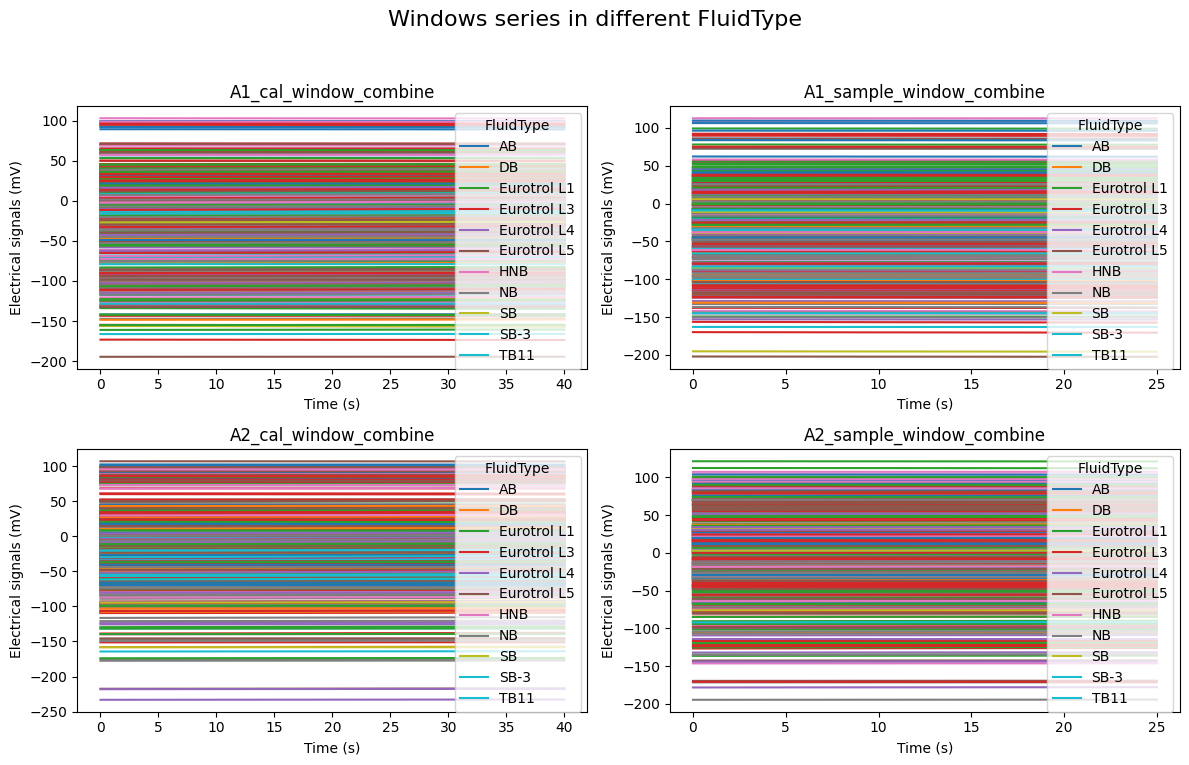

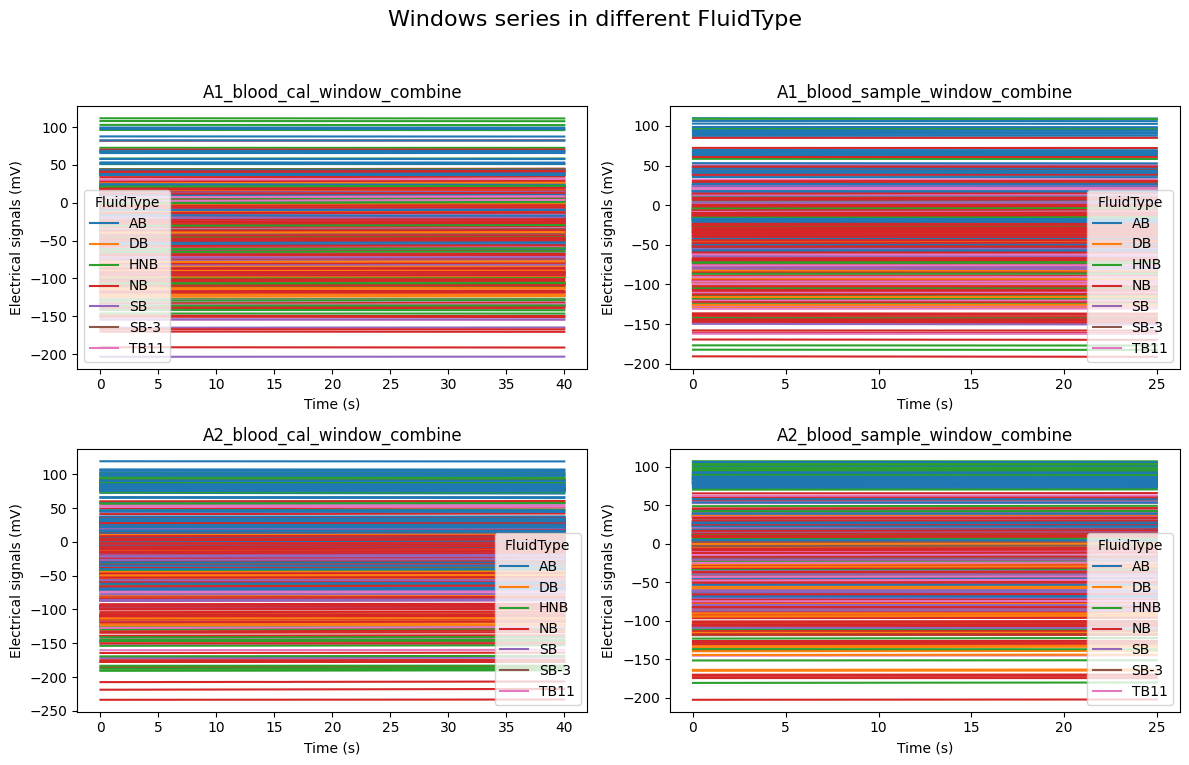

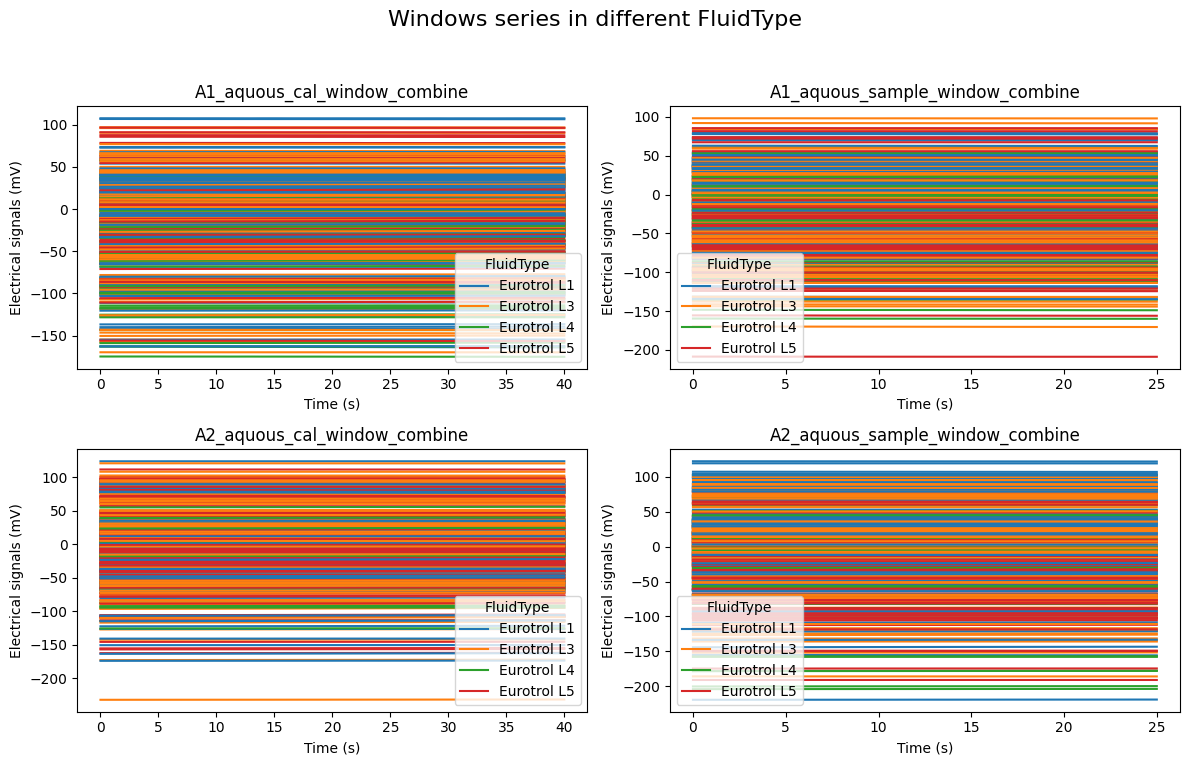

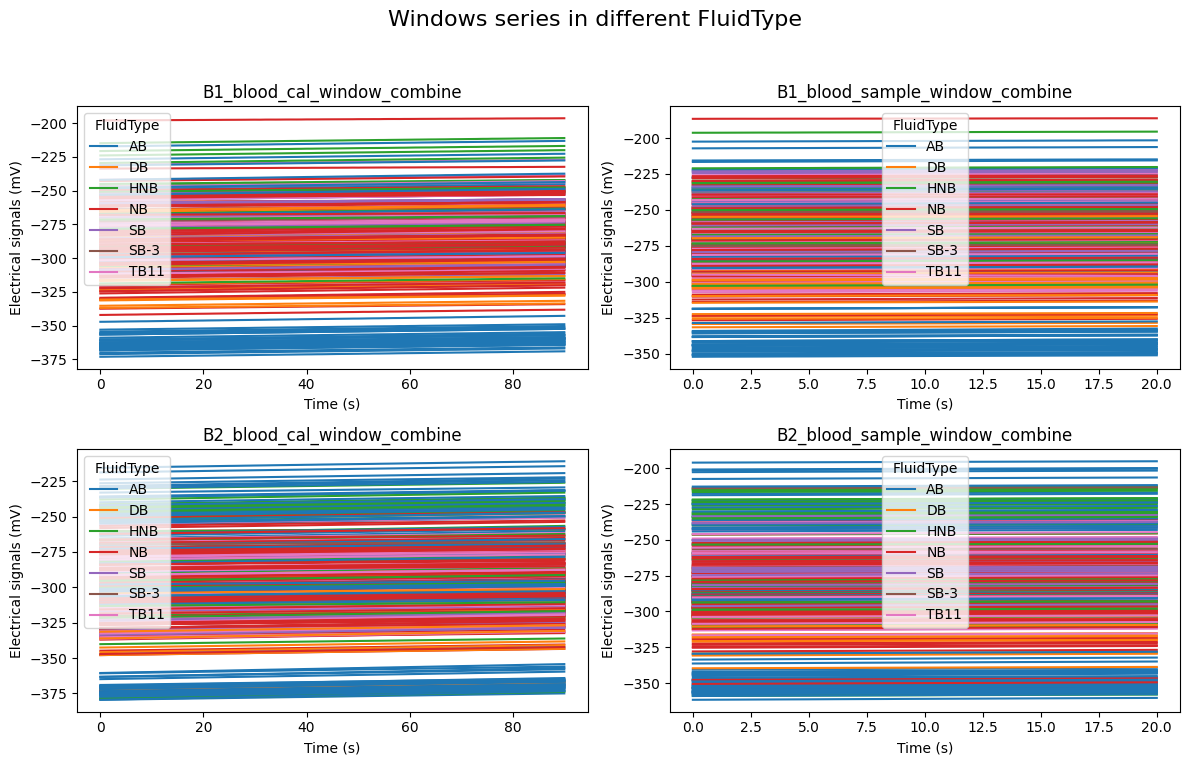

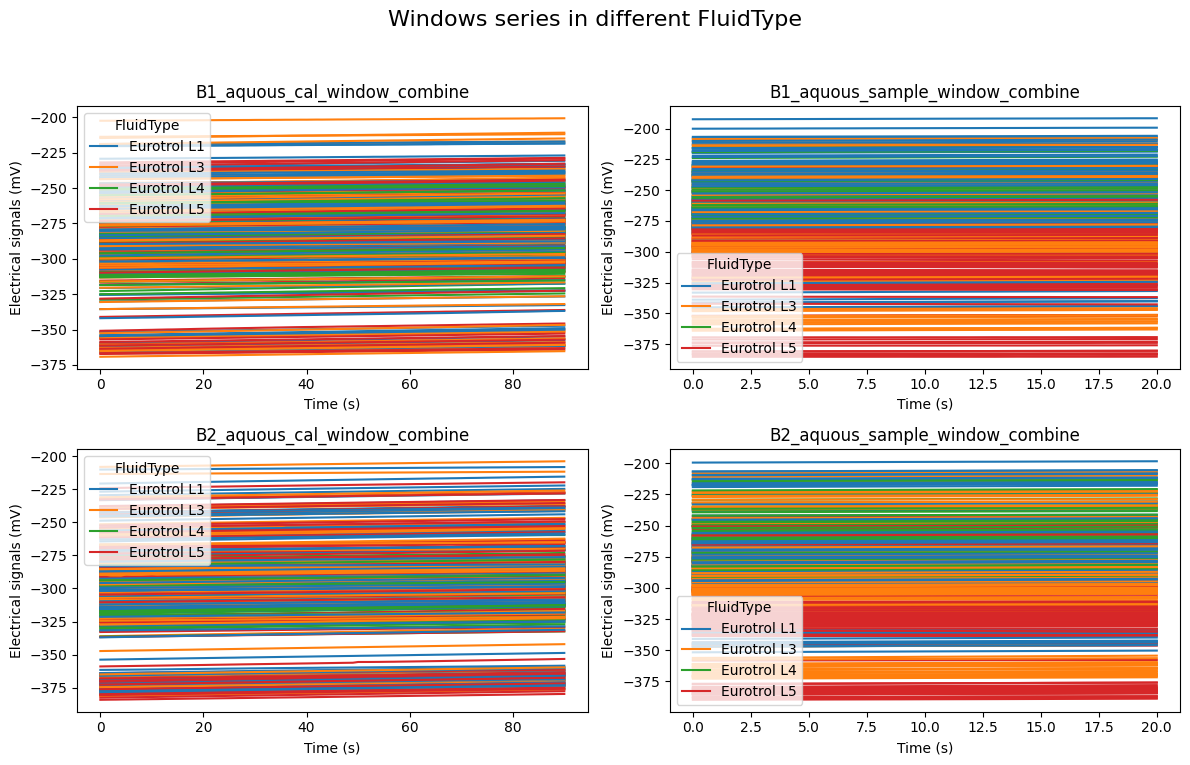

In [65]:
# Plot Fluid Type
plot_all_time_series_in_group(A1_cal_window_combine, A1_sample_window_combine, A2_cal_window_combine,A2_sample_window_combine,"FluidType","A1_cal_window_combine", "A1_sample_window_combine", "A2_cal_window_combine", "A2_sample_window_combine")
plot_all_time_series_in_group(A1_blood_cal_window_combine, A1_blood_sample_window_combine,A2_blood_cal_window_combine, A2_blood_sample_window_combine,"FluidType","A1_blood_cal_window_combine", "A1_blood_sample_window_combine","A2_blood_cal_window_combine", "A2_blood_sample_window_combine")
plot_all_time_series_in_group(A1_aquous_cal_window_combine, A1_aquous_sample_window_combine,A2_aquous_cal_window_combine, A2_aquous_sample_window_combine,"FluidType","A1_aquous_cal_window_combine", "A1_aquous_sample_window_combine","A2_aquous_cal_window_combine", "A2_aquous_sample_window_combine")

plot_all_time_series_in_group(B1_blood_cal_window_combine, B1_blood_sample_window_combine, B2_blood_cal_window_combine, B2_blood_sample_window_combine, "FluidType", "B1_blood_cal_window_combine", "B1_blood_sample_window_combine", "B2_blood_cal_window_combine", "B2_blood_sample_window_combine")
plot_all_time_series_in_group(B1_aquous_cal_window_combine, B1_aquous_sample_window_combine, B2_aquous_cal_window_combine, B2_aquous_sample_window_combine, "FluidType", "B1_aquous_cal_window_combine", "B1_aquous_sample_window_combine", "B2_aquous_cal_window_combine", "B2_aquous_sample_window_combine")

# plot_all_time_series_in_group(A1_cal_window_combine, "FluidType", "A1_cal_window_combine")
# plot_all_time_series_in_group(A2_cal_window_combine, "FluidType", "A2_cal_window_combine")
# plot_all_time_series_in_group(A1_blood_cal_window_combine, "FluidType", "A1_blood_cal_window_combine")
# plot_all_time_series_in_group(A2_blood_cal_window_combine, "FluidType", "A2_blood_cal_window_combine")
# plot_all_time_series_in_group(A1_aquous_cal_window_combine, "FluidType", "A1_aquous_cal_window_combine")
# plot_all_time_series_in_group(A2_aquous_cal_window_combine, "FluidType", "A2_aquous_cal_window_combine")

# plot_all_time_series_in_group(B1_blood_cal_window_combine, "FluidType", "B1_blood_cal_window_combine")
# plot_all_time_series_in_group(B2_blood_cal_window_combine, "FluidType", "B2_blood_cal_window_combine")
# plot_all_time_series_in_group(B1_aquous_cal_window_combine, "FluidType", "B1_aquous_cal_window_combine")
# plot_all_time_series_in_group(B2_aquous_cal_window_combine, "FluidType", "B2_aquous_cal_window_combine")

# print("Sample Window")
# # Plot Fluid Type
# plot_all_time_series_in_group(A1_sample_window_combine, "FluidType", "A1_sample_window_combine")
# plot_all_time_series_in_group(A2_sample_window_combine, "FluidType", "A2_sample_window_combine")
# plot_all_time_series_in_group(A1_blood_sample_window_combine, "FluidType", "A1_blood_sample_window_combine")
# plot_all_time_series_in_group(A2_blood_sample_window_combine, "FluidType", "A2_blood_sample_window_combine")
# plot_all_time_series_in_group(A1_aquous_sample_window_combine, "FluidType", "A1_aquous_sample_window_combine")
# plot_all_time_series_in_group(A2_aquous_sample_window_combine, "FluidType", "A2_aquous_sample_window_combine")

# plot_all_time_series_in_group(B1_blood_sample_window_combine, "FluidType", "B1_blood_sample_window_combine")
# plot_all_time_series_in_group(B2_blood_sample_window_combine, "FluidType", "B2_blood_sample_window_combine")
# plot_all_time_series_in_group(B1_aquous_sample_window_combine, "FluidType", "B1_aquous_sample_window_combine")
# plot_all_time_series_in_group(B2_aquous_sample_window_combine, "FluidType", "B2_aquous_sample_window_combine")


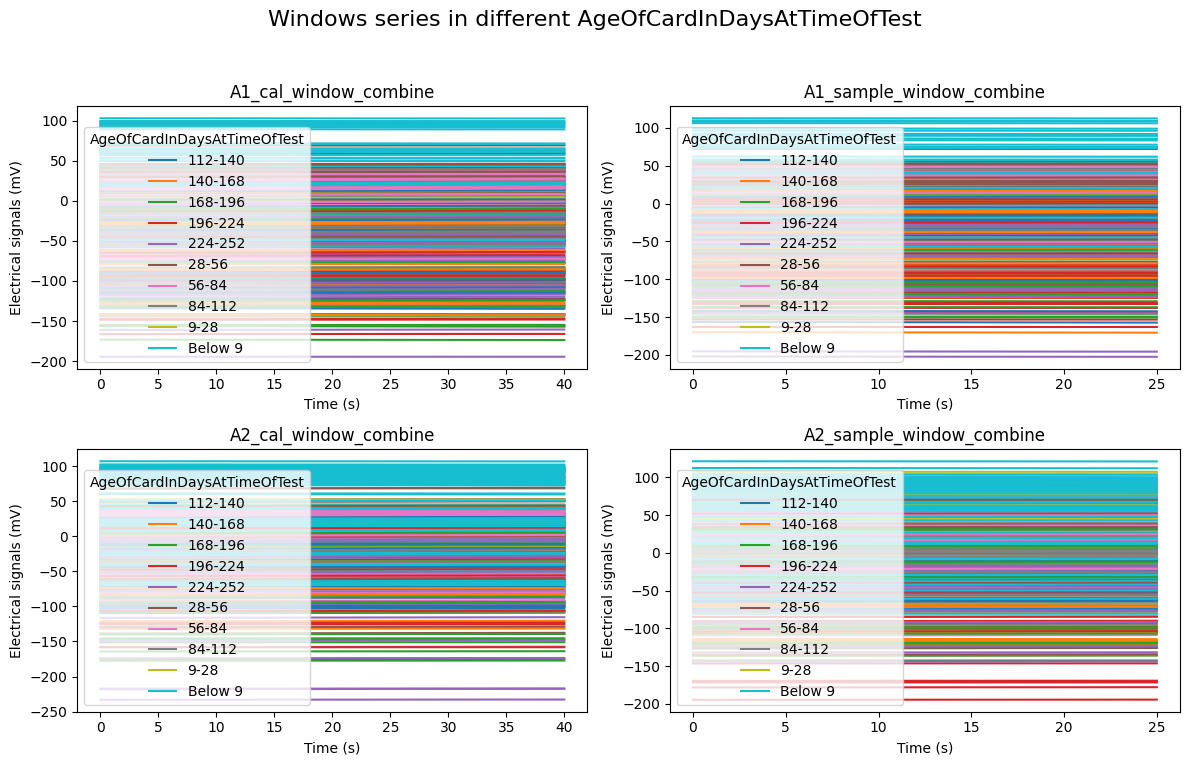

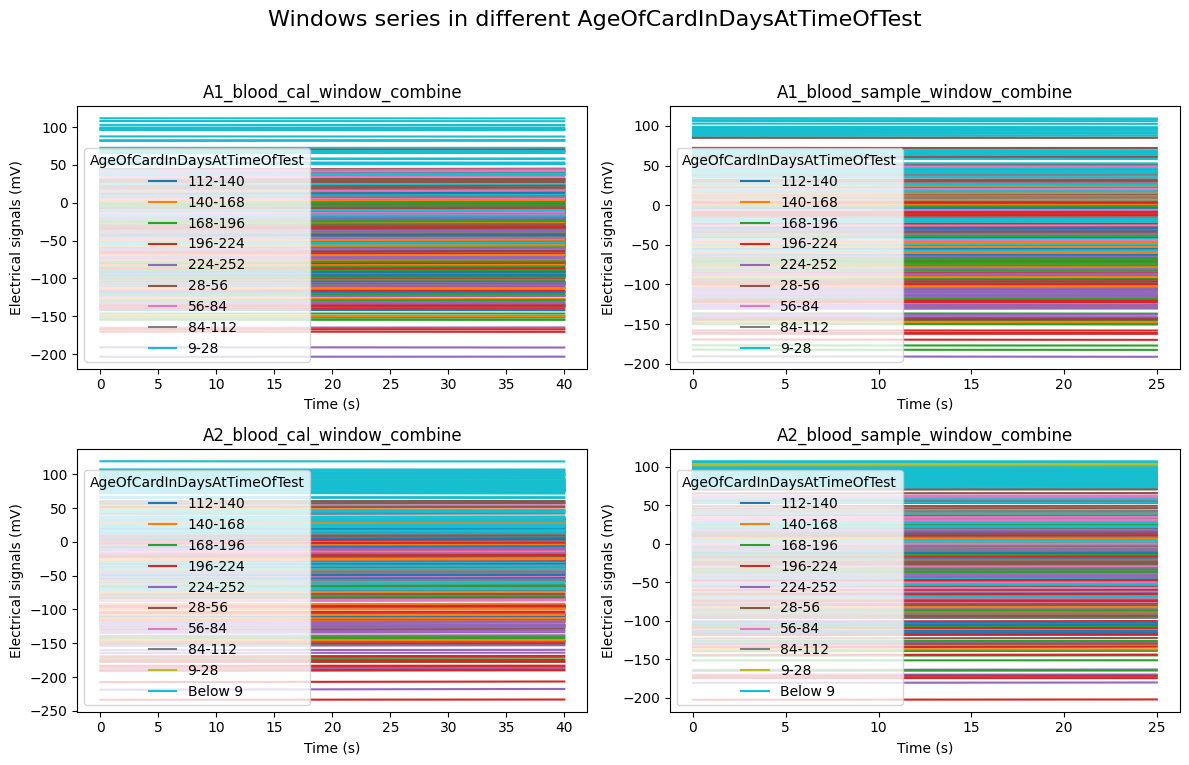

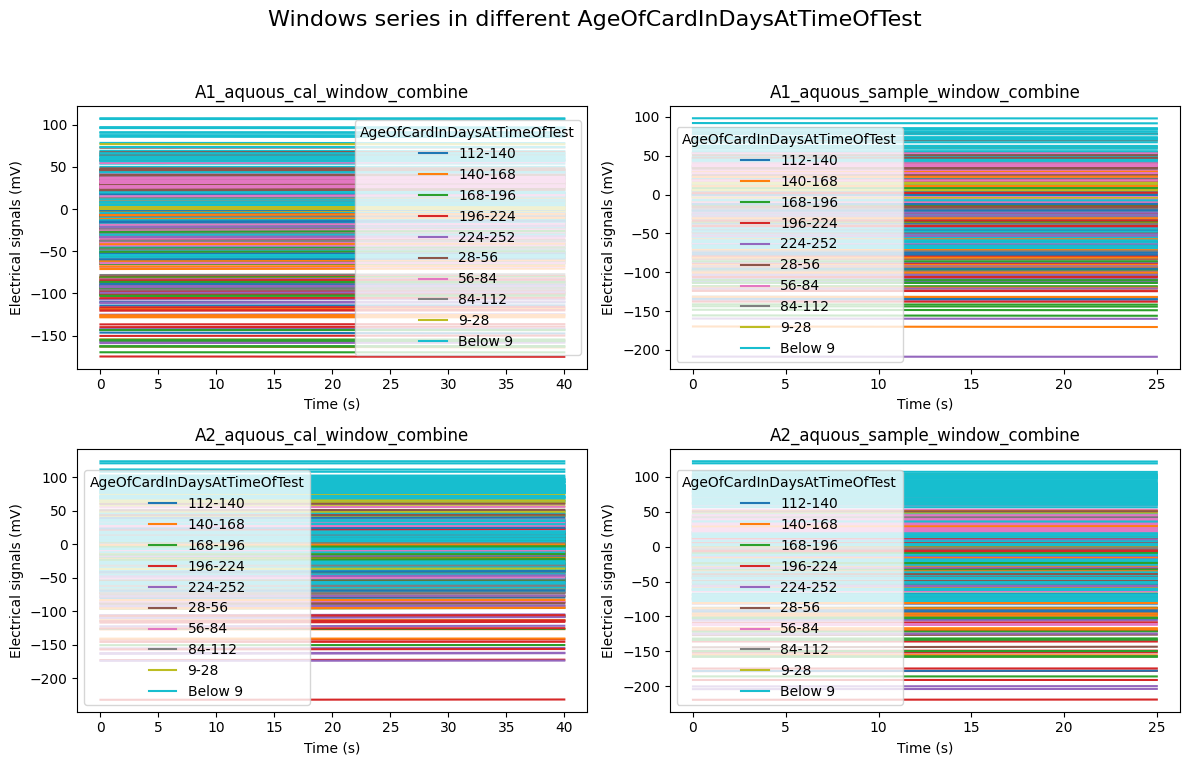

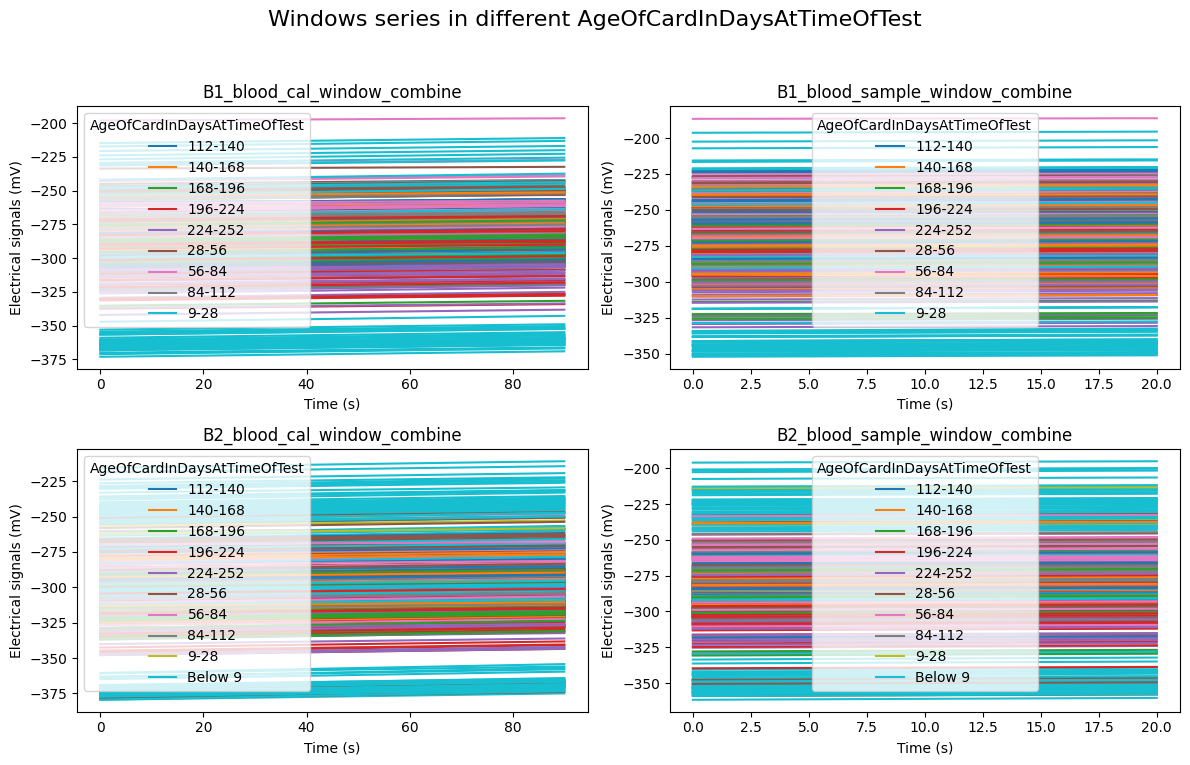

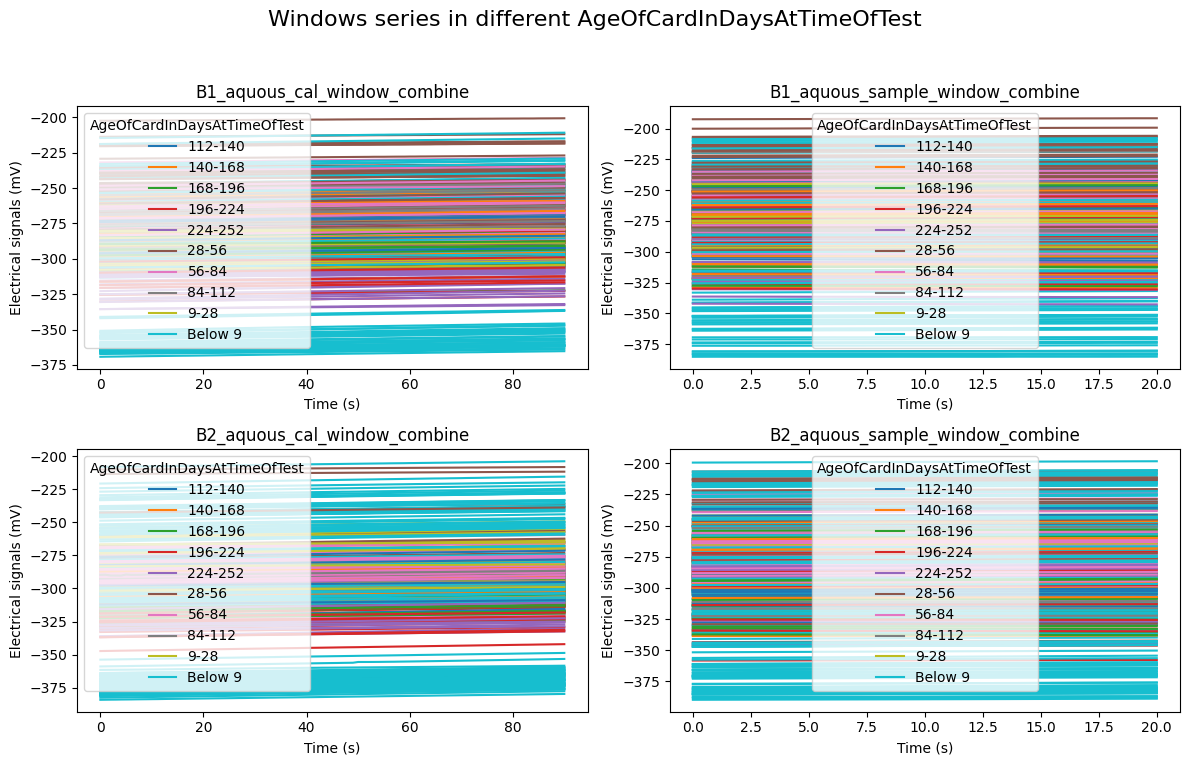

In [66]:
# Plot Card Age
plot_all_time_series_in_group(A1_cal_window_combine, A1_sample_window_combine, A2_cal_window_combine,A2_sample_window_combine,"AgeOfCardInDaysAtTimeOfTest","A1_cal_window_combine", "A1_sample_window_combine", "A2_cal_window_combine", "A2_sample_window_combine")
plot_all_time_series_in_group(A1_blood_cal_window_combine, A1_blood_sample_window_combine,A2_blood_cal_window_combine, A2_blood_sample_window_combine,"AgeOfCardInDaysAtTimeOfTest","A1_blood_cal_window_combine", "A1_blood_sample_window_combine","A2_blood_cal_window_combine", "A2_blood_sample_window_combine")
plot_all_time_series_in_group(A1_aquous_cal_window_combine, A1_aquous_sample_window_combine,A2_aquous_cal_window_combine, A2_aquous_sample_window_combine,"AgeOfCardInDaysAtTimeOfTest","A1_aquous_cal_window_combine", "A1_aquous_sample_window_combine","A2_aquous_cal_window_combine", "A2_aquous_sample_window_combine")

plot_all_time_series_in_group(B1_blood_cal_window_combine, B1_blood_sample_window_combine, B2_blood_cal_window_combine, B2_blood_sample_window_combine, "AgeOfCardInDaysAtTimeOfTest", "B1_blood_cal_window_combine", "B1_blood_sample_window_combine", "B2_blood_cal_window_combine", "B2_blood_sample_window_combine")
plot_all_time_series_in_group(B1_aquous_cal_window_combine, B1_aquous_sample_window_combine, B2_aquous_cal_window_combine, B2_aquous_sample_window_combine, "AgeOfCardInDaysAtTimeOfTest", "B1_aquous_cal_window_combine", "B1_aquous_sample_window_combine", "B2_aquous_cal_window_combine", "B2_aquous_sample_window_combine")



# plot_all_time_series_in_group(A1_cal_window_combine, "AgeOfCardInDaysAtTimeOfTest", "A1_cal_window_combine")
# plot_all_time_series_in_group(A2_cal_window_combine, "AgeOfCardInDaysAtTimeOfTest", "A2_cal_window_combine")
# plot_all_time_series_in_group(A1_blood_cal_window_combine, "AgeOfCardInDaysAtTimeOfTest", "A1_blood_cal_window_combine")
# plot_all_time_series_in_group(A2_blood_cal_window_combine, "AgeOfCardInDaysAtTimeOfTest", "A2_blood_cal_window_combine")
# plot_all_time_series_in_group(A1_aquous_cal_window_combine, "AgeOfCardInDaysAtTimeOfTest", "A1_aquous_cal_window_combine")
# plot_all_time_series_in_group(A2_aquous_cal_window_combine, "AgeOfCardInDaysAtTimeOfTest", "A2_aquous_cal_window_combine")

# plot_all_time_series_in_group(B1_blood_cal_window_combine, "AgeOfCardInDaysAtTimeOfTest", "B1_blood_cal_window_combine")
# plot_all_time_series_in_group(B2_blood_cal_window_combine, "AgeOfCardInDaysAtTimeOfTest", "B2_blood_cal_window_combine")
# plot_all_time_series_in_group(B1_aquous_cal_window_combine, "AgeOfCardInDaysAtTimeOfTest", "B1_aquous_cal_window_combine")
# plot_all_time_series_in_group(B2_aquous_cal_window_combine, "AgeOfCardInDaysAtTimeOfTest", "B2_aquous_cal_window_combine")

# print("Sample Window")

# # Plot Card Age
# plot_all_time_series_in_group(A1_sample_window_combine, "AgeOfCardInDaysAtTimeOfTest", "A1_sample_window_combine")
# plot_all_time_series_in_group(A2_sample_window_combine, "AgeOfCardInDaysAtTimeOfTest", "A2_sample_window_combine")

# plot_all_time_series_in_group(A1_blood_sample_window_combine, "AgeOfCardInDaysAtTimeOfTest", "A1_blood_sample_window_combine")
# plot_all_time_series_in_group(A2_blood_sample_window_combine, "AgeOfCardInDaysAtTimeOfTest", "A2_blood_sample_window_combine")
# plot_all_time_series_in_group(A1_aquous_sample_window_combine, "AgeOfCardInDaysAtTimeOfTest", "A1_aquous_sample_window_combine")
# plot_all_time_series_in_group(A2_aquous_sample_window_combine, "AgeOfCardInDaysAtTimeOfTest", "A2_aquous_sample_window_combine")

# plot_all_time_series_in_group(B1_blood_sample_window_combine, "AgeOfCardInDaysAtTimeOfTest", "B1_blood_sample_window_combine")
# plot_all_time_series_in_group(B2_blood_sample_window_combine, "AgeOfCardInDaysAtTimeOfTest", "B2_blood_sample_window_combine")
# plot_all_time_series_in_group(B1_aquous_sample_window_combine, "AgeOfCardInDaysAtTimeOfTest", "B1_aquous_sample_window_combine")
# plot_all_time_series_in_group(B2_aquous_sample_window_combine, "AgeOfCardInDaysAtTimeOfTest", "B2_aquous_sample_window_combine")


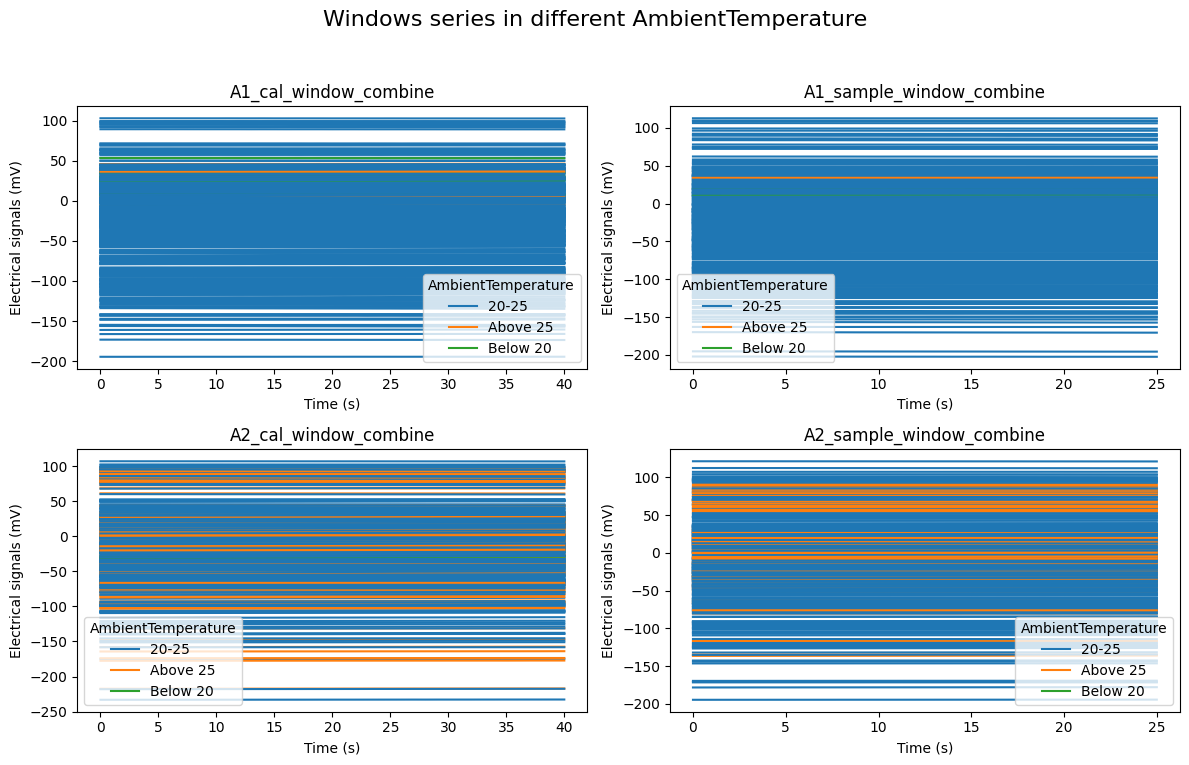

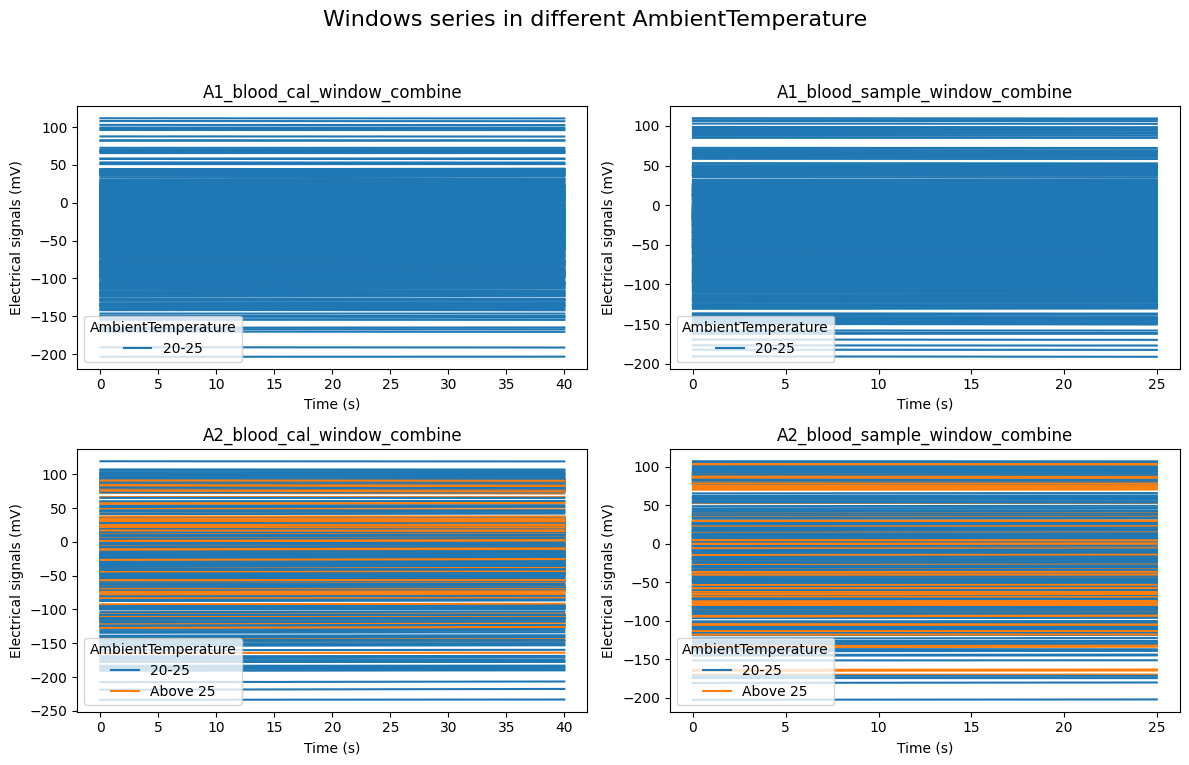

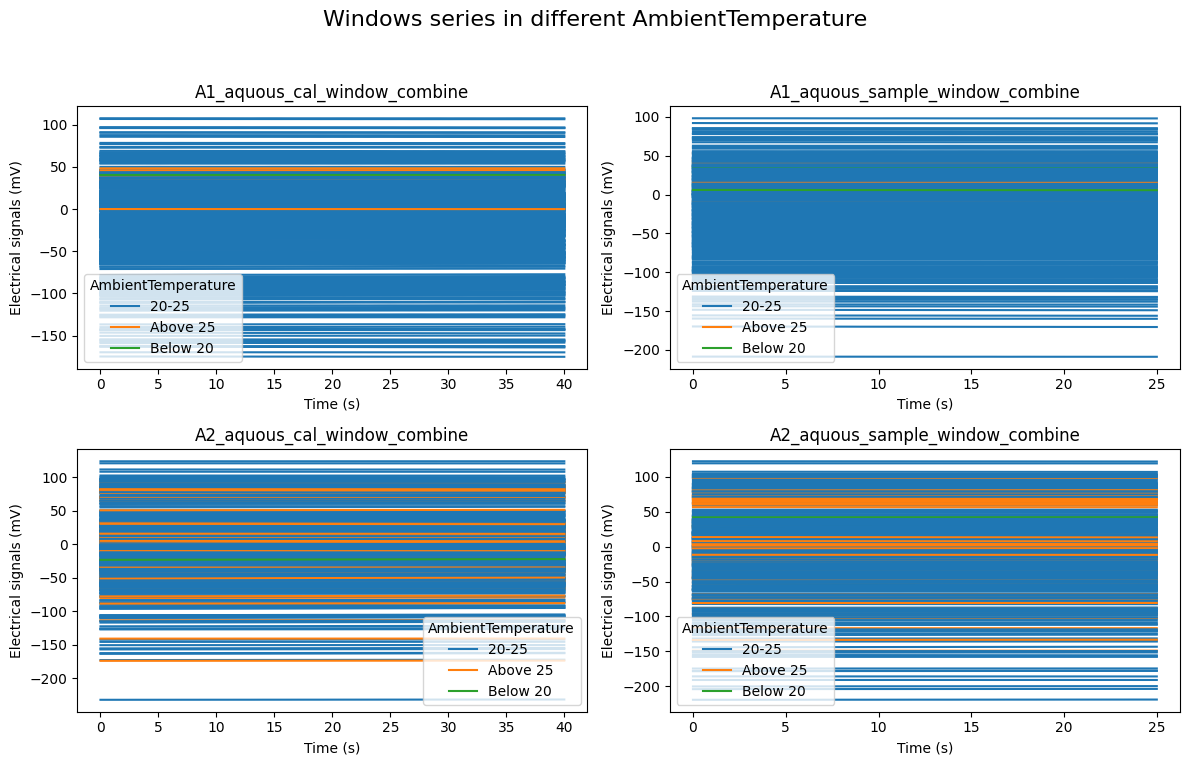

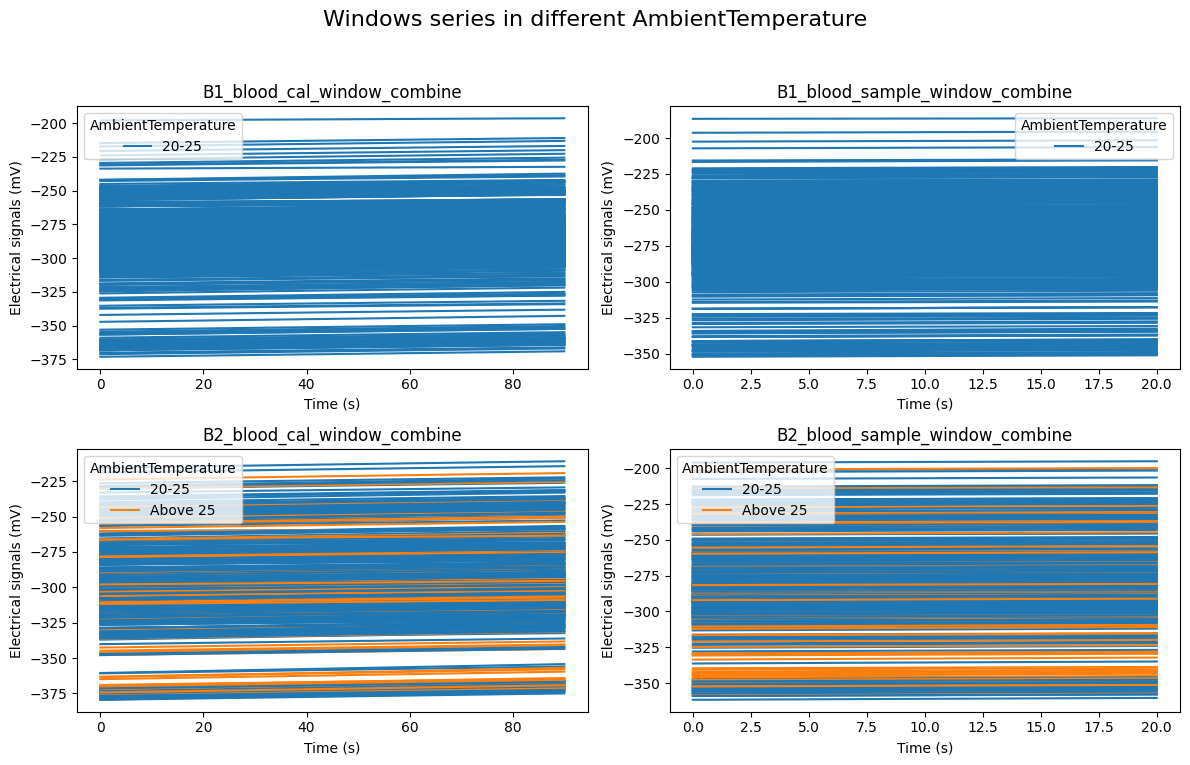

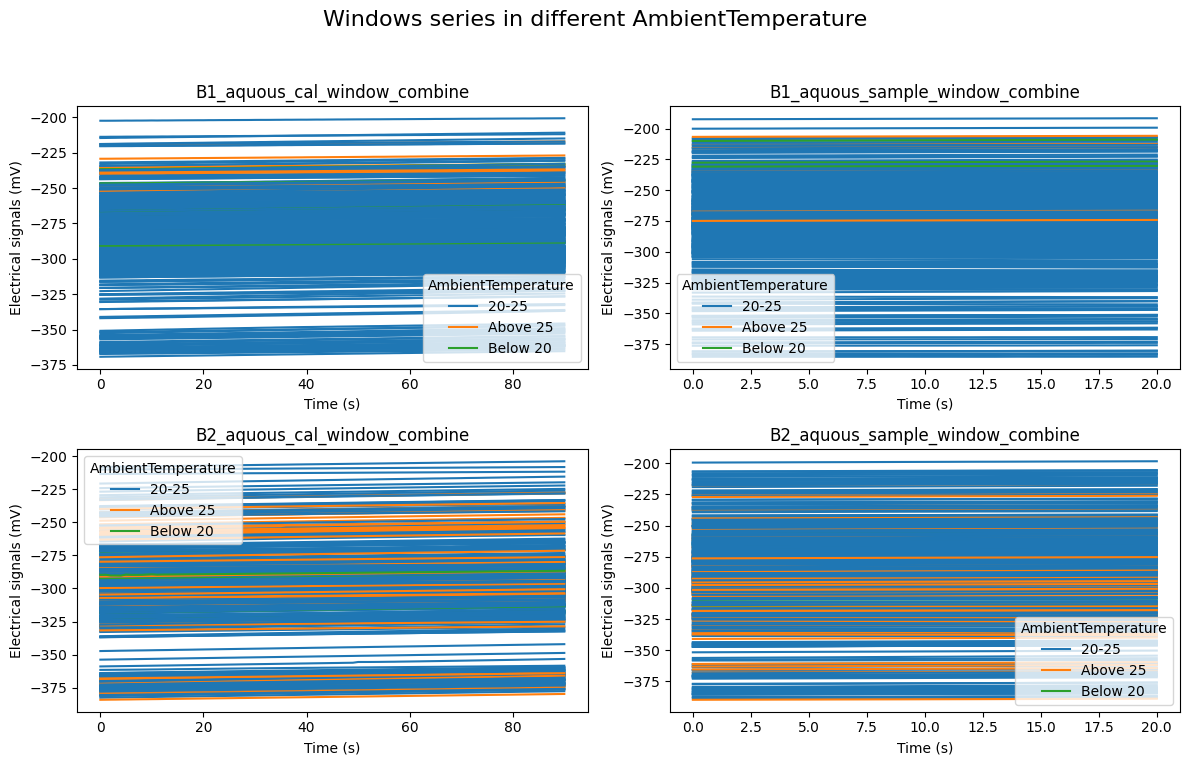

In [67]:
# Plot Temperature
plot_all_time_series_in_group(A1_cal_window_combine, A1_sample_window_combine, A2_cal_window_combine,A2_sample_window_combine,"AmbientTemperature","A1_cal_window_combine", "A1_sample_window_combine", "A2_cal_window_combine", "A2_sample_window_combine")
plot_all_time_series_in_group(A1_blood_cal_window_combine, A1_blood_sample_window_combine,A2_blood_cal_window_combine, A2_blood_sample_window_combine,"AmbientTemperature","A1_blood_cal_window_combine", "A1_blood_sample_window_combine","A2_blood_cal_window_combine", "A2_blood_sample_window_combine")
plot_all_time_series_in_group(A1_aquous_cal_window_combine, A1_aquous_sample_window_combine,A2_aquous_cal_window_combine, A2_aquous_sample_window_combine,"AmbientTemperature","A1_aquous_cal_window_combine", "A1_aquous_sample_window_combine","A2_aquous_cal_window_combine", "A2_aquous_sample_window_combine")

plot_all_time_series_in_group(B1_blood_cal_window_combine, B1_blood_sample_window_combine, B2_blood_cal_window_combine, B2_blood_sample_window_combine, "AmbientTemperature", "B1_blood_cal_window_combine", "B1_blood_sample_window_combine", "B2_blood_cal_window_combine", "B2_blood_sample_window_combine")
plot_all_time_series_in_group(B1_aquous_cal_window_combine, B1_aquous_sample_window_combine, B2_aquous_cal_window_combine, B2_aquous_sample_window_combine, "AmbientTemperature", "B1_aquous_cal_window_combine", "B1_aquous_sample_window_combine", "B2_aquous_cal_window_combine", "B2_aquous_sample_window_combine")


# plot_all_time_series_in_group(A1_cal_window_combine, "AmbientTemperature", "A1_cal_window_combine")
# plot_all_time_series_in_group(A2_cal_window_combine, "AmbientTemperature", "A2_cal_window_combine")
# plot_all_time_series_in_group(A1_blood_cal_window_combine, "AmbientTemperature", "A1_blood_cal_window_combine")
# plot_all_time_series_in_group(A2_blood_cal_window_combine, "AmbientTemperature", "A2_blood_cal_window_combine")
# plot_all_time_series_in_group(A1_aquous_cal_window_combine, "AmbientTemperature", "A1_aquous_cal_window_combine")
# plot_all_time_series_in_group(A2_aquous_cal_window_combine, "AmbientTemperature", "A2_aquous_cal_window_combine")

# plot_all_time_series_in_group(B1_blood_cal_window_combine, "AmbientTemperature", "B1_blood_cal_window_combine")
# plot_all_time_series_in_group(B2_blood_cal_window_combine, "AmbientTemperature", "B2_blood_cal_window_combine")
# plot_all_time_series_in_group(B1_aquous_cal_window_combine, "AmbientTemperature", "B1_aquous_cal_window_combine")
# plot_all_time_series_in_group(B2_aquous_cal_window_combine, "AmbientTemperature", "B2_aquous_cal_window_combine")

# print("Sample Window")

# # Plot Temperature
# plot_all_time_series_in_group(A1_sample_window_combine, "AmbientTemperature", "A1_sample_window_combine")
# plot_all_time_series_in_group(A2_sample_window_combine, "AmbientTemperature", "A2_sample_window_combine")
# plot_all_time_series_in_group(A1_blood_sample_window_combine, "AmbientTemperature", "A1_blood_sample_window_combine")
# plot_all_time_series_in_group(A2_blood_sample_window_combine, "AmbientTemperature", "A2_blood_sample_window_combine")
# plot_all_time_series_in_group(A1_aquous_sample_window_combine, "AmbientTemperature", "A1_aquous_sample_window_combine")
# plot_all_time_series_in_group(A2_aquous_sample_window_combine, "AmbientTemperature", "A2_aquous_sample_window_combine")

# plot_all_time_series_in_group(B1_blood_sample_window_combine, "AmbientTemperature", "B1_blood_sample_window_combine")
# plot_all_time_series_in_group(B2_blood_sample_window_combine, "AmbientTemperature", "B2_blood_sample_window_combine")
# plot_all_time_series_in_group(B1_aquous_sample_window_combine, "AmbientTemperature", "B1_aquous_sample_window_combine")
# plot_all_time_series_in_group(B2_aquous_sample_window_combine, "AmbientTemperature", "B2_aquous_sample_window_combine")


In [68]:
def plot_all_time_series(df):
    plt.figure(figsize=(6, 4))

    for index, row in df.iterrows():
        plt.plot(row.values, label=f'Time Series {index + 1}')

    plt.ylabel('Electrical signals (mV)')
    plt.xlabel('Time (s)')

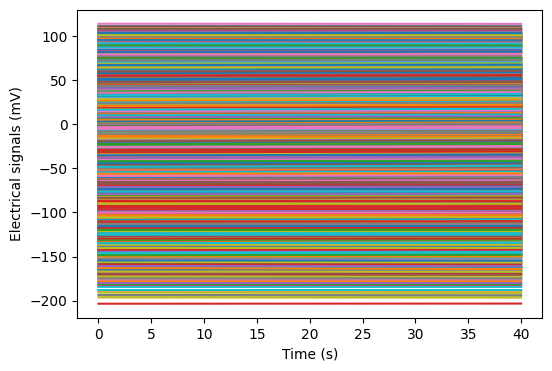

In [69]:
plot_all_time_series(A1_cal_window)

## 10. PCA

1. Standardize the data
2. Visualize the standardize data
3. Apply PCA setting 2 PC's
4. Extract the Scores
5. Identify the Time Series which contribute most to each PC

Thanks to PCA's sensitivity, it can be used to detect outliers in multivariate datasets. Principal Component Analysis (PCA) is a widely used technique for dimensionality reduction while preserving relevant information. Due to its sensitivity, it can also be used to detect outliers in multivariate datasets.

https://s-ai-f.github.io/Time-Series/outlier-detection-in-time-series.html

In [70]:
def perform_pca_analysis(data, title):
    # Step 1: Scale the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Visualizing scale data
    data_scaled_df = pd.DataFrame(data_scaled, columns=data.columns)
    plot_all_time_series(data_scaled_df)
    plt.title(title)
    plt.show()

    # Step 2: Determine the number of components
    pca_full = PCA()
    pca_full.fit(data_scaled)
    print('Explained variance for each component:')
    print(pca_full.explained_variance_ratio_)

    # Step 3: Apply PCA on 2 components
    pca = PCA(n_components=2)
    pca_scores = pca.fit_transform(data_scaled)

    # Explain variance ratio
    print('\nExplain variance PC1 (%): ', pca.explained_variance_ratio_[0]*100)
    print('Explain variance PC2 (%): ', pca.explained_variance_ratio_[1]*100)

    # Loadings
    loadings = pca.components_
    loadings_df = pd.DataFrame(loadings.T, columns=['PC1_Loadings', 'PC2_Loadings'], index=[f'TimePoint_{i}' for i in range(data_scaled.shape[1])])
    print("\nLoadings:\n", loadings_df)

    # Scores
    scores_df = pd.DataFrame(pca_scores, columns=['PC1_Scores', 'PC2_Scores'], index=[f'TimeSeries_{data.index[i]}' for i in range(data_scaled.shape[0])])
    print("\nPC Scores:\n", scores_df)

    # Identify which time series contributes the most to each principal component
    max_contribution_index_pc1 = np.argmax(np.abs(pca_scores[:, 0]))
    max_contribution_index_pc2 = np.argmax(np.abs(pca_scores[:, 1]))
    print(f'\nThe time series contributing most to PC1 is at index {max_contribution_index_pc1} with TestID {data.index[max_contribution_index_pc1]}')
    print(f'The time series contributing most to PC2 is at index {max_contribution_index_pc2} with TestID {data.index[max_contribution_index_pc2]}')

    # PCA visualization
    plt.figure(figsize=(6, 4))
    plt.scatter(pca_scores[:, 0], pca_scores[:, 1], label='System 1')
    plt.title('PCA Visualization')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

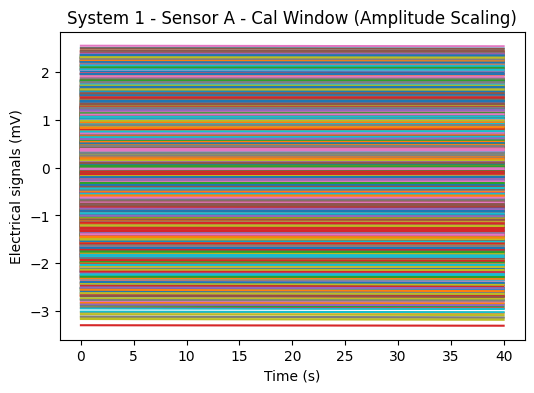

Explained variance for each component:
[9.99989640e-01 1.03240259e-05 2.53585878e-09 1.46176144e-09
 1.19641970e-09 1.11223588e-09 1.07884893e-09 1.04469926e-09
 1.01399563e-09 1.00197716e-09 9.79934006e-10 9.52342398e-10
 9.42709044e-10 9.33002932e-10 9.23663022e-10 9.18679583e-10
 9.00150266e-10 8.87693876e-10 8.81770130e-10 8.76580061e-10
 8.64427245e-10 8.53283835e-10 8.33819720e-10 8.31419786e-10
 8.18389160e-10 8.17900559e-10 7.99371459e-10 7.88936160e-10
 7.81148845e-10 7.77458211e-10 7.71216479e-10 7.63507241e-10
 7.56125785e-10 7.48570354e-10 7.36251669e-10 7.27487564e-10
 7.17565029e-10 7.12864963e-10 7.00863498e-10 6.99615472e-10
 6.81679039e-10]

Explain variance PC1 (%):  99.99896401498862
Explain variance PC2 (%):  0.0010324025890230525

Loadings:
               PC1_Loadings  PC2_Loadings
TimePoint_0      -0.156172      0.266146
TimePoint_1      -0.156172      0.252600
TimePoint_2      -0.156173      0.238938
TimePoint_3      -0.156173      0.225551
TimePoint_4      -0.15

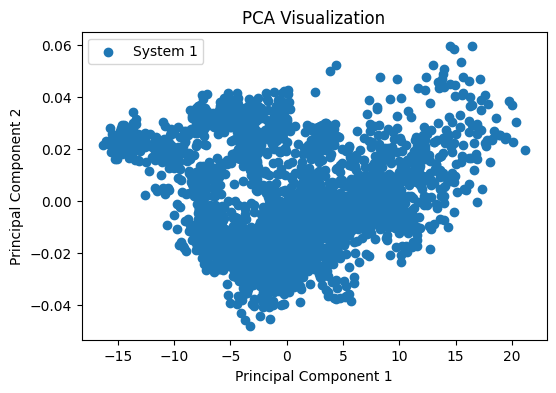

In [71]:
perform_pca_analysis(A1_cal_window, 'System 1 - Sensor A - Cal Window (Amplitude Scaling)')

## 11. Functional PCA

In [72]:
pip install scikit-fda

In [73]:
import numpy as np
import pandas as pd
from skfda.representation.grid import FDataGrid
from skfda.preprocessing.dim_reduction.projection import FPCA

def perform_functional_pca(data_matrix, title):
    # Convert the data matrix to an FDataGrid object
    fd = FDataGrid(data_matrix=data_matrix, grid_points=data_matrix.columns.astype(float))

    # Apply Functional PCA
    fpca = FPCA(n_components=2)
    fpca.fit(fd)

    pc_scores = fpca.transform(fd)

    # Explain variance ratio
    print('Explain variance PC1 (%): ', fpca.explained_variance_ratio_[0] * 100)
    print('Explain variance PC2 (%): ', fpca.explained_variance_ratio_[1] * 100)

    # --- Loadings ---
    # Extract the principal components (loadings)
    principal_components = fpca.components_

    # --- Scores ---
    # Print the scores to see contributions of each time series to each principal component
    pc_scores_df = pd.DataFrame(pc_scores, columns=['PC1_Scores', 'PC2_Scores'],
                                index=[f'TimeSeries_{data_matrix.index[i]}' for i in range(data_matrix.shape[0])])
    print("PC Scores:\n", pc_scores_df)

    # Identify which time series (functional data object) contributes the most to each principal component
    max_contribution_index_pc1 = np.argmax(np.abs(pc_scores[:, 0]))  # Index of the maximum absolute score in the first PC
    max_contribution_index_pc2 = np.argmax(np.abs(pc_scores[:, 1]))  # Index of the maximum absolute score in the second PC

    print(f'The time series contributing most to PC1 is at index {max_contribution_index_pc1} with TestID {data_matrix.index[max_contribution_index_pc1]}')
    print(f'The time series contributing most to PC2 is at index {max_contribution_index_pc2} with TestID {data_matrix.index[max_contribution_index_pc2]}')

    # --- PCA visualization ---
    fpca.components_.plot()
    plt.title(title)
    plt.legend(['Component 1', 'Component 2'])
    #plt.figure(figsize=(4, 4))
    plt.show()
    fpca.components_[0].plot()
    plt.title(title)
    plt.legend(['Component 1'])
    plt.show()
    fpca.components_[1].plot()
    plt.title(title)
    plt.legend(['Component 2'])
    plt.show()
    #return [data_matrix.index[max_contribution_index_pc1], data_matrix.index[max_contribution_index_pc1]]

FPCA CALIBRATION WINDOW

A1_cal_window
Explain variance PC1 (%):  99.99901313297069
Explain variance PC2 (%):  0.0009833238630759923
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414200 -511.928238    0.953037
TimeSeries_12414201 -431.878434    0.321238
TimeSeries_12414202 -527.954625    0.837068
TimeSeries_12414203 -512.974359    0.772892
TimeSeries_12414204 -569.118691    0.931376
...                         ...         ...
TimeSeries_12537663 -208.148755   -1.509049
TimeSeries_12539049  -34.663259   -0.605466
TimeSeries_12572832  480.243758    1.049674
TimeSeries_12572836 -104.517339   -0.169876
TimeSeries_12622570  904.125936    1.548010

[3349 rows x 2 columns]
The time series contributing most to PC1 is at index 2683 with TestID 12573667
The time series contributing most to PC2 is at index 1784 with TestID 12529762


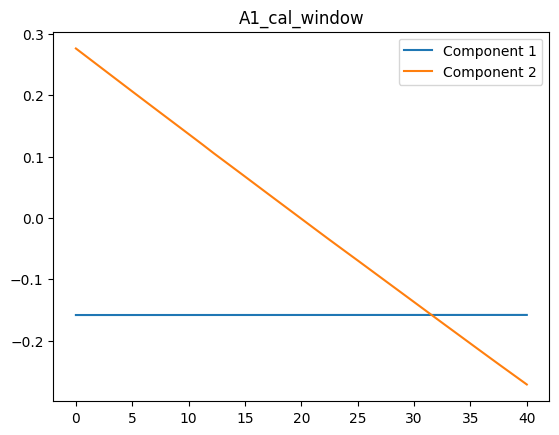

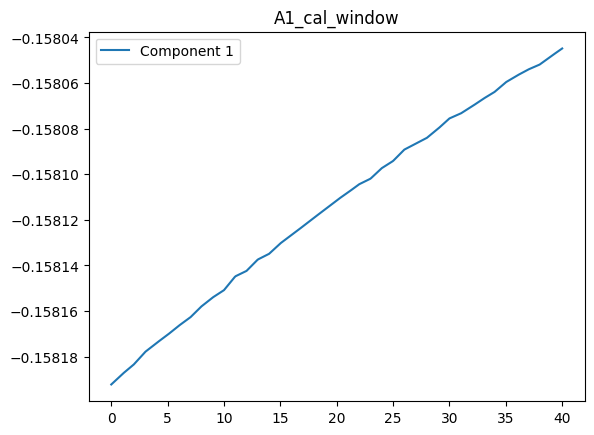

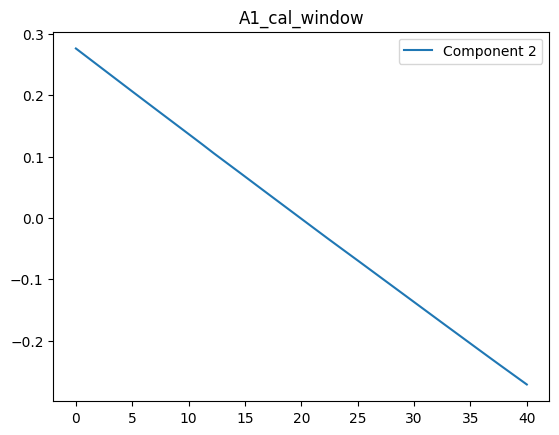

A2_cal_window
Explain variance PC1 (%):  99.99896719079081
Explain variance PC2 (%):  0.0010313889820635289
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3550995 -235.811528    0.952921
TimeSeries_3551012 -160.076481    1.060921
TimeSeries_3551031 -318.448001    1.483052
TimeSeries_3551047 -241.241502    0.929191
TimeSeries_3551065 -226.000292    1.093668
...                        ...         ...
TimeSeries_3518461  -32.332739    1.135309
TimeSeries_3518462  136.716909    1.716601
TimeSeries_3518621  174.316532    1.346695
TimeSeries_3518680 -420.002186    1.615260
TimeSeries_3518682  -90.097550    1.878944

[7535 rows x 2 columns]
The time series contributing most to PC1 is at index 5354 with TestID 3556087
The time series contributing most to PC2 is at index 6844 with TestID 3567819


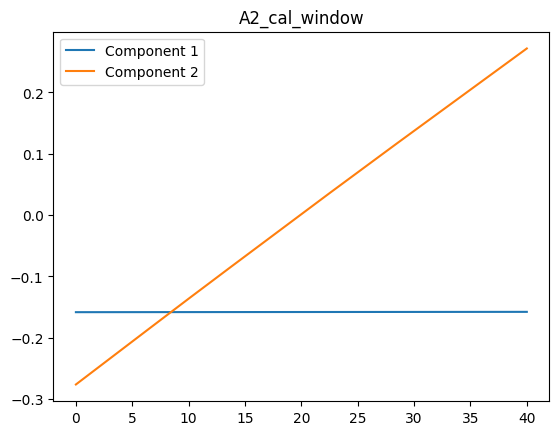

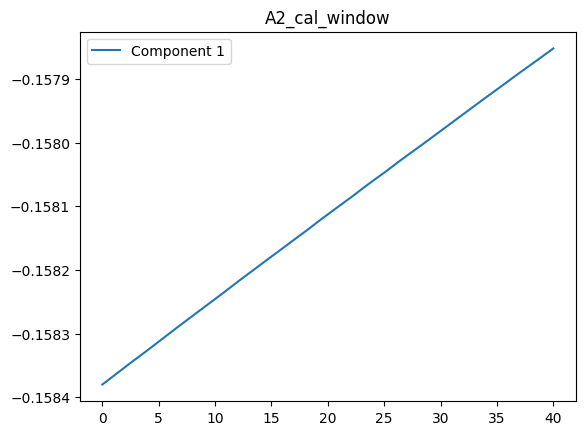

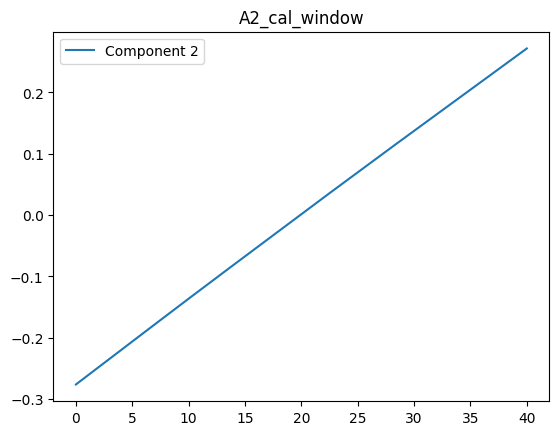

A1_blood_cal_window
Explain variance PC1 (%):  99.99903631073353
Explain variance PC2 (%):  0.0009600297561910744
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414372 -629.834138    1.125510
TimeSeries_12414373 -595.400743    1.159224
TimeSeries_12414374 -621.052115    1.234430
TimeSeries_12414375 -596.268795    1.117465
TimeSeries_12414377 -647.688876    1.506192
...                         ...         ...
TimeSeries_12470355  438.399068    1.051695
TimeSeries_12470361  543.245842    0.948795
TimeSeries_12470365  -16.820129   -0.712827
TimeSeries_12539049  -95.990977   -0.456802
TimeSeries_12622570  842.798898    1.376544

[1433 rows x 2 columns]
The time series contributing most to PC1 is at index 1042 with TestID 12573667
The time series contributing most to PC2 is at index 828 with TestID 12598120


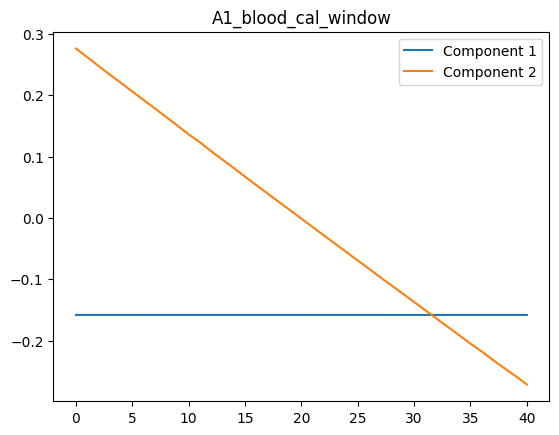

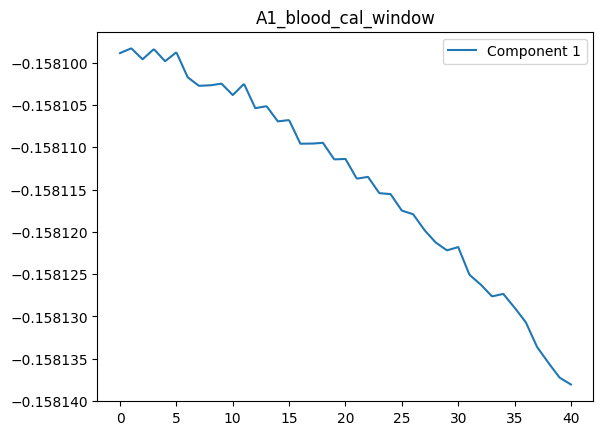

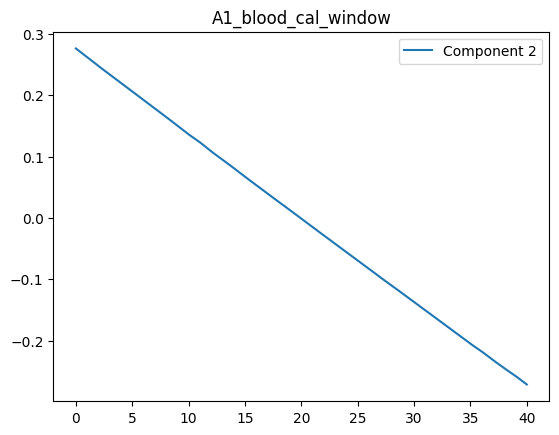

A2_blood_cal_window
Explain variance PC1 (%):  99.99906167648676
Explain variance PC2 (%):  0.0009370164270387049
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3545083 -665.977111   -0.623435
TimeSeries_3545084 -619.005020   -0.677462
TimeSeries_3545085 -508.275839   -0.958243
TimeSeries_3545086 -578.971979   -0.604525
TimeSeries_3545087 -537.851578   -0.625387
...                        ...         ...
TimeSeries_3518708 -522.267253    0.690908
TimeSeries_3518710  -14.594300    2.107727
TimeSeries_3518621  128.581721    1.181280
TimeSeries_3518680 -465.737029    1.369587
TimeSeries_3518682 -135.832431    1.677817

[2811 rows x 2 columns]
The time series contributing most to PC1 is at index 2133 with TestID 3572300
The time series contributing most to PC2 is at index 2424 with TestID 3567819


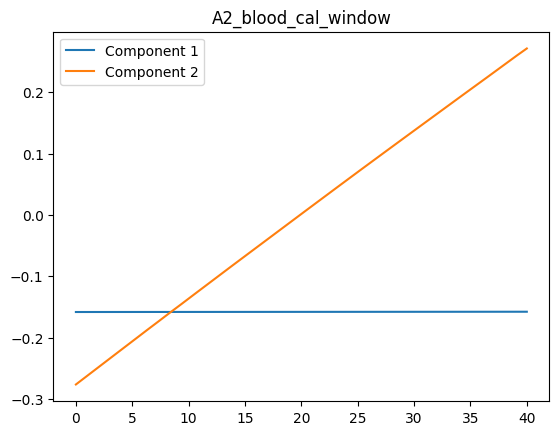

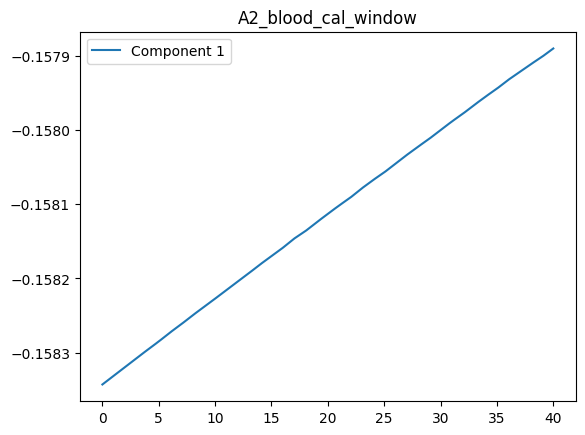

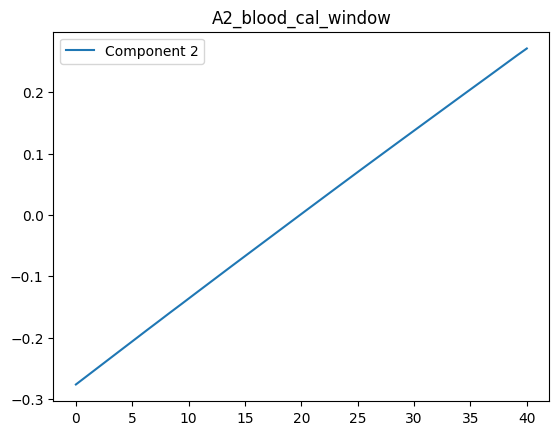

A1_aquous_cal_window
Explain variance PC1 (%):  99.99898050747007
Explain variance PC2 (%):  0.0010158898515333845
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414200 -466.060746    0.785260
TimeSeries_12414201 -386.010834    0.167402
TimeSeries_12414202 -482.087113    0.666505
TimeSeries_12414203 -467.106836    0.604938
TimeSeries_12414204 -523.251195    0.753668
...                         ...         ...
TimeSeries_12624891  -77.039267   -0.373435
TimeSeries_12624893 -110.343970   -0.341533
TimeSeries_12537663 -162.280840   -1.623983
TimeSeries_12572832  526.111217    1.054466
TimeSeries_12572836  -58.649659   -0.266792

[1916 rows x 2 columns]
The time series contributing most to PC1 is at index 1803 with TestID 12572826
The time series contributing most to PC2 is at index 1882 with TestID 12599845


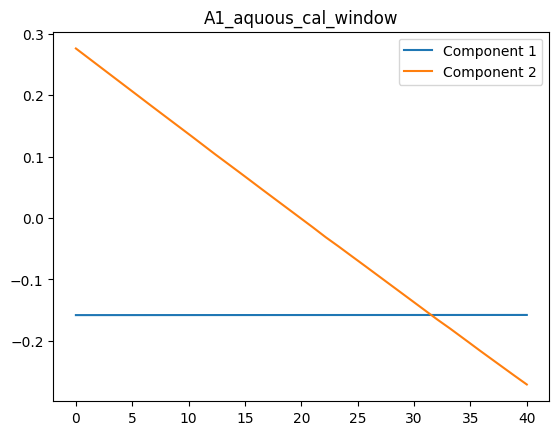

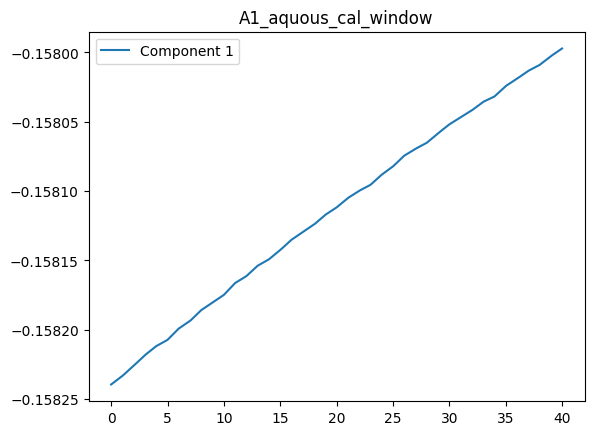

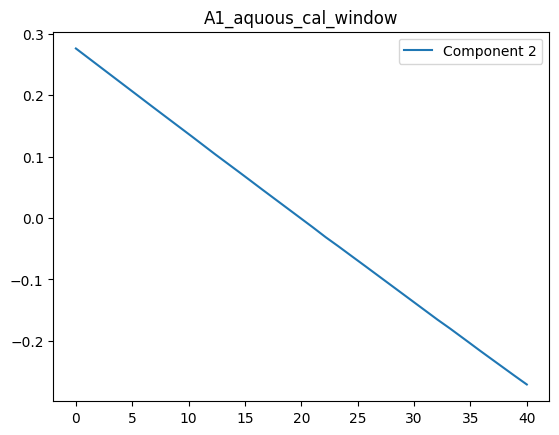

A2_aquous_cal_window
Explain variance PC1 (%):  99.99891324250726
Explain variance PC2 (%):  0.001085245296689053
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3550995 -208.597245   -1.068516
TimeSeries_3551012 -132.862194   -1.174030
TimeSeries_3551031 -291.233701   -1.601344
TimeSeries_3551047 -214.027219   -1.044957
TimeSeries_3551065 -198.786004   -1.208934
...                        ...         ...
TimeSeries_3518459 -422.986546   -0.589278
TimeSeries_3518460 -448.803156   -1.729648
TimeSeries_3518431  -95.234287   -1.572003
TimeSeries_3518461   -5.118450   -1.244237
TimeSeries_3518462  163.931217   -1.820001

[4724 rows x 2 columns]
The time series contributing most to PC1 is at index 3619 with TestID 3556087
The time series contributing most to PC2 is at index 3069 with TestID 3561214


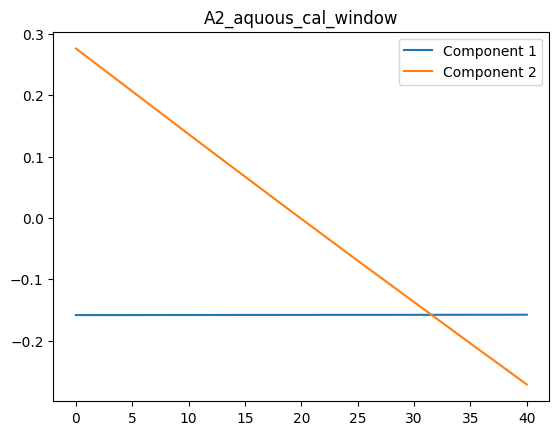

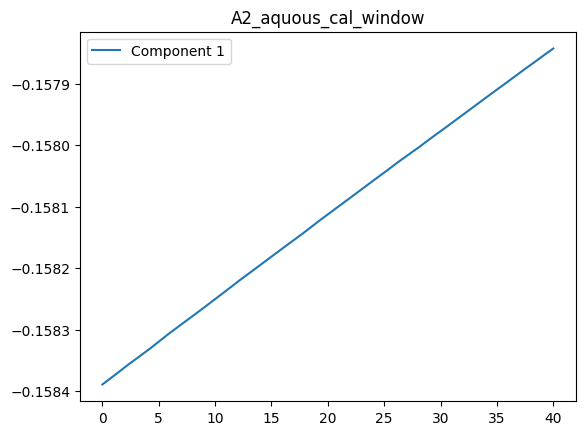

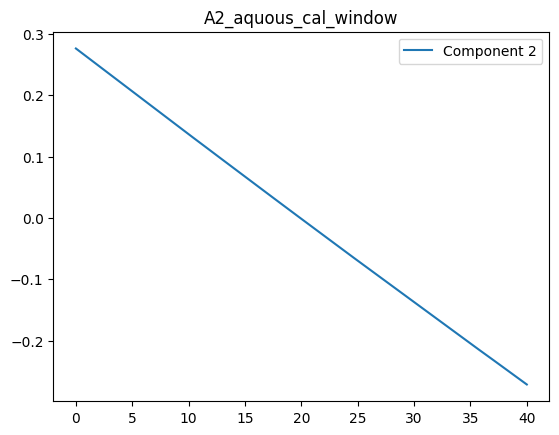

B1_blood_cal_window
Explain variance PC1 (%):  99.99402628874078
Explain variance PC2 (%):  0.005943245121920717
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414372  370.691377    2.814008
TimeSeries_12414373  373.625801    2.822501
TimeSeries_12414374  407.810233    3.268249
TimeSeries_12414375  405.188164    3.143201
TimeSeries_12414377  365.695460    2.549781
...                         ...         ...
TimeSeries_12470355 -117.699988   -3.399520
TimeSeries_12470361   60.284807   -1.418356
TimeSeries_12470365  125.647578   -0.829341
TimeSeries_12539049  129.244533   -1.050934
TimeSeries_12622570   -7.563354   -1.747086

[1431 rows x 2 columns]
The time series contributing most to PC1 is at index 472 with TestID 12437598
The time series contributing most to PC2 is at index 203 with TestID 12615993


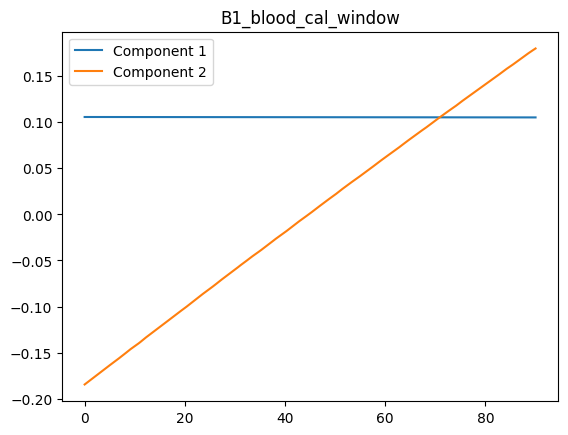

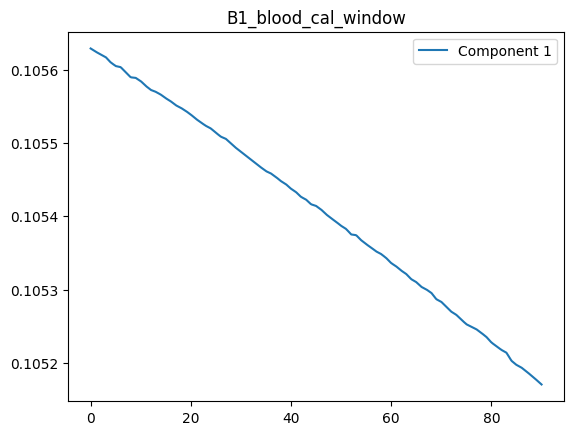

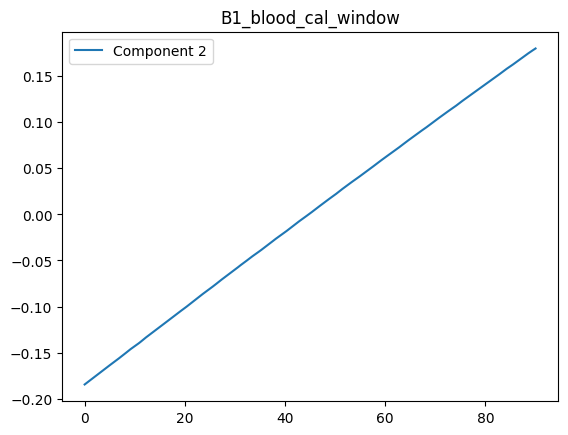

B2_blood_cal_window
Explain variance PC1 (%):  99.99374509609683
Explain variance PC2 (%):  0.006235825869662605
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3545083  542.405894    3.544643
TimeSeries_3545084  531.495469    3.188401
TimeSeries_3545085  458.332247    2.269276
TimeSeries_3545086  544.628557    3.788931
TimeSeries_3545087  455.449713    3.318268
...                        ...         ...
TimeSeries_3518583  578.831070   -6.471654
TimeSeries_3518675  603.310206   -6.095167
TimeSeries_3518676  425.468952   -5.943599
TimeSeries_3518677  412.730241   -7.148036
TimeSeries_3518678  311.542760   -7.127060

[2852 rows x 2 columns]
The time series contributing most to PC1 is at index 195 with TestID 3548448
The time series contributing most to PC2 is at index 2426 with TestID 3567819


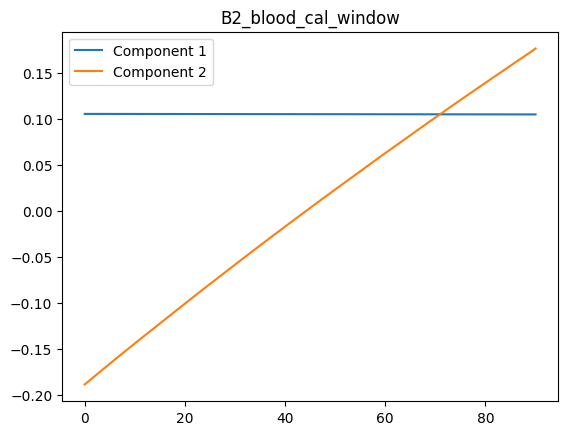

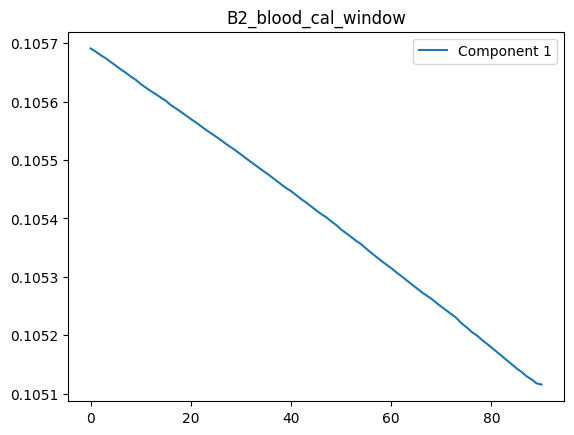

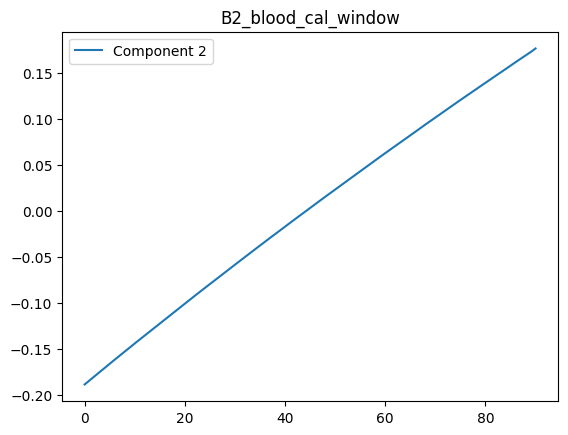

B1_aquous_cal_window
Explain variance PC1 (%):  99.99429965213389
Explain variance PC2 (%):  0.005674922119799834
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414200 -280.735614    3.616149
TimeSeries_12414201 -273.224911    3.950660
TimeSeries_12414202 -290.152444    3.608065
TimeSeries_12414203 -307.783676    3.319943
TimeSeries_12414204 -354.889295    3.775659
...                         ...         ...
TimeSeries_12537664 -246.348852    2.054196
TimeSeries_12537668 -172.027863    0.162744
TimeSeries_12624891  119.129034   -2.287491
TimeSeries_12624893   39.841893   -2.576547
TimeSeries_12537663 -137.189694    0.334835

[1944 rows x 2 columns]
The time series contributing most to PC1 is at index 219 with TestID 12544066
The time series contributing most to PC2 is at index 1681 with TestID 12395731


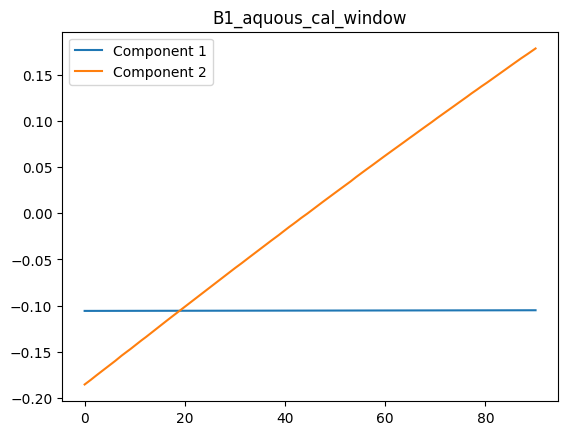

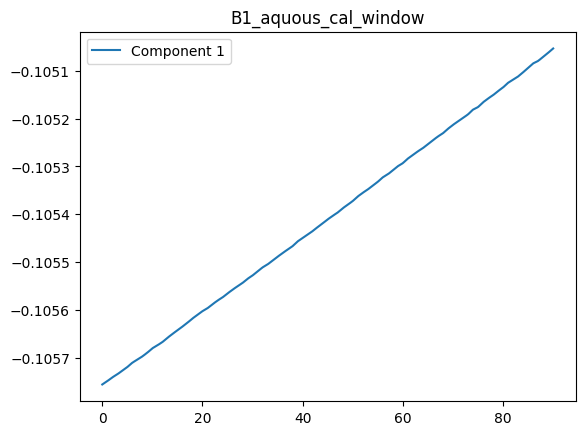

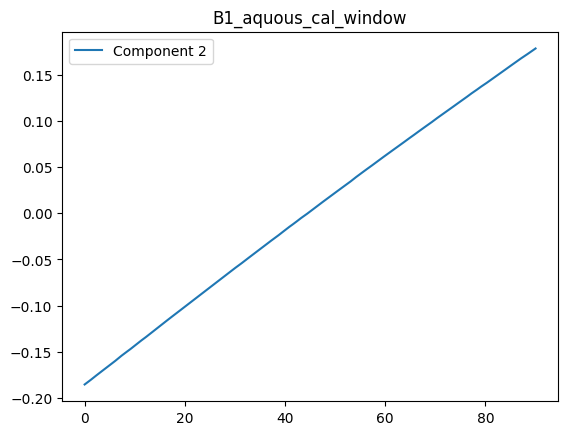

B2_aquous_cal_window
Explain variance PC1 (%):  99.99541540509131
Explain variance PC2 (%):  0.004567289166225336
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3550995  107.739368    0.463722
TimeSeries_3551012   10.189149   -0.872549
TimeSeries_3551031  315.567684   -0.174101
TimeSeries_3551047  189.279095    1.082127
TimeSeries_3551065  104.327362    0.521352
...                        ...         ...
TimeSeries_3518442  585.567207   -5.789235
TimeSeries_3518443  331.635655   -6.783318
TimeSeries_3518444  422.866251   -6.959739
TimeSeries_3518445  254.501070   -6.843832
TimeSeries_3518456  634.603988   -5.829742

[4893 rows x 2 columns]
The time series contributing most to PC1 is at index 418 with TestID 3556268
The time series contributing most to PC2 is at index 2526 with TestID 3567091


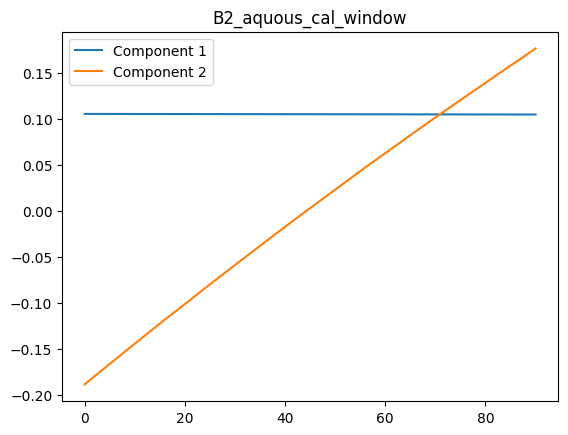

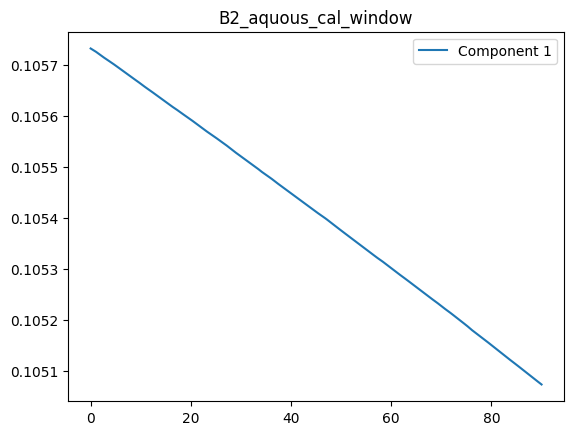

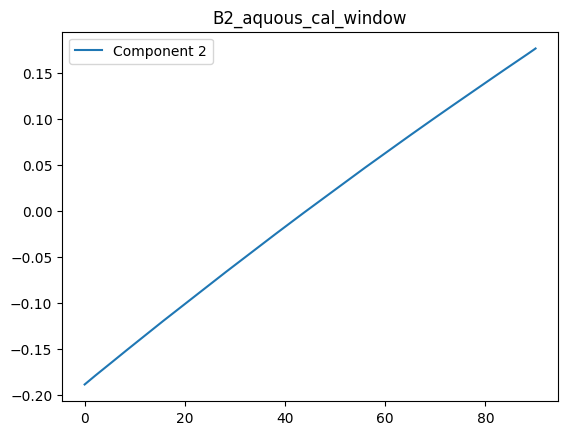

In [74]:
print("FPCA CALIBRATION WINDOW\n")
print("A1_cal_window")
perform_functional_pca(A1_cal_window, "A1_cal_window")
print("A2_cal_window")
perform_functional_pca(A2_cal_window, "A2_cal_window")
print("A1_blood_cal_window")
perform_functional_pca(A1_blood_cal_window, "A1_blood_cal_window")
print("A2_blood_cal_window")
perform_functional_pca(A2_blood_cal_window, "A2_blood_cal_window")
print("A1_aquous_cal_window")
perform_functional_pca(A1_aquous_cal_window, "A1_aquous_cal_window")
print("A2_aquous_cal_window")
perform_functional_pca(A2_aquous_cal_window, "A2_aquous_cal_window")
print("B1_blood_cal_window")
perform_functional_pca(B1_blood_cal_window, "B1_blood_cal_window")
print("B2_blood_cal_window")
perform_functional_pca(B2_blood_cal_window, "B2_blood_cal_window")
print("B1_aquous_cal_window")
perform_functional_pca(B1_aquous_cal_window, "B1_aquous_cal_window")
print("B2_aquous_cal_window")
perform_functional_pca(B2_aquous_cal_window, "B2_aquous_cal_window")

FPCA SAMPLE WINDOW

A1_sample_window
Explain variance PC1 (%):  99.99970783589137
Explain variance PC2 (%):  0.00028865273851068064
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414200 -364.644442   -0.282879
TimeSeries_12414201 -305.935026    0.005195
TimeSeries_12414202 -378.521086   -0.268362
TimeSeries_12414203 -366.840610   -0.229242
TimeSeries_12414204 -410.357556   -0.255063
...                         ...         ...
TimeSeries_12537663 -244.642467    0.395610
TimeSeries_12539049  -40.319011    0.308792
TimeSeries_12572832  311.002110   -0.296540
TimeSeries_12572836 -156.238221   -0.178490
TimeSeries_12622570  713.662600   -0.554970

[3349 rows x 2 columns]
The time series contributing most to PC1 is at index 2818 with TestID 12574513
The time series contributing most to PC2 is at index 531 with TestID 12615995


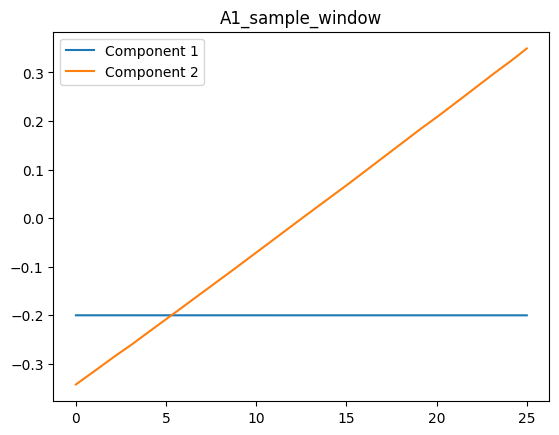

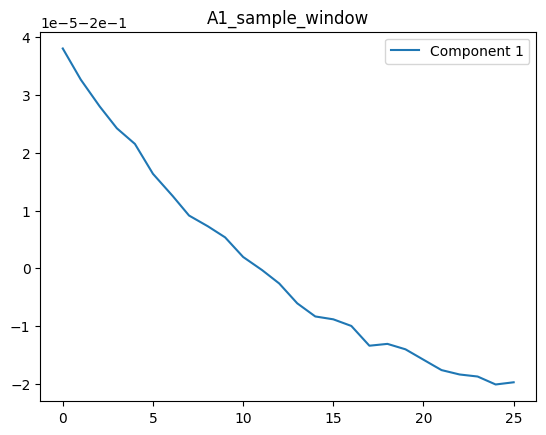

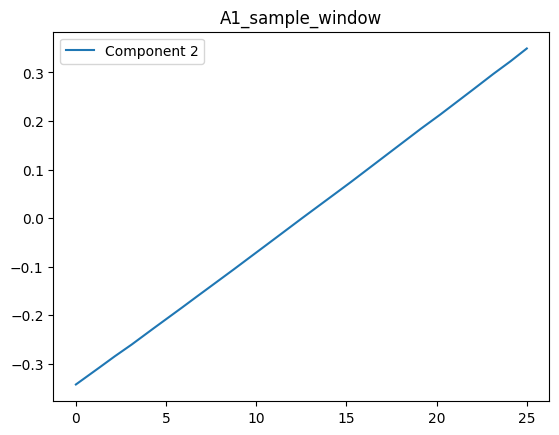

A2_sample_window
Explain variance PC1 (%):  99.99965471474869
Explain variance PC2 (%):  0.00034384565774712934
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3550995 -220.755540   -0.359323
TimeSeries_3551012 -162.149805   -0.390913
TimeSeries_3551031 -290.496379   -0.634445
TimeSeries_3551047 -225.124550   -0.378765
TimeSeries_3551065 -214.555525   -0.447031
...                        ...         ...
TimeSeries_3518461   37.409560   -0.404645
TimeSeries_3518462  165.836506   -0.329064
TimeSeries_3518621  112.185429   -0.608804
TimeSeries_3518680 -358.620202   -0.839022
TimeSeries_3518682  -98.790300   -0.881148

[7535 rows x 2 columns]
The time series contributing most to PC1 is at index 5354 with TestID 3556087
The time series contributing most to PC2 is at index 4259 with TestID 3561214


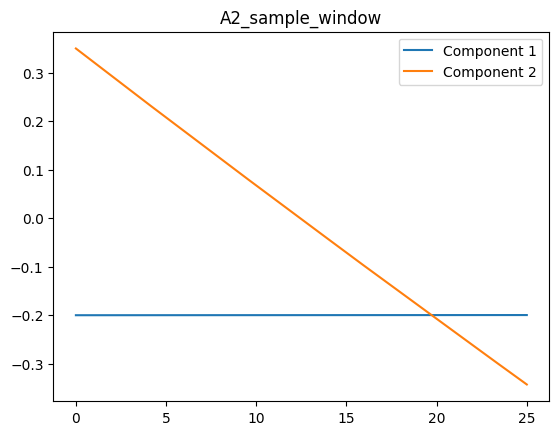

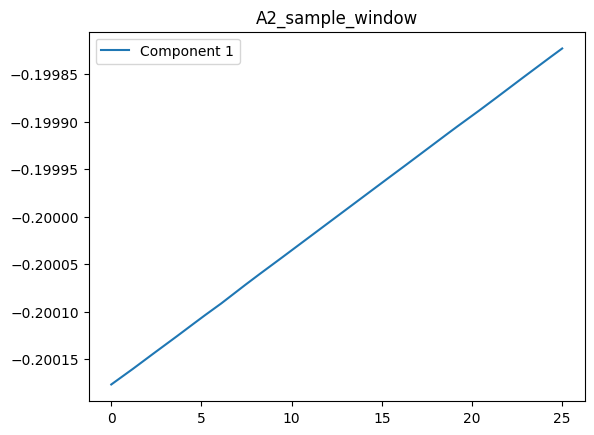

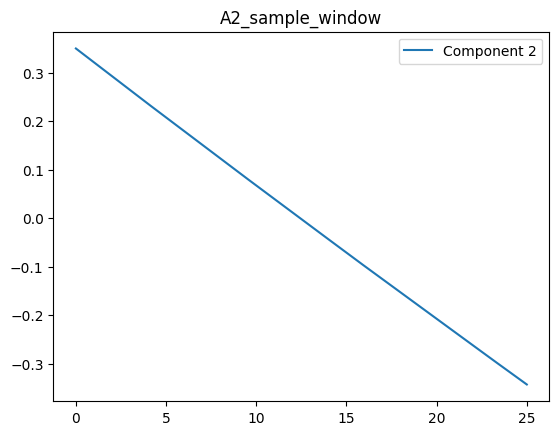

A1_blood_sample_window
Explain variance PC1 (%):  99.99968069791876
Explain variance PC2 (%):  0.0003160591053164732
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414372 -489.982772   -0.485935
TimeSeries_12414373 -462.558465   -0.513504
TimeSeries_12414374 -482.552371   -0.487822
TimeSeries_12414375 -463.162436   -0.507979
TimeSeries_12414377 -501.407032   -0.644194
...                         ...         ...
TimeSeries_12470355  354.783372   -0.472967
TimeSeries_12470361  436.176021   -0.387442
TimeSeries_12470365  -20.096427    0.304507
TimeSeries_12539049  -80.129929    0.202356
TimeSeries_12622570  673.851765   -0.585595

[1433 rows x 2 columns]
The time series contributing most to PC1 is at index 1042 with TestID 12573667
The time series contributing most to PC2 is at index 191 with TestID 12615995


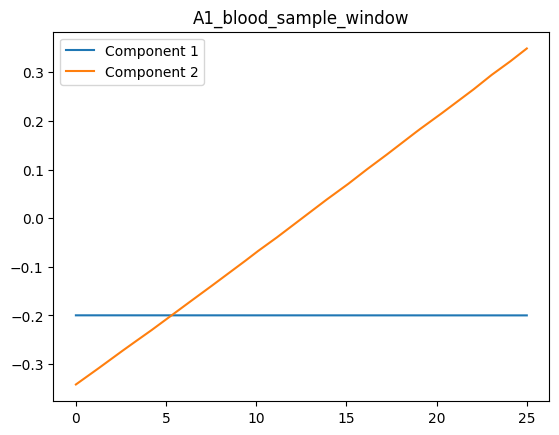

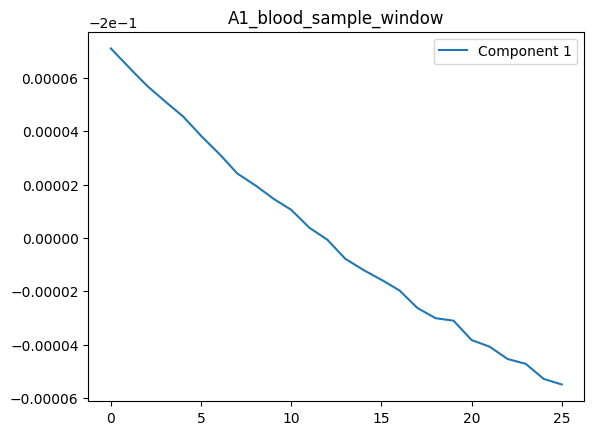

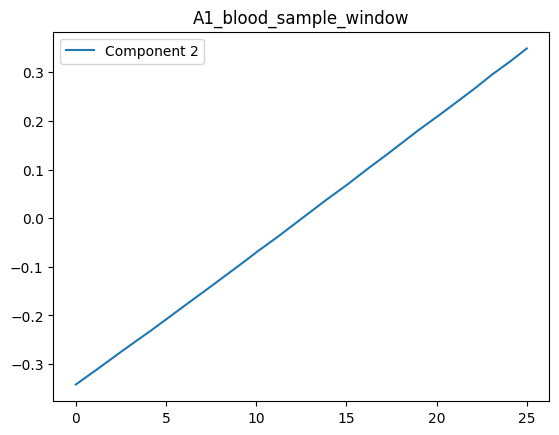

A2_blood_sample_window
Explain variance PC1 (%):  99.99967268126638
Explain variance PC2 (%):  0.0003265552418817567
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3545083 -515.248568    0.397099
TimeSeries_3545084 -478.296329    0.380575
TimeSeries_3545085 -389.179817    0.537300
TimeSeries_3545086 -447.029184    0.373680
TimeSeries_3545087 -414.500968    0.421194
...                        ...         ...
TimeSeries_3518708 -414.114940   -0.298086
TimeSeries_3518710  -24.861669   -0.722729
TimeSeries_3518621   94.209446   -0.497800
TimeSeries_3518680 -376.596177   -0.742087
TimeSeries_3518682 -116.766275   -0.776490

[2811 rows x 2 columns]
The time series contributing most to PC1 is at index 2133 with TestID 3572300
The time series contributing most to PC2 is at index 1063 with TestID 3569143


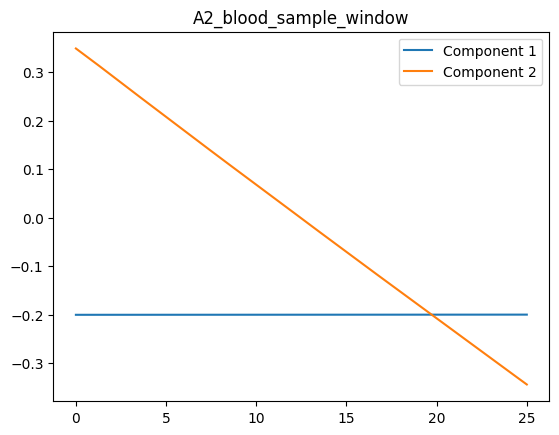

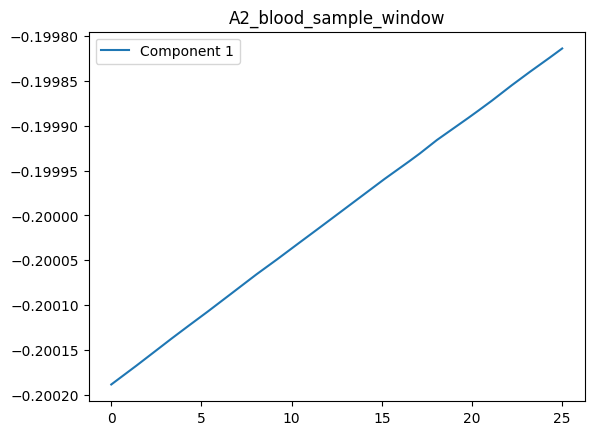

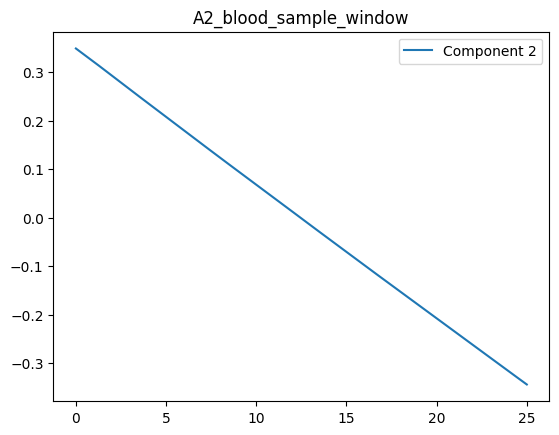

A1_aquous_sample_window
Explain variance PC1 (%):  99.9997387195891
Explain variance PC2 (%):  0.0002574785190827412
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414200 -334.869383    0.207780
TimeSeries_12414201 -276.159965   -0.080020
TimeSeries_12414202 -348.746026    0.193182
TimeSeries_12414203 -337.065550    0.154141
TimeSeries_12414204 -380.582496    0.179719
...                         ...         ...
TimeSeries_12624891   -1.555595   -0.135160
TimeSeries_12624893  -23.710333   -0.174037
TimeSeries_12537663 -214.867404   -0.470137
TimeSeries_12572832  340.777170    0.224526
TimeSeries_12572836 -126.463161    0.104302

[1916 rows x 2 columns]
The time series contributing most to PC1 is at index 1706 with TestID 12574513
The time series contributing most to PC2 is at index 462 with TestID 12191350


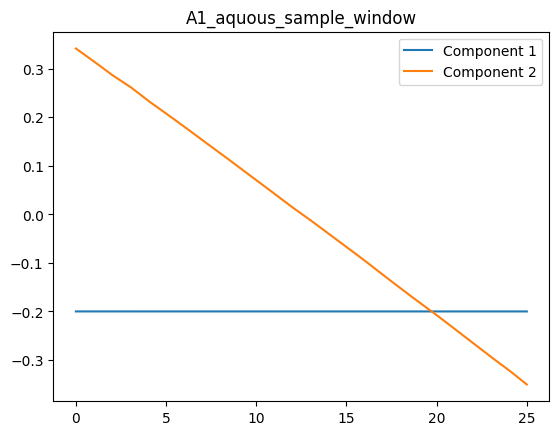

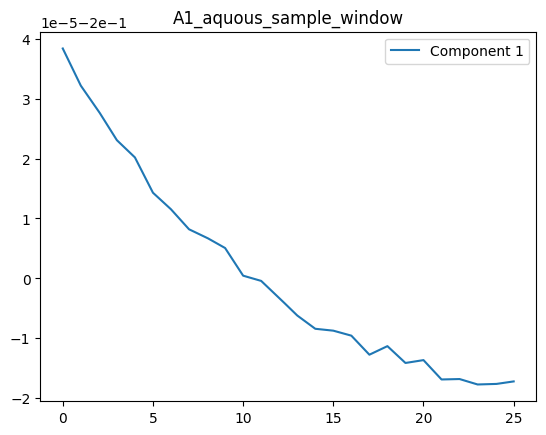

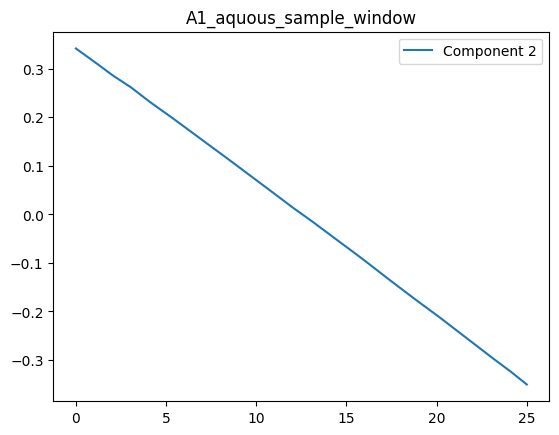

A2_aquous_sample_window
Explain variance PC1 (%):  99.99965471489615
Explain variance PC2 (%):  0.00034338480678314075
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3550995 -210.059002   -0.414799
TimeSeries_3551012 -151.453268   -0.448871
TimeSeries_3551031 -279.799852   -0.686968
TimeSeries_3551047 -214.428013   -0.434047
TimeSeries_3551065 -203.858991   -0.502776
...                        ...         ...
TimeSeries_3518459 -276.053118   -0.099670
TimeSeries_3518460 -305.040596   -0.588155
TimeSeries_3518431 -180.013621   -0.675405
TimeSeries_3518461   48.106096   -0.471015
TimeSeries_3518462  176.533045   -0.400926

[4724 rows x 2 columns]
The time series contributing most to PC1 is at index 3619 with TestID 3556087
The time series contributing most to PC2 is at index 3069 with TestID 3561214


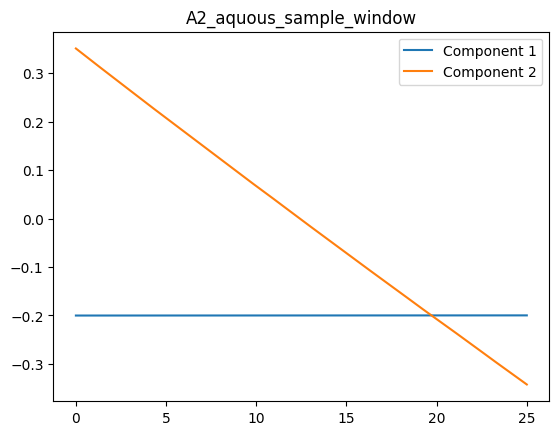

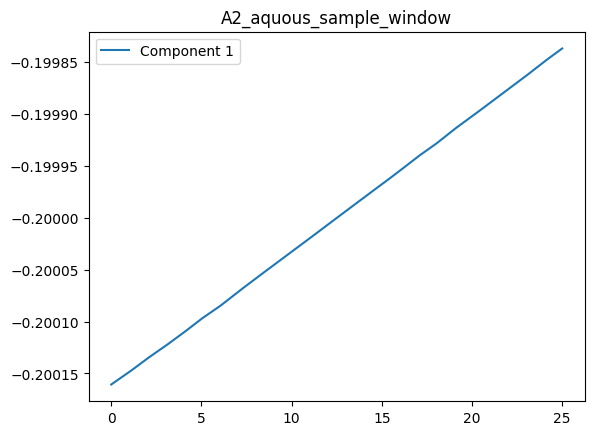

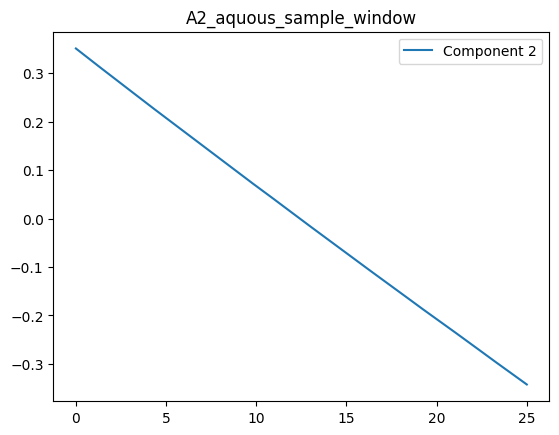

B1_blood_sample_window
Explain variance PC1 (%):  99.99960570010512
Explain variance PC2 (%):  0.00038319366738212037
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414372  181.515317   -0.364285
TimeSeries_12414373  181.024980   -0.286146
TimeSeries_12414374  198.557303   -0.380726
TimeSeries_12414375  197.413445   -0.320340
TimeSeries_12414377  176.746543   -0.313972
...                         ...         ...
TimeSeries_12470355  -69.309641    0.335421
TimeSeries_12470361   18.321632    0.122327
TimeSeries_12470365   48.214436    0.196206
TimeSeries_12539049   45.960486    0.105386
TimeSeries_12622570  -24.515683    0.151136

[1431 rows x 2 columns]
The time series contributing most to PC1 is at index 472 with TestID 12437598
The time series contributing most to PC2 is at index 1044 with TestID 12623840


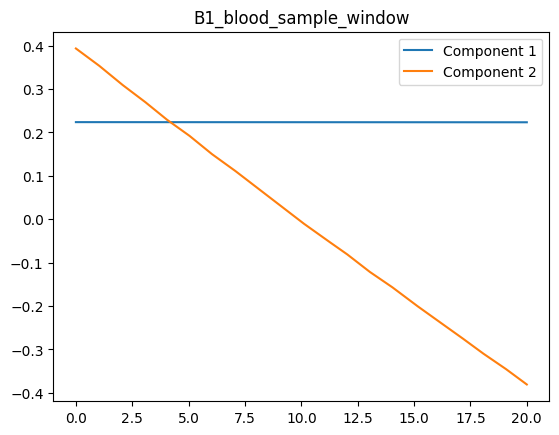

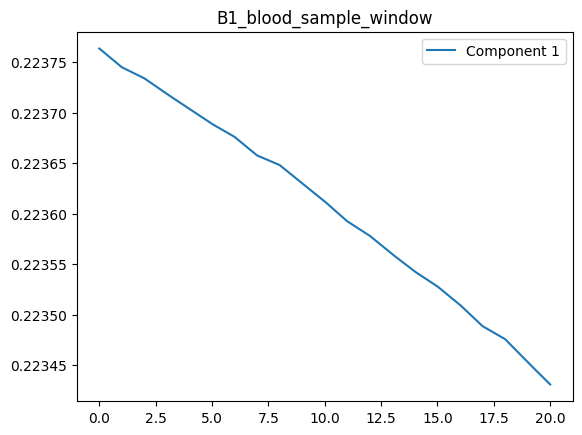

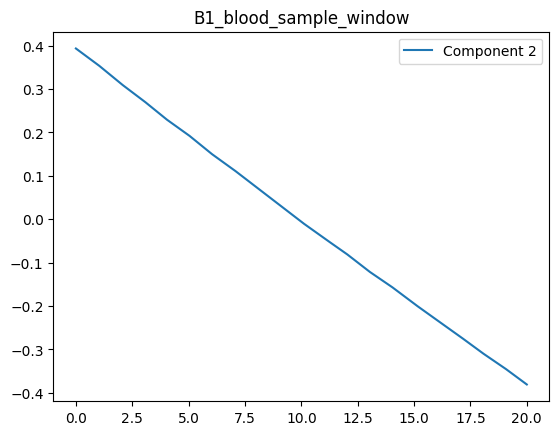

B2_blood_sample_window
Explain variance PC1 (%):  99.99974702797154
Explain variance PC2 (%):  0.0002506909087977939
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3545083  261.294239   -0.335643
TimeSeries_3545084  254.301284   -0.312213
TimeSeries_3545085  217.609479   -0.168808
TimeSeries_3545086  260.735559   -0.308287
TimeSeries_3545087  219.692205   -0.292579
...                        ...         ...
TimeSeries_3518583  248.067240    0.516560
TimeSeries_3518675  238.324538    0.523473
TimeSeries_3518676  156.944003    0.554370
TimeSeries_3518677  146.018127    0.728834
TimeSeries_3518678  100.489548    0.707769

[2852 rows x 2 columns]
The time series contributing most to PC1 is at index 212 with TestID 3548492
The time series contributing most to PC2 is at index 2825 with TestID 3518645


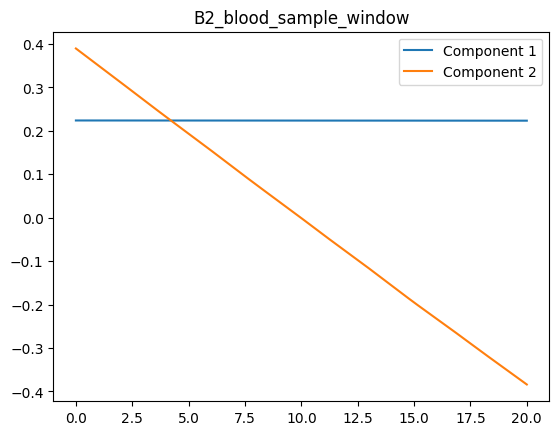

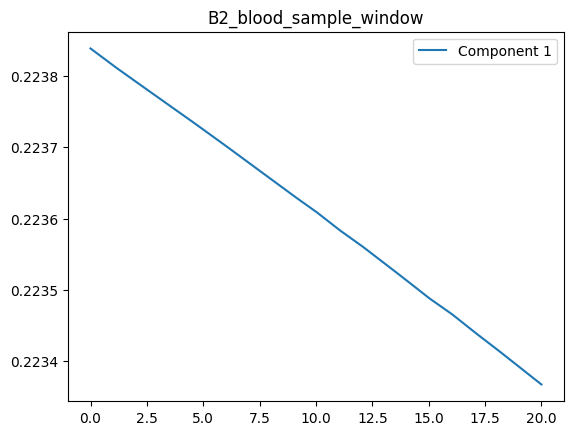

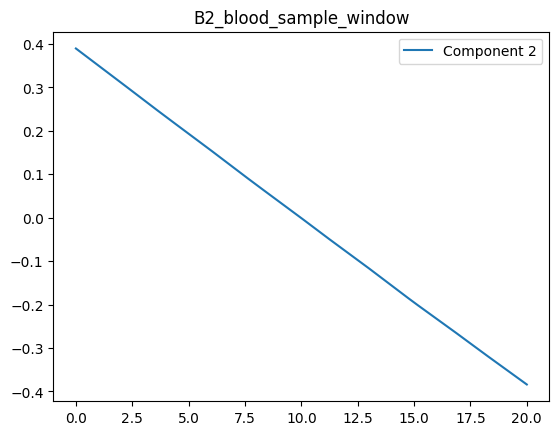

B1_aquous_sample_window
Explain variance PC1 (%):  99.99830581648685
Explain variance PC2 (%):  0.0016859486597204504
PC Scores:
                      PC1_Scores  PC2_Scores
TimeSeries_12414200 -114.560449   -0.255879
TimeSeries_12414201 -112.407429   -0.163802
TimeSeries_12414202 -117.550602   -0.178482
TimeSeries_12414203 -124.392031   -0.092398
TimeSeries_12414204 -150.182943   -0.190947
...                         ...         ...
TimeSeries_12537664 -230.051653   -0.051437
TimeSeries_12537668 -191.120924   -0.126594
TimeSeries_12624891  194.100589    0.659053
TimeSeries_12624893  172.427585    1.171202
TimeSeries_12537663 -175.678694   -0.037155

[1944 rows x 2 columns]
The time series contributing most to PC1 is at index 240 with TestID 12546591
The time series contributing most to PC2 is at index 452 with TestID 12191207


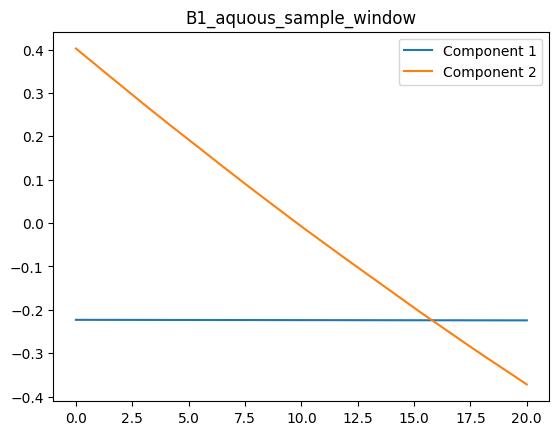

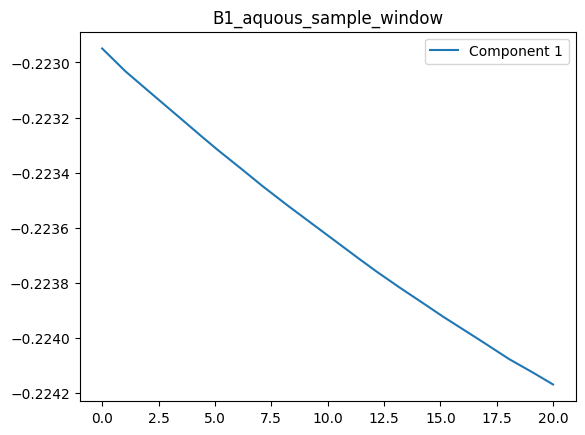

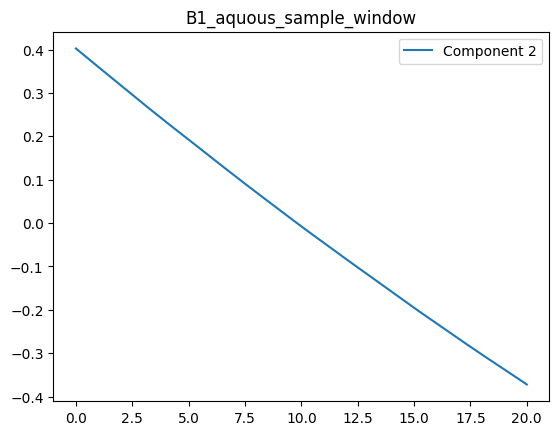

B2_aquous_sample_window
Explain variance PC1 (%):  99.99911546907185
Explain variance PC2 (%):  0.0008813943446089957
PC Scores:
                     PC1_Scores  PC2_Scores
TimeSeries_3550995  128.095012   -0.248638
TimeSeries_3551012   77.311894   -0.145738
TimeSeries_3551031  219.111875   -0.100257
TimeSeries_3551047  164.959339   -0.230717
TimeSeries_3551065  125.789176   -0.218458
...                        ...         ...
TimeSeries_3518442  116.113714    2.281318
TimeSeries_3518443   -4.613311    2.235800
TimeSeries_3518444   38.327432    2.268484
TimeSeries_3518445  -46.489611    2.595079
TimeSeries_3518456  139.737984    2.193040

[4893 rows x 2 columns]
The time series contributing most to PC1 is at index 418 with TestID 3556268
The time series contributing most to PC2 is at index 4868 with TestID 3518458


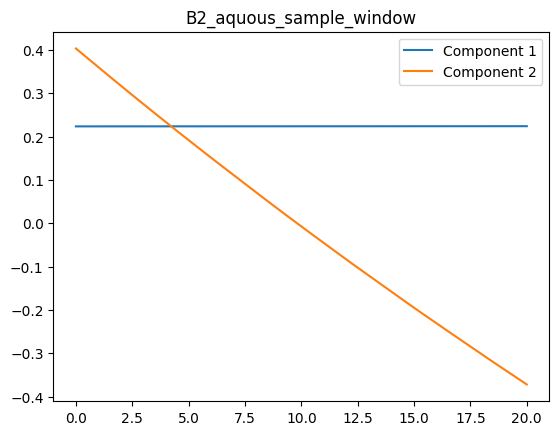

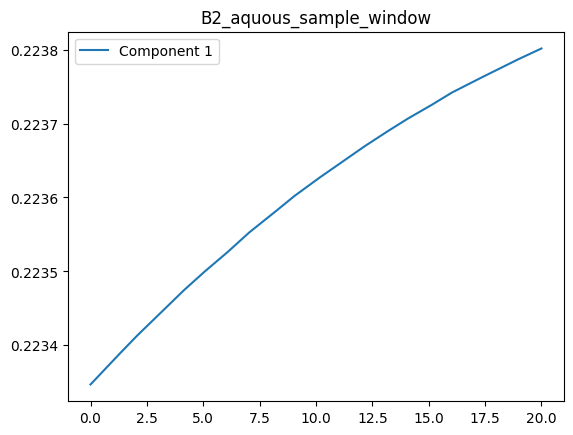

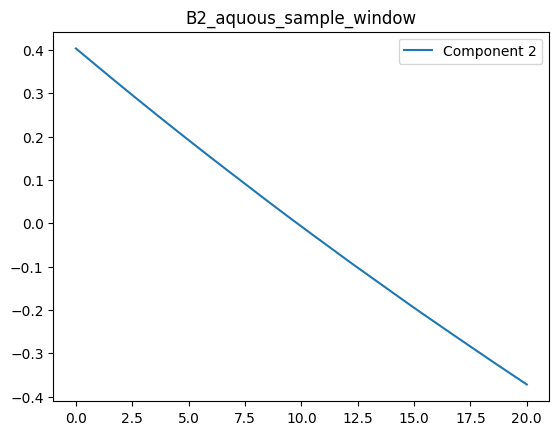

In [75]:
print("FPCA SAMPLE WINDOW\n")
print("A1_sample_window")
perform_functional_pca(A1_sample_window, "A1_sample_window")
print("A2_sample_window")
perform_functional_pca(A2_sample_window, "A2_sample_window")
print("A1_blood_sample_window")
perform_functional_pca(A1_blood_sample_window, "A1_blood_sample_window")
print("A2_blood_sample_window")
perform_functional_pca(A2_blood_sample_window, "A2_blood_sample_window")
print("A1_aquous_sample_window")
perform_functional_pca(A1_aquous_sample_window, "A1_aquous_sample_window" )
print("A2_aquous_sample_window")
perform_functional_pca(A2_aquous_sample_window, "A2_aquous_sample_window")
print("B1_blood_sample_window")
perform_functional_pca(B1_blood_sample_window, "B1_blood_sample_window")
print("B2_blood_sample_window")
perform_functional_pca(B2_blood_sample_window, "B2_blood_sample_window")
print("B1_aquous_sample_window")
perform_functional_pca(B1_aquous_sample_window, "B1_aquous_sample_window")
print("B2_aquous_sample_window")
perform_functional_pca(B2_aquous_sample_window, "B2_aquous_sample_window")

## 13. Functional One-way Anova

In [78]:
## 13. Functional One-way Anova


## 14. Functional Regression

In [79]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

import skfda
from skfda.ml.regression import LinearRegression
from skfda.representation.basis import FDataBasis, FourierBasis

In [80]:
def Function_regression(windows,Merge_dataset,len_time = 40,predictor = ["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"] ):
  # Prepare Data
  # Y_dna = windows.dropna() # drop NA
  merged_column = [list(row) for row in windows.iloc[:, :].to_numpy()] # Make time series table into list
  ## --- change y format ---
  # basis = skfda.representation.basis.MonomialBasis(n_basis=40)
  Y = FDataGrid(merged_column, grid_points = range(len(merged_column[1])))
  basis = FourierBasis(n_basis=len_time) # change FourierBasis
  y = Y.coordinates[0].to_basis(basis)
  ## --- change x format
  # drop_index = windows.loc[windows.isna().sum(axis=1)!=0].index # check the removed test ID
  # New_Merged =Merge_dataset.set_index("TestID")
  x = Merge_dataset.loc[:,predictor]
  # x = X.drop(drop_index)

  # Fit the model
  funct_reg = LinearRegression(fit_intercept=True)
  funct_reg.fit(x, y)

  print("To Check if we need to move any time stamp","\n")
  intercept = funct_reg.intercept_
  print("The Intercept of this model is:",intercept,"\n")
  for i in range(len(predictor)):
    coef = funct_reg.coef_[i]
    print("The coefficient of {} of this model is:{}".format(predictor[i],coef),"\n")
  return funct_reg

In [81]:
# def coefficent_visualization(funct_reg,funct_reg2,predictor,interval):
#   # Intercept
#   print(funct_reg.intercept_.coefficients[0][interval])
#   y = funct_reg.intercept_.coefficients[0][interval]
#   y2 = funct_reg2.intercept_.coefficients[0][interval]
#   x = np.arange(len(funct_reg.intercept_.coefficients[0][interval]))
#   plt.plot(x, y, label='intercept in system1')
#   plt.plot(x, y2, label='intercept in system2')
#   plt.legend()
#   plt.title("Intercept")
#   plt.show()

#   # Coefficient
#   for i in range(len(predictor)):
#     print(funct_reg.coef_[i].coefficients[0][interval])
#     y = funct_reg.coef_[i].coefficients[0][interval]
#     y2 = funct_reg2.coef_[i].coefficients[0][interval]
#     x = np.arange(len(funct_reg.coef_[i].coefficients[0][interval]))
#     plt.title(predictor[i])
#     plt.plot(x,y,label='Coefficient in system1')
#     plt.plot(x,y2,label='Coefficient in system2')
#     plt.legend()
#     plt.show()


In [82]:
def coefficent_visualization(funct_reg, funct_reg2, predictor, interval, title):
    num_predictors = len(predictor)
    num_intervals = len(funct_reg.intercept_.coefficients[0][interval])

    fig, axs = plt.subplots(num_predictors + 1, 1, figsize=(8, 6*num_predictors))

    # Set the overall title for the figure
    fig.suptitle(title, fontsize=16)

    # Intercept
    axs[0].plot(np.arange(num_intervals), funct_reg.intercept_.coefficients[0][interval], label='Intercept in system 1')
    axs[0].plot(np.arange(num_intervals), funct_reg2.intercept_.coefficients[0][interval], label='Intercept in system 2')
    axs[0].legend()
    axs[0].set_title('Intercept')

    # Coefficients
    for i in range(num_predictors):
        axs[i + 1].plot(np.arange(num_intervals), funct_reg.coef_[i].coefficients[0][interval], label='Coefficient in system 1')
        axs[i + 1].plot(np.arange(num_intervals), funct_reg2.coef_[i].coefficients[0][interval], label='Coefficient in system 2')
        axs[i + 1].legend()
        axs[i + 1].set_title(predictor[i])

    # Adjust the layout to make room for the title
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [84]:
# Regression on AmbientTemperature
print("For Calibration windows")
A1_cal_window_funct_reg = Function_regression(A1_cal_window,A1_Merged,40,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("----------------------------------------------------------------------------")
A2_cal_window_funct_reg = Function_regression(A2_cal_window,A2_Merged,40,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("\n")
A1_blood_cal_window_funct_reg = Function_regression(A1_blood_cal_window,A1_blood_Merged,40,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("----------------------------------------------------------------------------")
A2_blood_cal_window_funct_reg = Function_regression(A2_blood_cal_window,A2_blood_Merged,40,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("\n")
A1_aquous_cal_window_funct_reg = Function_regression(A1_aquous_cal_window,A1_aquous_Merged,40,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("----------------------------------------------------------------------------")
A2_aquous_cal_window_funct_reg = Function_regression(A2_aquous_cal_window,A2_aquous_Merged,40,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("\n")
B1_blood_cal_window_funct_reg = Function_regression(B1_blood_cal_window,B1_blood_Merged,90,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("----------------------------------------------------------------------------")
B2_blood_cal_window_funct_reg = Function_regression(B2_blood_cal_window,B2_blood_Merged,90,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("\n")
B1_aquous_cal_window_funct_reg = Function_regression(B1_aquous_cal_window,B1_aquous_Merged,90,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("----------------------------------------------------------------------------")
B2_aquous_cal_window_funct_reg = Function_regression(B2_aquous_cal_window,B2_aquous_Merged,90,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])


print("For Sample windows")
A1_sample_window_funct_reg = Function_regression(A1_sample_window,A1_Merged,25,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("----------------------------------------------------------------------------")
A2_sample_window_funct_reg = Function_regression(A2_sample_window,A2_Merged,25,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("\n")
A1_blood_sample_window_funct_reg = Function_regression(A1_blood_sample_window,A1_blood_Merged,25,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("----------------------------------------------------------------------------")
A2_blood_sample_window_funct_reg = Function_regression(A2_blood_sample_window,A2_blood_Merged,25,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("\n")
A1_aquous_sample_window_funct_reg = Function_regression(A1_aquous_sample_window,A1_aquous_Merged,25,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("----------------------------------------------------------------------------")
A2_aquous_sample_window_funct_reg = Function_regression(A2_aquous_sample_window,A2_aquous_Merged,25,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("\n")
B1_blood_sample_window_funct_reg = Function_regression(B1_blood_sample_window,B1_blood_Merged,20,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("----------------------------------------------------------------------------")
B2_blood_sample_window_funct_reg = Function_regression(B2_blood_sample_window,B2_blood_Merged,20,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("\n")
B1_aquous_sample_window_funct_reg = Function_regression(B1_aquous_sample_window,B1_aquous_Merged,20,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])
print("----------------------------------------------------------------------------")
B2_aquous_sample_window_funct_reg = Function_regression(B2_aquous_sample_window,B2_aquous_Merged,20,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"])



For Calibration windows
To Check if we need to move any time stamp 

The Intercept of this model is: FDataBasis(
    _basis=FourierBasis(domain_range=((0.0, 40.0),), n_basis=41, period=40.0),
    coefficients=[[ 5.92082473e+02 -8.32864809e+00  5.45340397e-01 -2.36651385e+00
       1.34856250e+01 -4.08636507e+00 -2.33509668e+01 -2.86720581e+00
      -2.75307256e+00 -2.48635423e+00 -1.04602093e+01 -2.03608625e+01
       3.65521658e+00 -7.71848475e+00 -1.42479992e+00 -2.11826624e+01
      -1.35088579e+01 -6.94423597e-02  1.26963891e+01  1.00354259e+01
      -4.02027857e-01  1.81095387e+01 -1.23411411e+01  6.37407772e+00
      -1.42412031e+01 -1.15895289e+01 -1.69634495e+01  6.52839458e+00
      -1.64810117e+00  4.40676669e-01  1.02338502e+01  1.57378409e+01
      -1.91766437e+01 -1.19574206e+01 -2.64387933e+01  7.57907253e+00
       1.56945036e+01  7.66690287e+00 -1.20356508e+01 -5.44011773e+14
       8.43465258e-01]]) 

The coefficient of AmbientTemperature of this model is:FDataBasis(
 

Sensor A


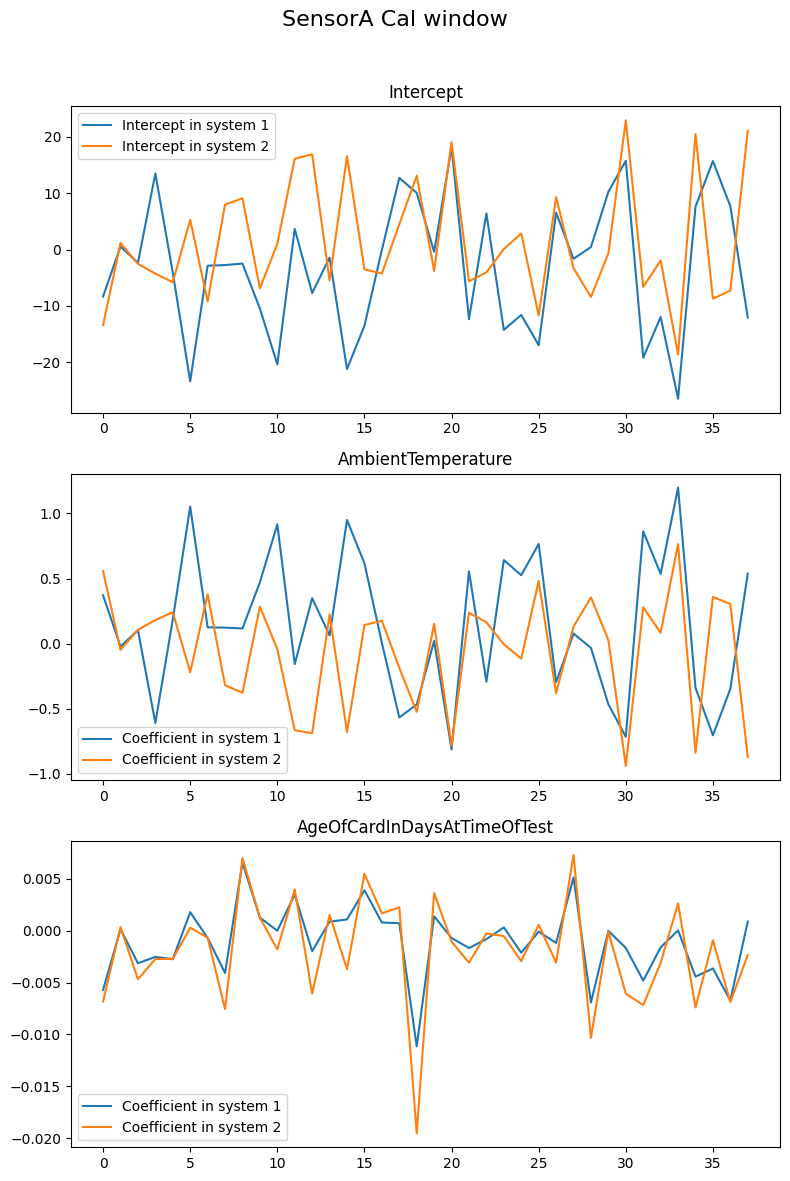


 For blood_cal_window


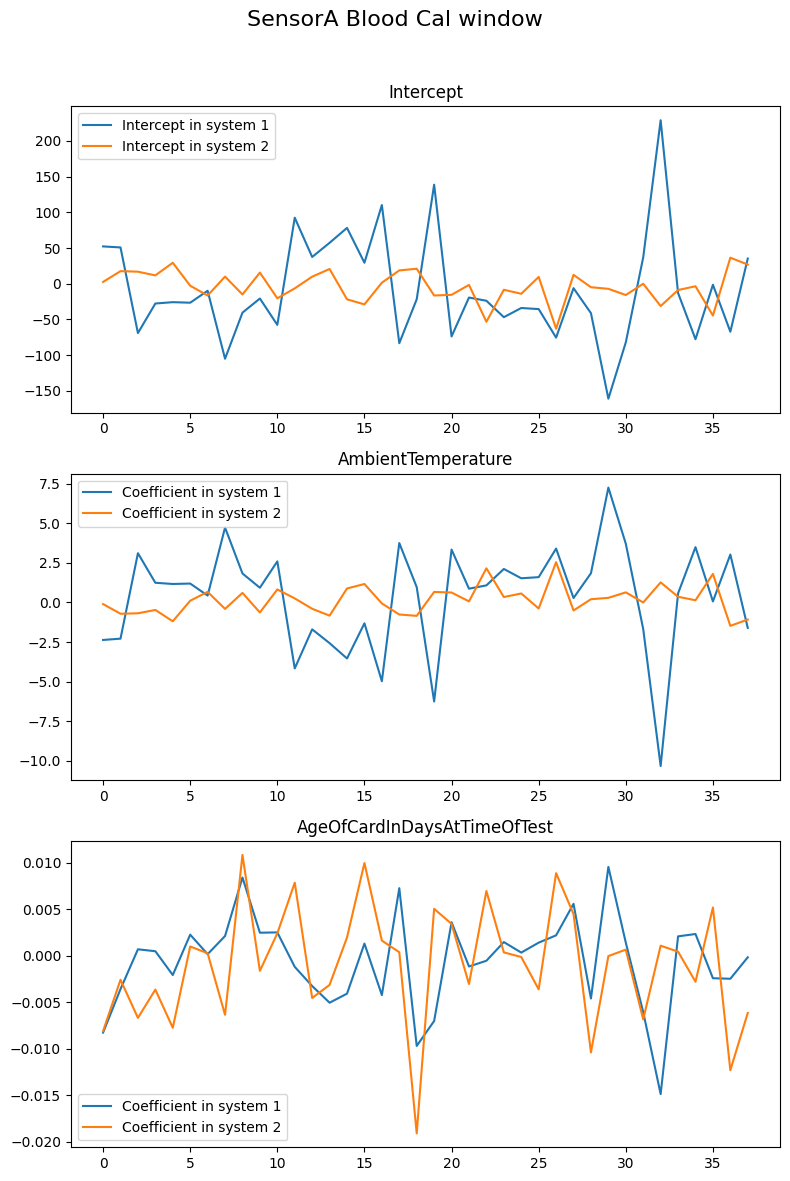


 For aqueous_cal_window


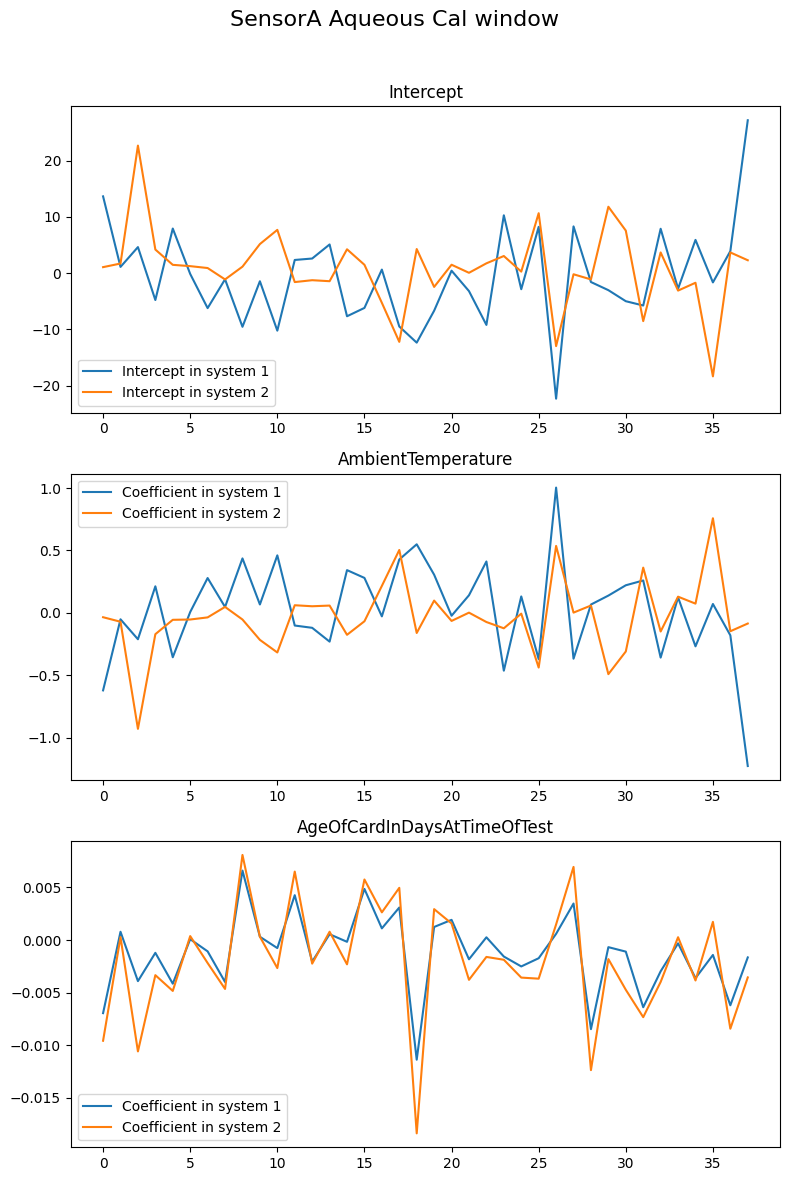


 For blood_cal_window
Sensor B


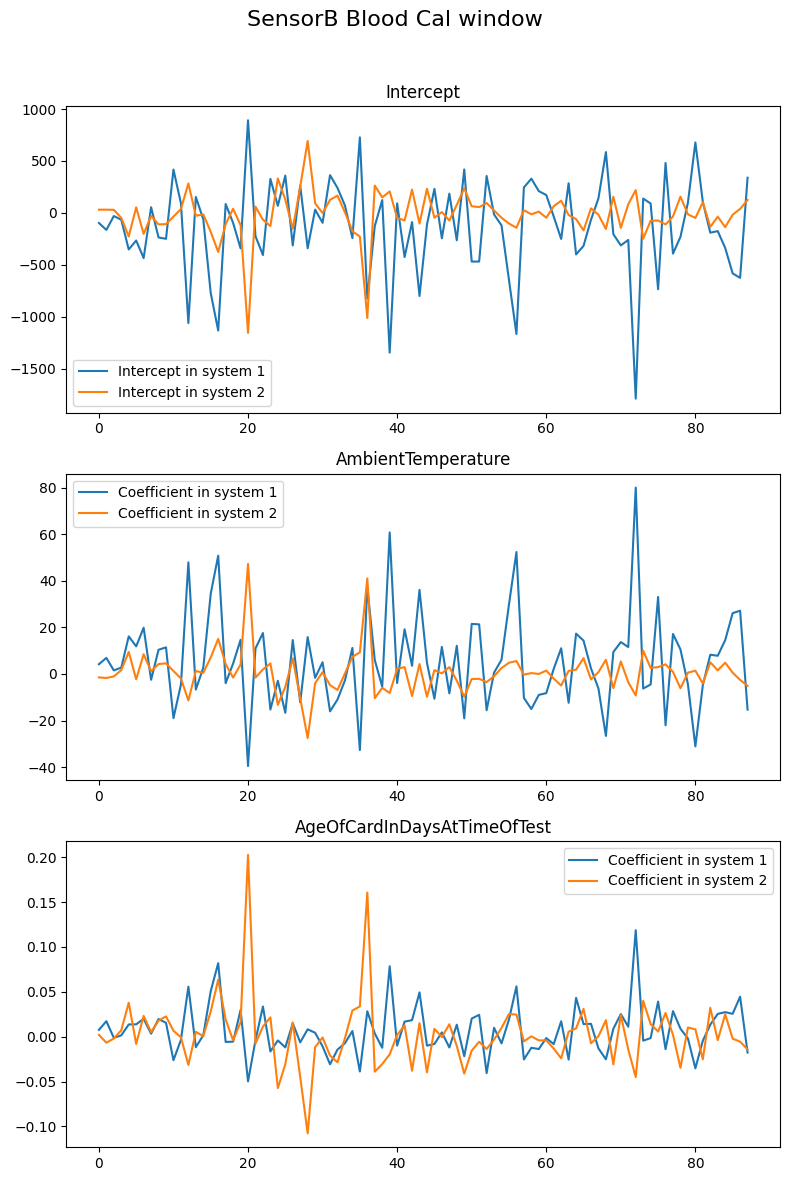


 For aqueous_cal_window


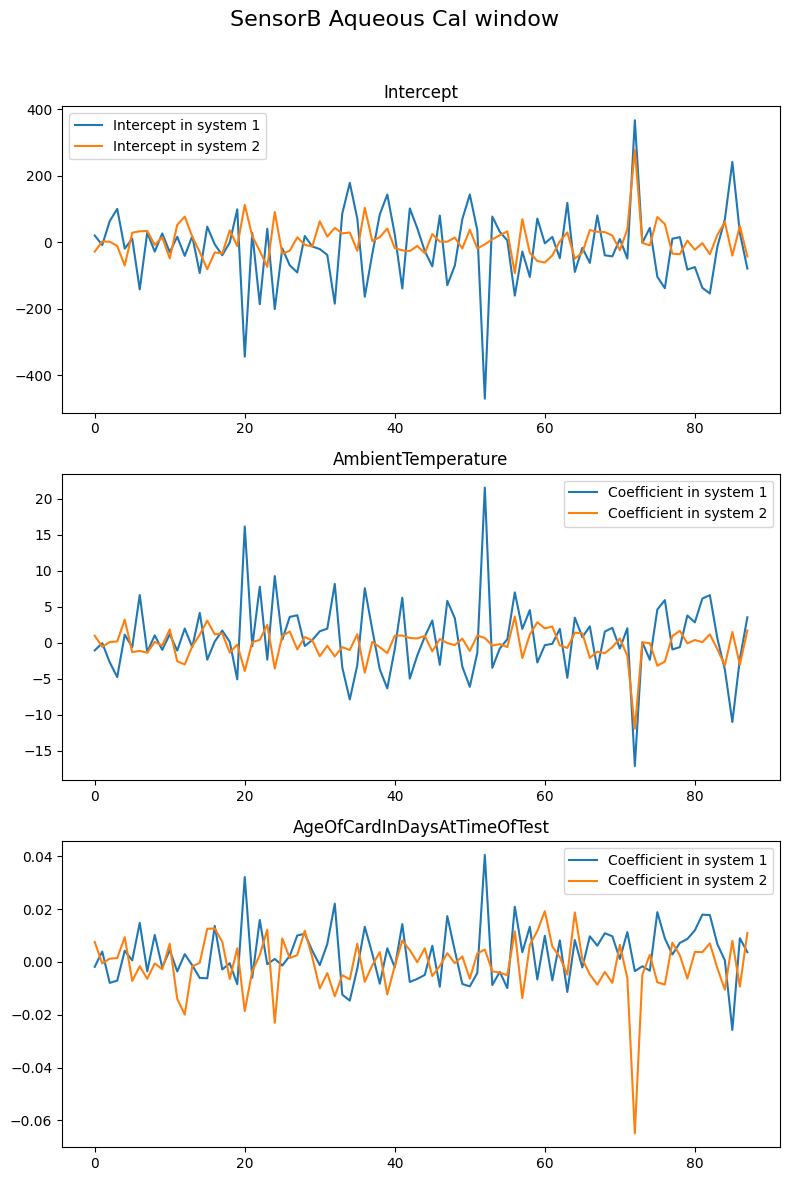

In [85]:
# Regression plot
# print("\n","For cal_window")
print("Sensor A")
coefficent_visualization(A1_cal_window_funct_reg,A2_cal_window_funct_reg,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"],range(1,39),"SensorA Cal window")
print("\n","For blood_cal_window")
coefficent_visualization(A1_blood_cal_window_funct_reg,A2_blood_cal_window_funct_reg,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"],range(1,39),"SensorA Blood Cal window")
print("\n","For aqueous_cal_window")
coefficent_visualization(A1_aquous_cal_window_funct_reg,A2_aquous_cal_window_funct_reg,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"],range(1,39),"SensorA Aqueous Cal window")
print("\n","For blood_cal_window")
print("Sensor B")
coefficent_visualization(B1_blood_cal_window_funct_reg,B2_blood_cal_window_funct_reg,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"],range(1,89),"SensorB Blood Cal window")
print("\n","For aqueous_cal_window")
coefficent_visualization(B1_aquous_cal_window_funct_reg,B2_aquous_cal_window_funct_reg,["AmbientTemperature","AgeOfCardInDaysAtTimeOfTest"],range(1,89),"SensorB Aqueous Cal window")





 For sample_window
Sensor A


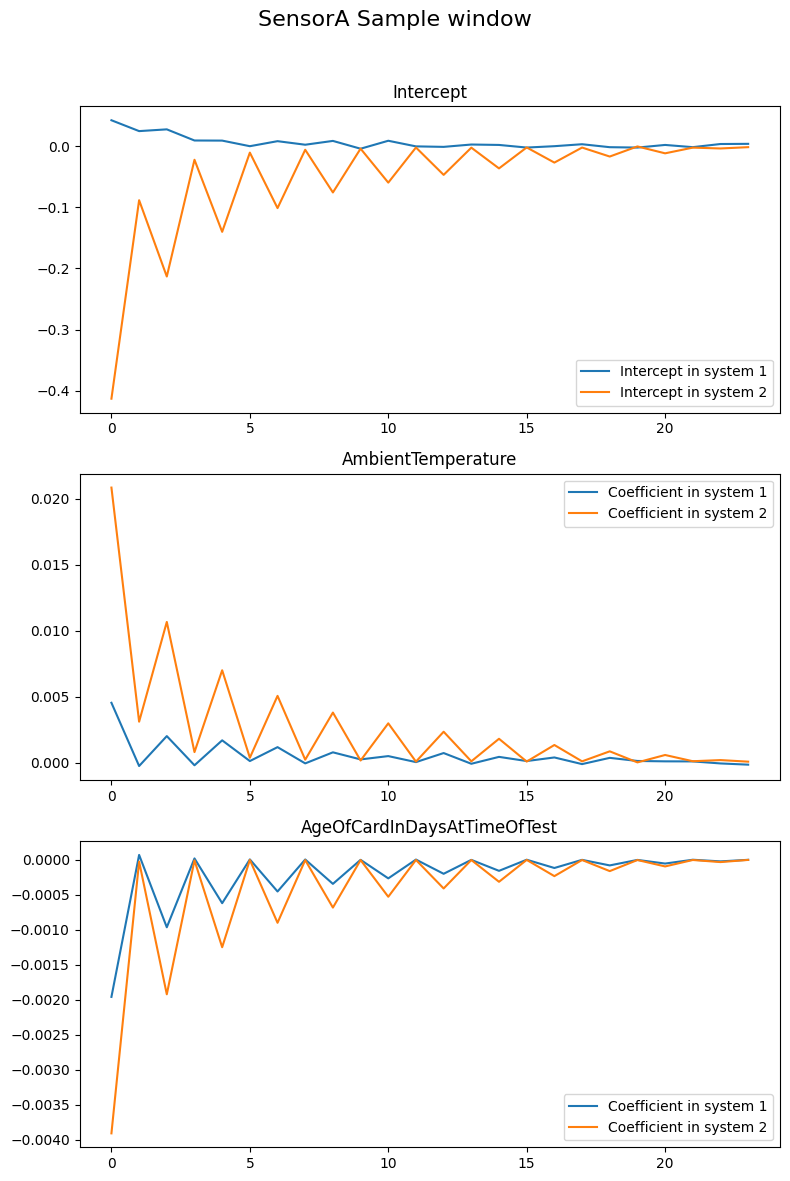


 For blood_sample_window


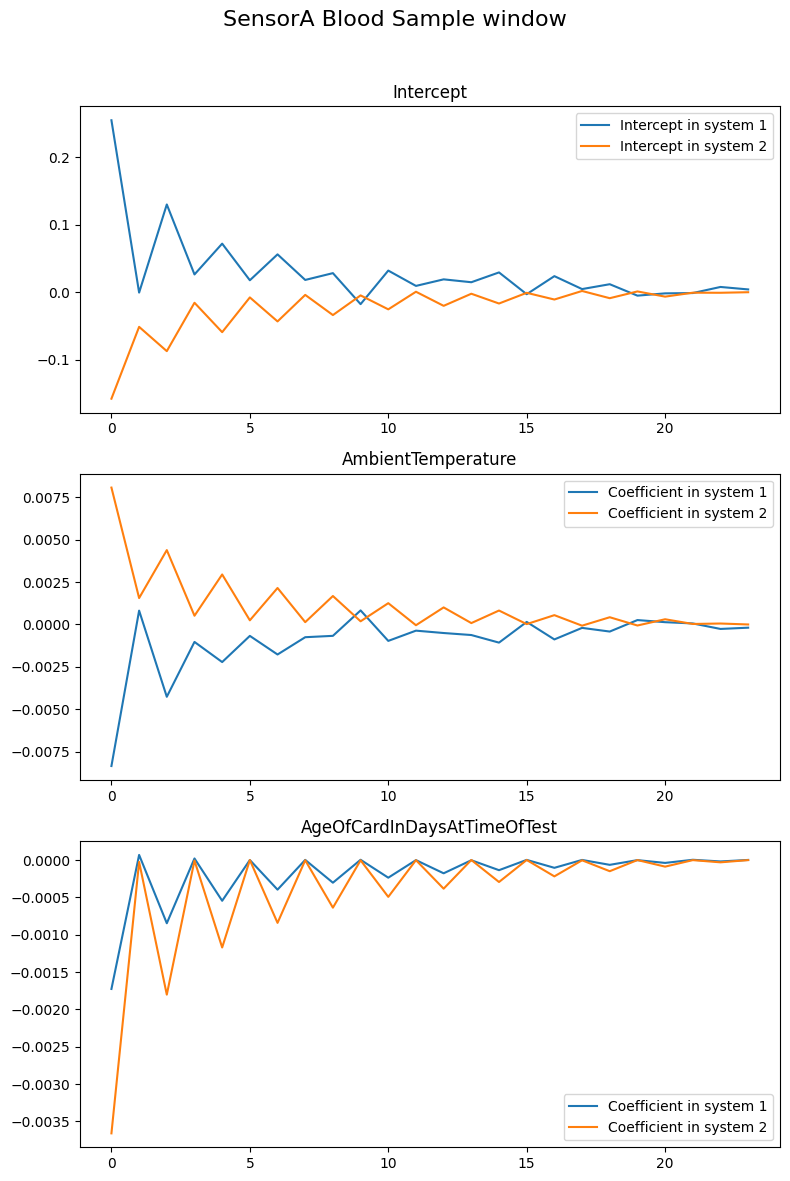


 For aqueous_sample_window


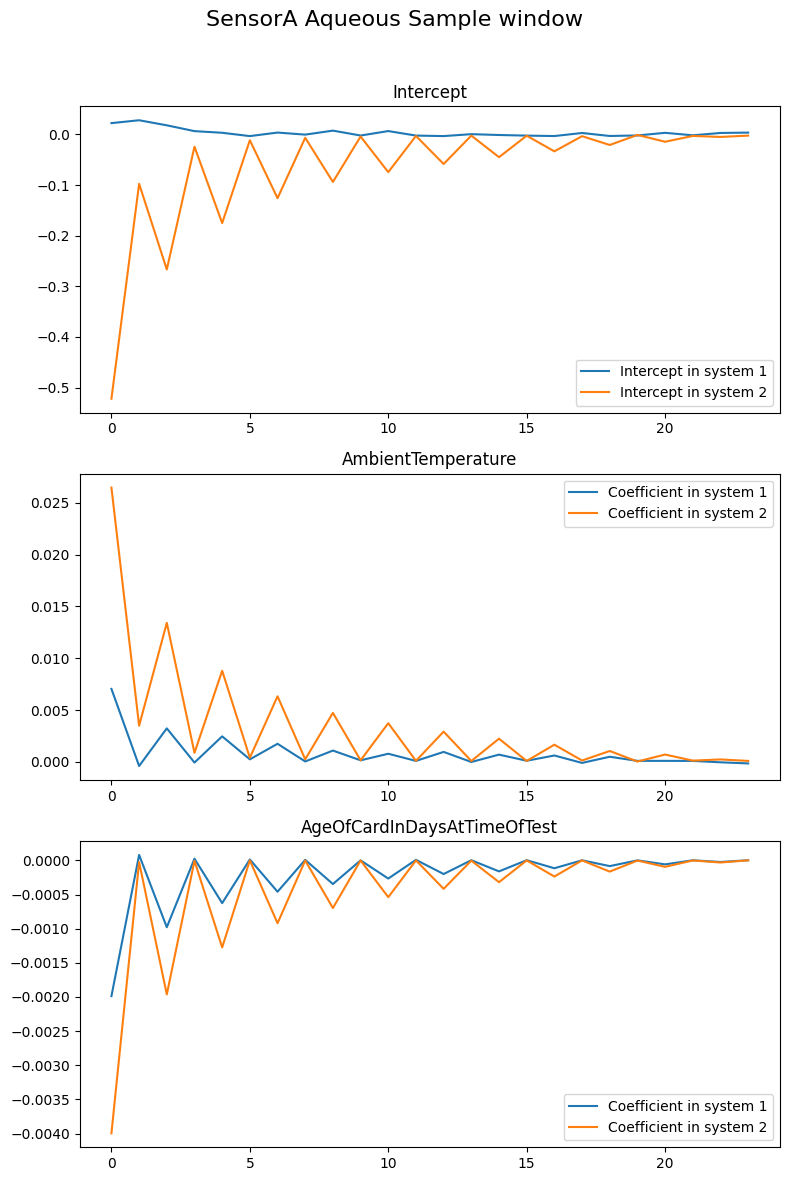


 For blood_sample_window
Sensor B


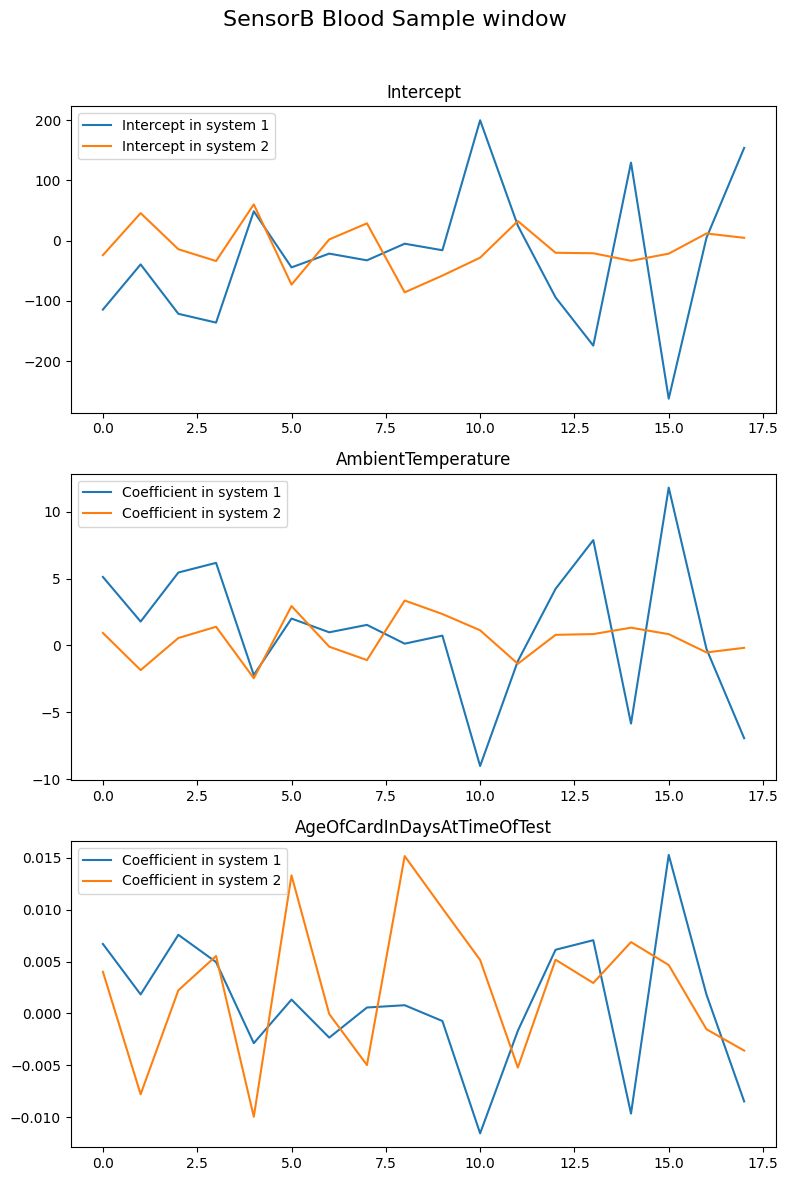


 For aqueous_sample_window


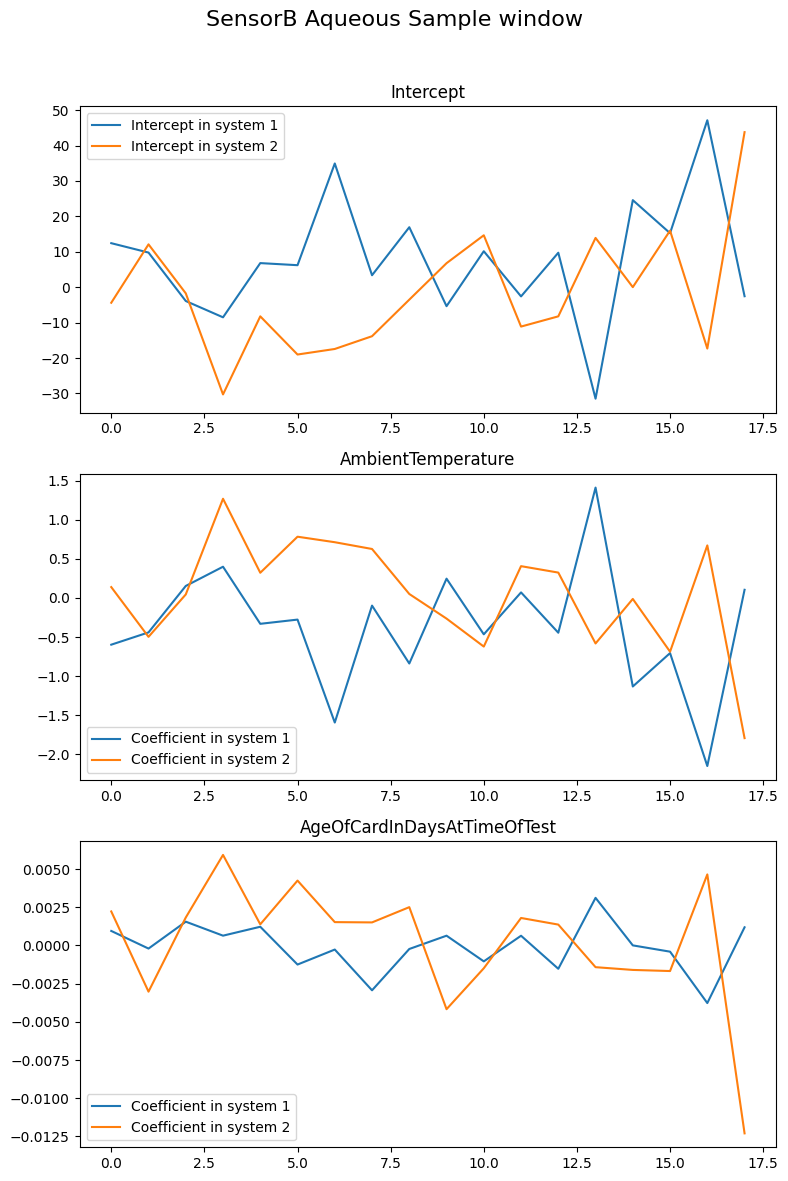

In [86]:
# Adding titles for sample windows
print("\n", "For sample_window")
print("Sensor A")
coefficent_visualization(A1_sample_window_funct_reg, A2_sample_window_funct_reg, ["AmbientTemperature", "AgeOfCardInDaysAtTimeOfTest"], range(1,25), "SensorA Sample window")
print("\n", "For blood_sample_window")
coefficent_visualization(A1_blood_sample_window_funct_reg, A2_blood_sample_window_funct_reg, ["AmbientTemperature", "AgeOfCardInDaysAtTimeOfTest"], range(1, 25), "SensorA Blood Sample window")
print("\n", "For aqueous_sample_window")
coefficent_visualization(A1_aquous_sample_window_funct_reg, A2_aquous_sample_window_funct_reg, ["AmbientTemperature", "AgeOfCardInDaysAtTimeOfTest"], range(1, 25), "SensorA Aqueous Sample window")
print("\n", "For blood_sample_window")
print("Sensor B")
coefficent_visualization(B1_blood_sample_window_funct_reg, B2_blood_sample_window_funct_reg, ["AmbientTemperature", "AgeOfCardInDaysAtTimeOfTest"], range(1, 19), "SensorB Blood Sample window")
print("\n", "For aqueous_sample_window")
coefficent_visualization(B1_aquous_sample_window_funct_reg, B2_aquous_sample_window_funct_reg, ["AmbientTemperature", "AgeOfCardInDaysAtTimeOfTest"], range(1, 19), "SensorB Aqueous Sample window")